In [1]:
#| hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [2]:
import warnings; warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [4]:
from fastai.text.all import *
# from fastai.distributed import *
from fastai.collab import *

from xcube.data.transforms import *
from xcube.text.learner import *
from xcube.collab import *
from xcube.metrics import *
from xcube.utils import *
from xcube.imports import *

In [5]:
#| hide
from nbdev.showdoc import *

In [6]:
paths = make_paths(Path.cwd(), 'mimic3-9k')
globals().update(paths)

Make sure we have that GPU:

In [7]:
ic(torch.cuda.get_device_name(default_device()));
test_eq(torch.cuda.get_device_name(0), torch.cuda.get_device_name(default_device()))
test_eq(default_device(), torch.device(0))

ic| torch.cuda.get_device_name(default_device()): 'Quadro RTX 8000'


These are temporary (remove later!)

In [8]:
collab_path_tiny = collab_path.parent/ Path((n:=collab_path.name.split('.'))[0]+'_tiny.'+n[1])

# Mimic3-9K (Sample)

> API details

#### Directory Structure Creation

We will use `get_paths` to set the base path and create the directory structure:

In [ ]:
paths = make_paths(Path.cwd(), 'mimic3-9k')
globals().update(paths)

In this notebook we are going to create a small sample for the purpose of quick iteration. So below let's create some symlinks that we are going to point to the the main dataset and the language model (Only nned to run the following symlinks once):

To be safe, delete any existing symlinks:

In [ ]:
for p in plist:
    if p.is_symlink(): p.unlink()

Symlink the data:

In [ ]:
data.symlink_to(path.parent/'data'/(file_prefix+'.csv'))
data

Path('/home/deb/xcube/nbs/examples/mimic/sample/data/mimic3-9k.csv')

Symlink the language model (fwd and bwd):

In [ ]:
lm_path.symlink_to(path.parent/'models'/(file_prefix+'_lm.pth'))
lm_path.exists(), lm_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm.pth'))

In [ ]:
lm_r_path.symlink_to(path.parent/'models'/(file_prefix+'_lm_r.pth'))
lm_r_path.exists(), lm_r_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_r.pth'))

Symlink the language model encoder (fwd and bwd):

In [ ]:
lm_finetuned_path.symlink_to(path.parent/'models'/(file_prefix+'_lm_finetuned.pth'))
lm_finetuned_path.exists(), lm_finetuned_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_finetuned.pth'))

In [ ]:
lm_finetuned_r_path.symlink_to(path.parent/'models'/(file_prefix+'_lm_finetuned_r.pth'))
lm_finetuned_r_path.exists(), lm_finetuned_r_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_finetuned_r.pth'))

Symlink the language model vocab (fwd and bwd): (Well we don't really need both as those are same.)

In [ ]:
dls_lm_vocab_path.symlink_to(path.parent/'models'/(file_prefix+'_dls_lm_vocab.pkl'))
dls_lm_vocab_path.exists(), dls_lm_vocab_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_vocab.pkl'))

In [ ]:
dls_lm_vocab_r_path.symlink_to(path.parent/'models'/(file_prefix+'_dls_lm_vocab_r.pkl'))
dls_lm_vocab_r_path.exists(), dls_lm_vocab_r_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_vocab_r.pkl'))

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [ ]:
# !head -n 1 {data}

In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [ ]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [ ]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,xxbos admission date discharge date date of birth sex m service cardiac surgery chief complaint chest pain history of present illness mr known lastname is a year old man with a history of hypertension who presented to an outside hospital complaining of chest pain radiating to his jaw and arms he went to his local emergency department where they found that his cardiac enzymes were negative his electrocardiogram showed a right bundle branch block and his chest pain was typical,admission date discharge date date of birth sex m service cardiac surgery chief complaint chest pain history of present illness mr known lastname is a year old man with a history of hypertension who presented to an outside hospital complaining of chest pain radiating to his jaw and arms he went to his local emergency department where they found that his cardiac enzymes were negative his electrocardiogram showed a right bundle branch block and his chest pain was typical for
1,outpatient he will need to continue hd m w f first name8 namepattern2 name8 md md doctor first name completed by xxbos admission date discharge date date of birth sex m service medicine allergies keflex vioxx codeine attending last name namepattern1 chief complaint le edema and dyspnea major surgical or invasive procedure none history of present illness 51 m with t2 dm unclear diastolic chf htn and chronic pain on narcotics who presents with worsening le edema and sob at,he will need to continue hd m w f first name8 namepattern2 name8 md md doctor first name completed by xxbos admission date discharge date date of birth sex m service medicine allergies keflex vioxx codeine attending last name namepattern1 chief complaint le edema and dyspnea major surgical or invasive procedure none history of present illness 51 m with t2 dm unclear diastolic chf htn and chronic pain on narcotics who presents with worsening le edema and sob at rehab


The length of our vocabulary is:

In [ ]:
len(dls_lm.vocab)

57376

Let's take a look at some words of the vocab:

In [ ]:
print(coll_repr(L(dls_lm.vocab), 30))

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [ ]:
torch.save(dls_lm, dls_lm_path)
torch.save(dls_lm.vocab, dls_lm_vocab_path)

To load back the `dls_lm` later on:

In [ ]:
dls_lm = torch.load(dls_lm_path)

## `Learner` for the Language Model Fine-Tuning:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.646323,3.512013,0.382642,33.515659,2:27:57


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [ ]:
learn.save('lm')

Path('models/lm.pth')

Let's now load back the `Learner`

In [ ]:
learn = learn.load('lm')

Let's validate the `Learner` to make sure we loaded the correct version:

In [ ]:
learn.validate()

(#3) [2.1801044940948486,0.551633358001709,8.847230911254883]

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname='lm'))

Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [ ]:
learn.save_encoder('lm_finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

### Loading Raw Data

In [ ]:
data

Path('/home/deb/xcube/nbs/examples/mimic/sample/data/mimic3-9k.csv')

In [ ]:
# !head -n 1 {data}

In [ ]:
# !shuf -n 200000 {data} > {data_sample} 

In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


Sample a small fraction of the dataset to ensure quick iteration:

In [ ]:
# df = df.sample(frac=0.3, random_state=89, ignore_index=True)
# df = df.sample(frac=0.025, random_state=89, ignore_index=True)
df = df.sample(frac=0.005, random_state=89, ignore_index=True)
len(df)

264

Let's now gather the labels from the 'labels' columns of the df:

In [ ]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(lbl_freqs)

8922

Let's take a look at the most common labels:

In [ ]:
pd.DataFrame(lbl_freqs.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179
5,96.04,9932
6,96.6,9161
7,584.9,8907
8,250.00,8784
9,96.71,8619


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = list(lbl_freqs.keys())

### Dataset Statistics 

#### Check #1: Number of instances (train/valid split)

In [ ]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(244, 20)

#### Check #2: Avg number of instances per label

In [ ]:
array(list(lbl_freqs.values())).mean()

3.341463414634146

#### Check #3: Plotting the label distribution

In [ ]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(',')))

In [ ]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [ ]:
df_copy.head(2)

,text,labels,is_valid,label_count
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3


The average number of labels per instance is:

In [ ]:
df_copy.label_count.mean()

5.385563363865518

/home/deb/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


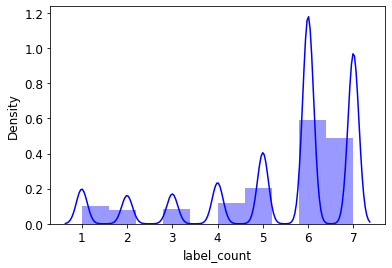

In [ ]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [ ]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [ ]:
lbls_sorted[:20]

[('455619', 2258),
 ('455662', 2176),
 ('547041', 2160),
 ('516790', 1214),
 ('455712', 1203),
 ('455620', 1133),
 ('632786', 1132),
 ('632789', 1132),
 ('632785', 1030),
 ('632788', 1030),
 ('492255', 938),
 ('455014', 872),
 ('670034', 850),
 ('427871', 815),
 ('599701', 803),
 ('308331', 801),
 ('581325', 801),
 ('649272', 799),
 ('455704', 762),
 ('666760', 733)]

In [ ]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#670091) ['455619','455662','547041','516790','455712','455620','632786','632789','632785','632788'...],
 (#670091) [2258,2176,2160,1214,1203,1133,1132,1132,1030,1030...])

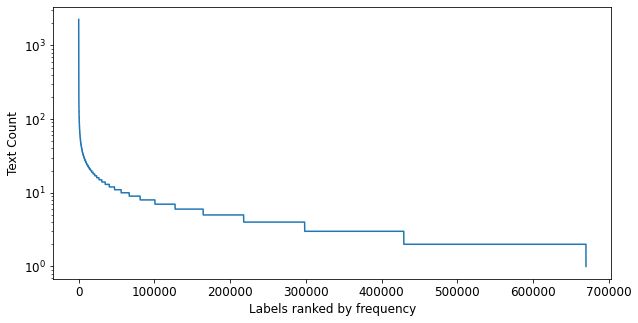

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Labels ranked by frequency')
ax.set_ylabel('Text Count')
ax.set_yscale('log');

#### Check #4: Computing the min label freq for each text

In [ ]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [ ]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

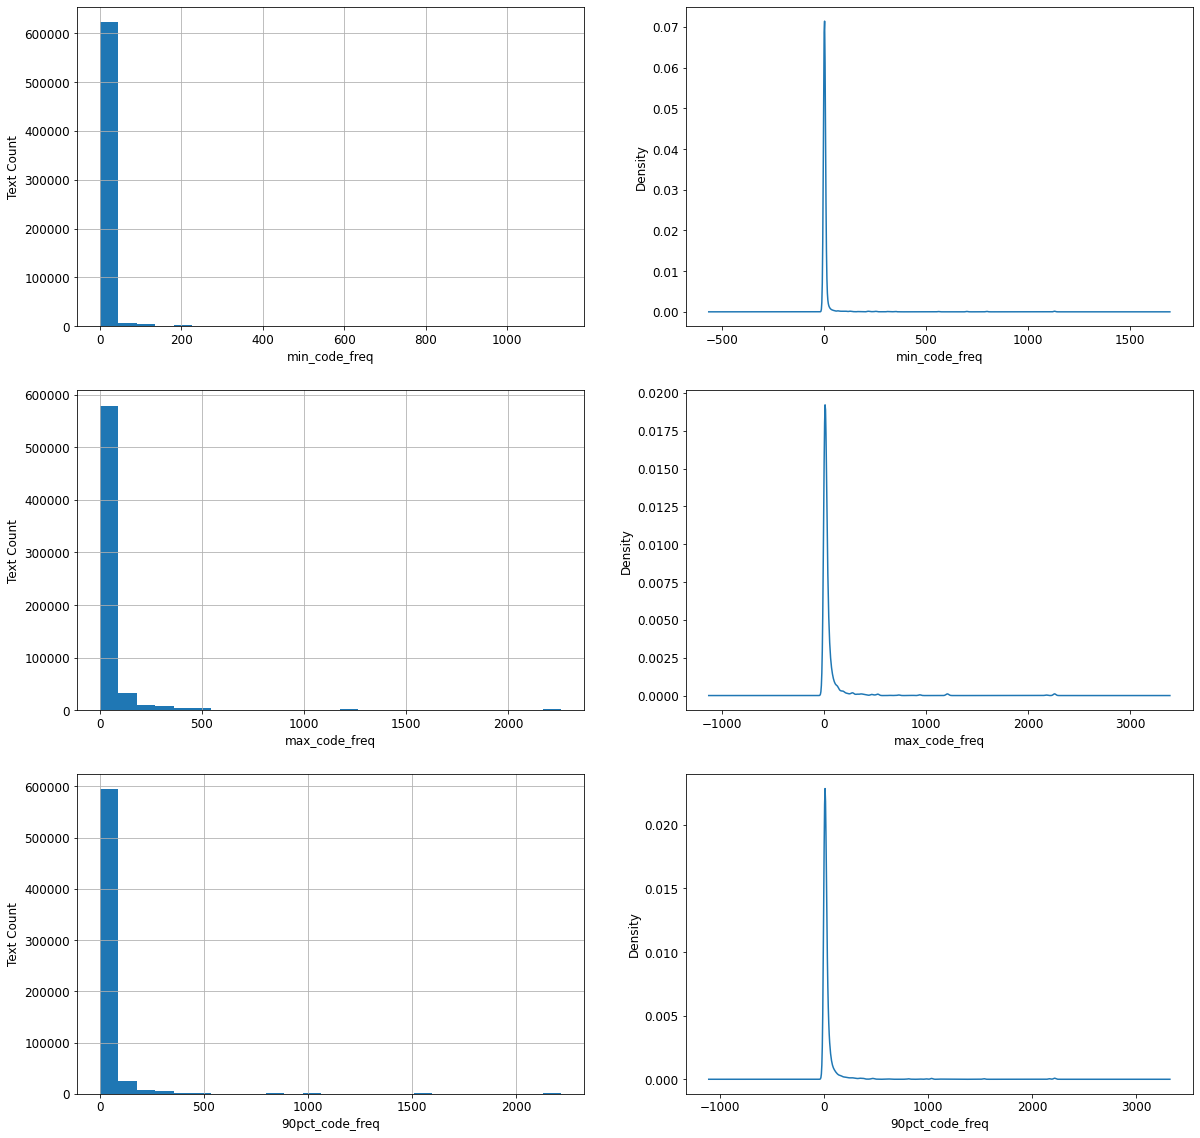

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [ ]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [ ]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [ ]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [ ]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

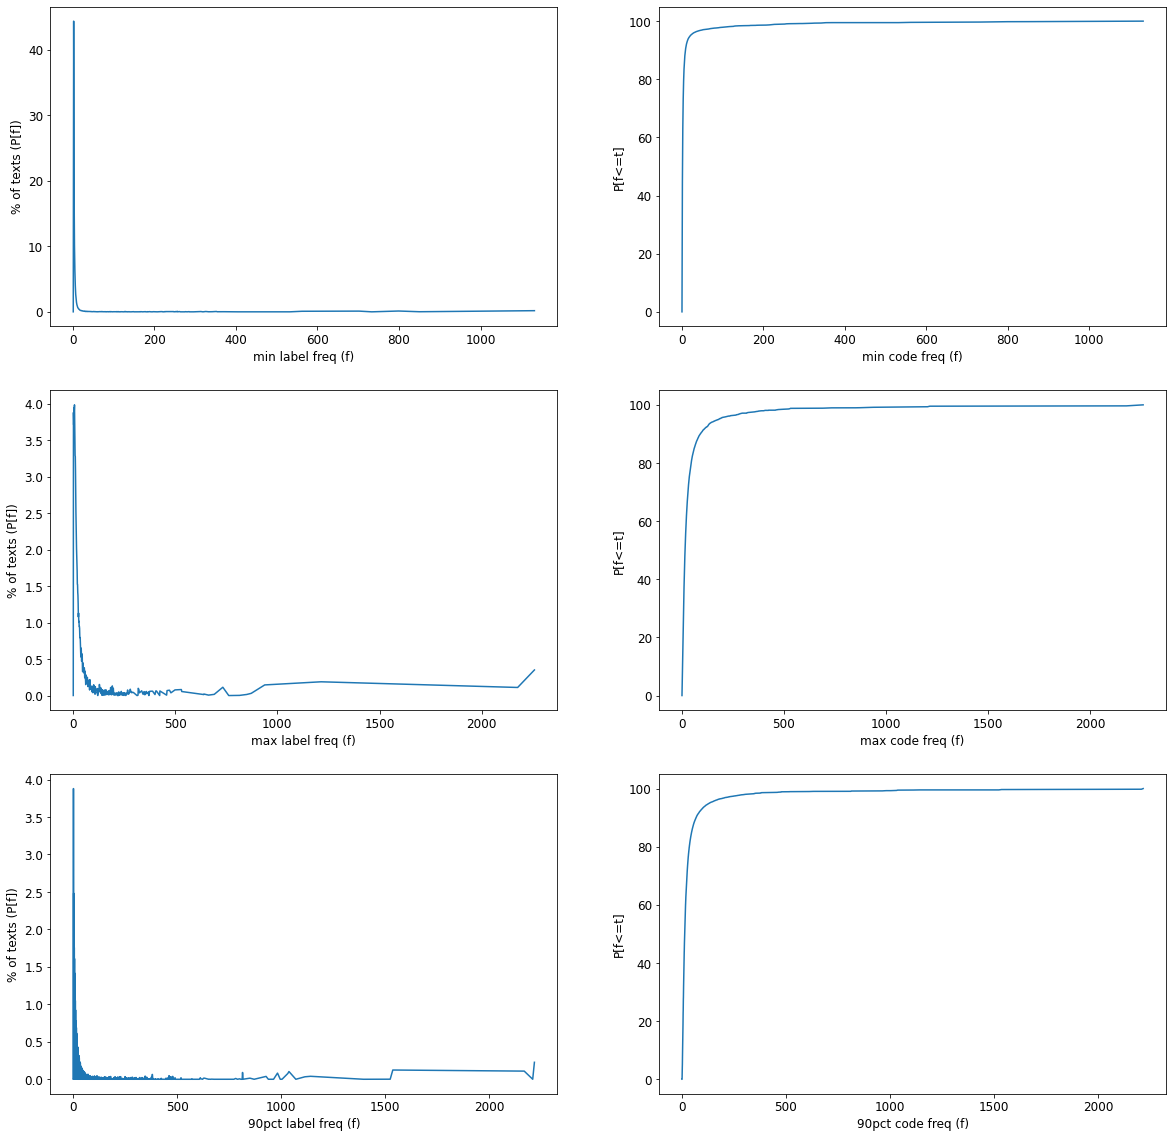

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#49354) [0,1,2,3,4,5,6,7,8,9...],
 (#3372) [1631,1632,1633,1634,1635,1636,1637,1638,1639,1640...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(dls_lm_vocab_path)
lm_vocab_r = torch.load(dls_lm_vocab_r_path)

In [ ]:
L(lm_vocab), L(lm_vocab_r)

((#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...],
 (#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...])

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [ ]:
dsets = Datasets(df, tfms, splits=splits)

In [ ]:
dsets_r = Datasets(df, tfms_r, splits=splits)

Let's now check if our `Datasets` got created alright:

In [ ]:
len(dsets.train), len(dsets.valid)

(244, 20)

Let's check a random data point:

In [ ]:
idx = random.randint(0, len(dsets))
x, x_r = dsets.train[idx], dsets_r.train[idx]

In [ ]:
dsets.decode(x)

('xxbos admission date discharge date date of birth sex f service neurology allergies patient recorded as having no known allergies to drugs attending last name namepattern1 chief complaint intraparenchymal hemorrhage major surgical or invasive procedure arrived intubated history of present illness ms known lastname is a year old right handed woman with a past medical history including tia memory loss and right retinal detachment who presents from hospital3 hospital with intraparenchymal hemorrhage the patient s family explains that ms known lastname was in her usual state of health on at about pm when her son in law stopped by to help administer some eye drops the family next returned at about pm and found the patient unresponsive and lying on the couch with her living doctor first name in slight disarray her son in law recalls tapping her and calling her name without appreciable response initially however he subsequently found that she was able to look straight at him and follow his 

In [ ]:
dsets.show(x)

xxbos admission date discharge date date of birth sex f service neurology allergies patient recorded as having no known allergies to drugs attending last name namepattern1 chief complaint intraparenchymal hemorrhage major surgical or invasive procedure arrived intubated history of present illness ms known lastname is a year old right handed woman with a past medical history including tia memory loss and right retinal detachment who presents from hospital3 hospital with intraparenchymal hemorrhage the patient s family explains that ms known lastname was in her usual state of health on at about pm when her son in law stopped by to help administer some eye drops the family next returned at about pm and found the patient unresponsive and lying on the couch with her living doctor first name in slight disarray her son in law recalls tapping her and calling her name without appreciable response initially however he subsequently found that she was able to look straight at him and follow his re

If we just want to decode the one-hot encoded dependent variable:

In [ ]:
_ind, _dep = x
_lbl = dsets.tfms[1].decode(_dep)

Let's extract the `MultiCategorize` transform applied by `dsets` on the dependent variable so that we can apply it ourselves:

In [ ]:
tfm_cat = dsets.tfms[1][1]
test_eq(str(tfm_cat.__class__), "<class 'fastai.data.transforms.MultiCategorize'>")

`vocab` attribute of the `MultiCategorize` transform stores the category vocabulary. If it was specified from outside (in this case it was) then the `MultiCategorize` transform will not sort the vocabulary otherwise it will.

In [ ]:
test_eq(lbls, tfm_cat.vocab)
test_ne(lbls, sorted(tfm_cat.vocab))

In [ ]:
test_eq(str(_lbl.__class__), "<class 'fastai.data.transforms.MultiCategory'>")
test_eq(tfm_cat(_lbl), TensorMultiCategory([lbls.index(o) for o in _lbl]))
test_eq(tfm_cat.decode(tfm_cat(_lbl)), _lbl)

Let's check the reverse:

In [ ]:
dsets_r.decode(x_r)

('by completed expired instructions followup expired instructions discharge expired condition discharge expired diagnosis discharge expired disposition discharge expired medications discharge folate abilify ppi proscar doxazosin klonopin depakote aricept lisinopril simvastatin aggrenox admission on medications resolved thrombocytopenia statin blocker beta continue negative ces resolved changes ecg intervene not will following neurosurgery shunt csf of site the at head the on mass xxunk sedation fentanyl and effect good with olanzapine dose low prn on now agitated zyprexa escitalopram xxunk on psych cva hemorrhagic pain pt spare to suctioning holding fentanyl with sedation increased on cmo to go to decided has family ventilated care mouth on yeast and flu h on sputum positive serratia for cipro continue on zosyn and vanc d c d intubated now sputum positive xxunk and serratia aspiration likely pneumonia autospy declined family on at pneumonia aspiration and stroke hemorrhagic failure res

In [ ]:
dsets_r.show(x_r)

by completed expired instructions followup expired instructions discharge expired condition discharge expired diagnosis discharge expired disposition discharge expired medications discharge folate abilify ppi proscar doxazosin klonopin depakote aricept lisinopril simvastatin aggrenox admission on medications resolved thrombocytopenia statin blocker beta continue negative ces resolved changes ecg intervene not will following neurosurgery shunt csf of site the at head the on mass xxunk sedation fentanyl and effect good with olanzapine dose low prn on now agitated zyprexa escitalopram xxunk on psych cva hemorrhagic pain pt spare to suctioning holding fentanyl with sedation increased on cmo to go to decided has family ventilated care mouth on yeast and flu h on sputum positive serratia for cipro continue on zosyn and vanc d c d intubated now sputum positive xxunk and serratia aspiration likely pneumonia autospy declined family on at pneumonia aspiration and stroke hemorrhagic failure respi

Looks fine!

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size:

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [ ]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [ ]:
torch.save(dls_clas, dls_clas_path)

In [ ]:
torch.save(dls_clas_r, dls_clas_r_path)

Let's take a look at the data:

In [ ]:
dls_clas.show_batch(max_n=5)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date date of birth sex m service cardiothoracic allergies codeine percocet sulfa sulfonamide antibiotics attending first name3 lf chief complaint dyspnea and coughing major surgical or invasive procedure right thoracotomy and intrathoracic tracheoplasty with mesh right mainstem bronchus and bronchus intermedius bronchoplasty with mesh left mainstem bronchus bronchoplasty with mesh bronchoscopy with bronchoalveolar lavage doctor last name flexible bronchoscopy doctor last name cricothyroidotomy doctor last name revision of tracheostomy tube to xl t shiley doctor last name flexible bronchoscopy with bronchoalveolar lavage doctor last name exploratory laparotomy with closure of perforated gastric ulcer with modified location un patch doctor last name left ij tunnelled hd catheter right basilic dl picc history of present illness 52 m with a history of diabetes kidney transplant in and pancreas transplant in colon cancer and tracheobronchomalacia status post y stent placement removed for excessive granulation tissue with a subsequent hospital,272.4;96.72;99.15;96.6;33.1;E878.8;276.2;34.91;998.59;785.52;995.92;530.81;585.6;39.95;038.9;486;276.69;33.24;276.0;31.1;996.81;38.95;707.03;38.97;519.19;933.1;434.11;V42.83;997.79;33.22;518.51;336.1;531.50;998.30;997.02;453.86;569.81;707.23;250.61;356.9;V45.11;31.79;31.74;33.48;44.41
1,xxbos admission date discharge date date of birth sex f service medicine allergies tetracyclines zinc attending first name3 lf chief complaint fall major surgical or invasive procedure none history of present illness year old f with xxunk s syndrome recurrent aspiration pna htn who presents s p fall she fell yesterday while trying to get up from bed and was put back to bed by her home health aid today she fell again and her aid dragged her to bed and called ems some head and l hip trauma no loc in the ed she received mso4 mg iv for pain her c spine was cleared head ct and hip films were negative fall was thought to be mechanical and social work was consulted re question of elder abuse neglect at midnight pt spiked to rectal received tylenol cxr and ua negative she was admitted for observation and placement of,507.0;518.81;401.9;96.71;96.04;38.91;99.04;584.9;428.0;585.9;V10.87;599.0;715.90;311;296.80;733.00;285.29;332.0;054.9;808.0;805.6;808.2;244.0;275.42;785.6;530.5;750.3;787.2;288.3;494.0;V55.1;V02.59;E885.9;97.02
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,518.81;272.4;530.81;584.9;403.91;410.71;588.81;428.23;428.0;39.95;414.01;V58.67;285.21;998.12;V45.82;37.22;88.56;V43.65;733.00;416.8;38.95;276.8;276.1;250.40;E879.8;276.50;288.60;274.9;276.3;493.90;88.53;564.00;724.2;414.8;997.2;414.04;447.0;442.3;585.5;716.96;V16.0;39.52;99.29;88.77
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxp

In [ ]:
dls_clas_r.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,by completed time date unit hemodialysis schedule dialysis nameis name10 provider time date phone md nameis name11 nameis name10 provider garage name ward hospital parking best west campus un location name unit hospital lm building fax telephone md namepattern1 name last namepattern1 name4 first with am at tuesday when center transplant department garage name ward hospital parking best west campus un location namepattern1 name last bldg name ward hospital lm building fax telephone md namepattern1 name last pattern1 name name11 first with am at monday when center transplant department xray chest a for center clinical name ward hospital the of un location the on department radiology the to appointment your to prior minutes report please garage name ward hospital parking best east campus un location ctr clinical name ward hospital sc building md md name8 md name6 with pm at thursday when oncology hematology department instructions followup coumadin on placed,272.4;96.72;99.15;96.6;33.1;E878.8;276.2;34.91;998.59;785.52;995.92;530.81;585.6;39.95;038.9;486;276.69;33.24;276.0;31.1;996.81;38.95;707.03;38.97;519.19;933.1;434.11;V42.83;997.79;33.22;518.51;336.1;531.50;998.30;997.02;453.86;569.81;707.23;250.61;356.9;V45.11;31.79;31.74;33.48;44.41
1,hospital the in done work lab of results the for up follow to and medication thyroid the also and levels calcium high the discuss to appointment an schedule to fax telephone call stitle name stitle name last dr endocrinologist your with appointment an make please time date fax telephone phone md namepattern4 name last pattern1 name name11 first provider time date fax telephone phone scc xray nameis name10 provider fax telephone call please call not does someone if appointment an make to you calling be should clinic their from someone diease parkinsons your of treatment regarding neurology with up follow please eosinophilia for and neck your in node lymph the up follow to days within stitle name last dr with up follow to appointment an make please instructions followup tube peg the thru given be should medications your all infections lung and aspiration of risk the avoid to mouth by,507.0;518.81;401.9;96.71;96.04;38.91;99.04;584.9;428.0;585.9;V10.87;599.0;715.90;311;296.80;733.00;285.29;332.0;054.9;808.0;805.6;808.2;244.0;275.42;785.6;530.5;750.3;787.2;288.3;494.0;V55.1;V02.59;E885.9;97.02
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,518.81;272.4;530.81;584.9;403.91;410.71;588.81;428.23;428.0;39.95;414.01;V58.67;285.21;998.12;V45.82;37.22;88.56;V43.65;733.00;416.8;38.95;276.8;276.1;250.40;E879.8;276.50;288.60;274.9;276.3;493.90;88.53;564.00;724.2;414.8;997.2;414.04;447.0;442.3;585.5;716.96;V16.0;39.52;99.29;88.77


#### 4. (Optional) Making the `DataLoaders` using fastai's `DataBlock` API:

It's worth mentioning here that all the steps we performed to create the `DataLoaders` can be packaged together using fastai's `DataBlock` API. 

In [ ]:
dblock = DataBlock(
        blocks = (TextBlock.from_df('text', seq_len=sl, vocab=lm_vocab), MultiCategoryBlock(vocab=lbls)),
        get_x = ColReader('text'),
        get_y = ColReader('labels', label_delim=';'),
        splitter = splitter,
        dl_type = dl_type,
)

In [ ]:
dls_clas = dblock.dataloaders(df, bs=bs, before_batch=pad_input_chunk)

In [ ]:
dls_clas.show_batch(max_n=5)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date date of birth sex m service cardiothoracic allergies codeine percocet sulfa sulfonamide antibiotics attending first name3 lf chief complaint dyspnea and coughing major surgical or invasive procedure right thoracotomy and intrathoracic tracheoplasty with mesh right mainstem bronchus and bronchus intermedius bronchoplasty with mesh left mainstem bronchus bronchoplasty with mesh bronchoscopy with bronchoalveolar lavage doctor last name flexible bronchoscopy doctor last name cricothyroidotomy doctor last name revision of tracheostomy tube to xl t shiley doctor last name flexible bronchoscopy with bronchoalveolar lavage doctor last name exploratory laparotomy with closure of perforated gastric ulcer with modified location un patch doctor last name left ij tunnelled hd catheter right basilic dl picc history of present illness 52 m with a history of diabetes kidney transplant in and pancreas transplant in colon cancer and tracheobronchomalacia status post y stent placement removed for excessive granulation tissue with a subsequent hospital,272.4;96.72;99.15;96.6;33.1;E878.8;276.2;34.91;998.59;785.52;995.92;530.81;585.6;39.95;038.9;486;276.69;33.24;276.0;31.1;996.81;38.95;707.03;38.97;519.19;933.1;434.11;V42.83;997.79;33.22;518.51;336.1;531.50;998.30;997.02;453.86;569.81;707.23;250.61;356.9;V45.11;31.79;31.74;33.48;44.41
1,xxbos admission date discharge date date of birth sex f service medicine allergies tetracyclines zinc attending first name3 lf chief complaint fall major surgical or invasive procedure none history of present illness year old f with xxunk s syndrome recurrent aspiration pna htn who presents s p fall she fell yesterday while trying to get up from bed and was put back to bed by her home health aid today she fell again and her aid dragged her to bed and called ems some head and l hip trauma no loc in the ed she received mso4 mg iv for pain her c spine was cleared head ct and hip films were negative fall was thought to be mechanical and social work was consulted re question of elder abuse neglect at midnight pt spiked to rectal received tylenol cxr and ua negative she was admitted for observation and placement of,507.0;518.81;401.9;96.71;96.04;38.91;99.04;584.9;428.0;585.9;V10.87;599.0;715.90;311;296.80;733.00;285.29;332.0;054.9;808.0;805.6;808.2;244.0;275.42;785.6;530.5;750.3;787.2;288.3;494.0;V55.1;V02.59;E885.9;97.02
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,518.81;272.4;530.81;584.9;403.91;410.71;588.81;428.23;428.0;39.95;414.01;V58.67;285.21;998.12;V45.82;37.22;88.56;V43.65;733.00;416.8;38.95;276.8;276.1;250.40;E879.8;276.50;288.60;274.9;276.3;493.90;88.53;564.00;724.2;414.8;997.2;414.04;447.0;442.3;585.5;716.96;V16.0;39.52;99.29;88.77
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxp

## `Learner` for Multi-Label Classifier Fine-Tuning 

In [ ]:
dls_clas = torch.load(dls_clas_path)

In [ ]:
# dls_clas_r = torch.load(dls_clas_r_path)

In [ ]:
# dls_clas.bs, dls_clas_r.bs

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, metrics=partial(PrecisionK, k=15)).to_fp16()

In [ ]:
# learn_r = text_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=72*40, metrics=partial(PrecisionK, k=15)).to_fp16()

In [ ]:
learn

<xcube.text.learner.TextLearner>

In [ ]:
import inspect
print(inspect.getsource(learn.model[-1].__class__))

class LabelAttentionClassifier3(Module):
    initrange=0.1
    def __init__(self, dims, ps, bptt, y_range=None):
        self.fts = dims[0]
        self.lbs = dims[-1]

        # ps = 0.1 # deb
        self.layers = LinBnDrop(self.lbs, ln=False, p=ps, act=None) # deb
        self.attn = XMLAttention(self.lbs, self.fts, 0.0)
        self.final_lin = nn.Linear(self.fts, self.lbs)
        init_default(self.final_lin,
                     func=partial(torch.nn.init.uniform_, a=-self.initrange, b=self.initrange))

    def forward(self, input):
        out, _ = input
        ctx = self.attn(out)
        x = self.layers(ctx)
        x = (self.final_lin.weight * ctx).sum(dim=2) + self.final_lin.bias

        return x, out, out



In [ ]:
print(inspect.getsource(learn.model[-1].attn.__class__))

class XMLAttention(Module):
    "Compute label specific attention weights for each token in a sequence"
    def __init__(self, n_lbs, emb_sz, embed_p):
         store_attr('n_lbs,emb_sz,embed_p')
         self.lbs_weight = nn.Embedding(n_lbs, emb_sz)
         self.lbs_weight_dp = EmbeddingDropout(self.lbs_weight, embed_p)
         self.lbs_weight.weight.data.normal_(0, 0.01)
         self.input_dp = RNNDropout(0.02)

    def forward(self, x):
        lbs_emb = self.lbs_weight(torch.arange(self.n_lbs, device=x.device))
        # x_dp = self.input_dp(x)
        attn_wgts = F.softmax(x @ lbs_emb.transpose(0,1), dim=1)
        return attn_wgts.transpose(1,2) @ x



In [ ]:
learn = learn.load_encoder(lm_finetuned_path.stem)

In [ ]:
# learn_r = learn_r.load_encoder(file_prefix+'_lm_finetuned_r')

## Fine-Tuning the Classifier 

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

(0.19054607152938843,
 0.04786301031708717,
 0.002511886414140463,
 0.033113110810518265)

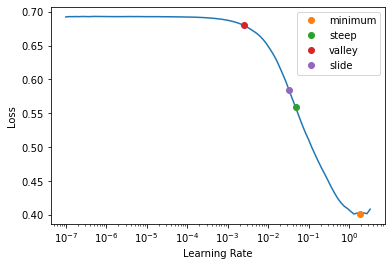

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(5, lr_max=.19054, moms=(0.8,0.7,0.8), wd=0.1, 
cbs=SaveModelCallback(monitor='PrecisionK', fname=clas_path.stem))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.250293,0.084821,0.246667,00:07
1,0.142467,0.082477,0.233333,00:07
2,0.104241,0.082958,0.206667,00:07
3,0.080617,0.075102,0.256667,00:07
4,0.062630,0.072749,0.276667,00:07


Better model found at epoch 0 with PrecisionK value: 0.24666666666666667.
Better model found at epoch 3 with PrecisionK value: 0.25666666666666665.
Better model found at epoch 4 with PrecisionK value: 0.27666666666666667.


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(monitor='PrecisionK', fname=clas_path.stem))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.024255,0.073974,0.286667,00:10
1,0.023397,0.074986,0.276667,00:10
2,0.022291,0.074796,0.276667,00:10
3,0.021420,0.075129,0.276667,00:10
4,0.020785,0.075177,0.276667,00:10


Better model found at epoch 0 with PrecisionK value: 0.2866666666666667.


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=clas_path.stem))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.022950,0.074382,0.276667,00:14
1,0.021983,0.075750,0.290000,00:13
2,0.020396,0.076928,0.290000,00:13
3,0.018906,0.078188,0.283333,00:13
4,0.017703,0.078922,0.280000,00:13
5,0.016831,0.079125,0.276667,00:13


Better model found at epoch 0 with PrecisionK value: 0.27666666666666667.
Better model found at epoch 1 with PrecisionK value: 0.2899999999999999.
Better model found at epoch 2 with PrecisionK value: 0.29000000000000004.


Finally, we will unfreeze the whole model and perform training:

In [ ]:
learn.unfreeze()

At this point, it starts overfitting too soon so either progressively increase `bs` or increase `wd` or decrease `lr_max`. Another way would be to drop out label embeddings, but for this one needs to carefully adjust the dropout prob. Same concept regarding dropping out the seqs nh.

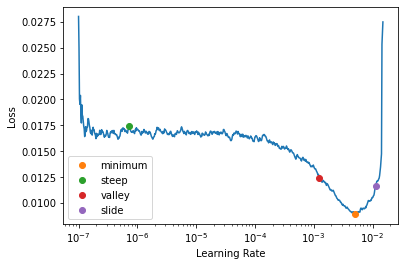

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum,steep,valley,slide), num_it=1000)

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide

(0.0005058246664702892,
 7.311390959330311e-07,
 0.0012473835377022624,
 0.0113762728869915)

In [ ]:
learn.fit_one_cycle(20, lr_max=5e-4, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=clas_path.stem))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.016525,0.076962,0.293333,00:18
1,0.016759,0.076968,0.280000,00:17
2,0.016465,0.077845,0.286667,00:17
3,0.016101,0.079386,0.276667,00:17
4,0.015550,0.080793,0.263333,00:18
5,0.015068,0.080437,0.266667,00:18
6,0.014425,0.082331,0.266667,00:18
7,0.013717,0.082479,0.270000,00:18
8,0.013054,0.083827,0.263333,00:17
9,0.012433,0.084383,0.260000,00:18


Better model found at epoch 0 with PrecisionK value: 0.29333333333333333.


To save the model:

In [ ]:
learn.save(clas_path.stem)

Path('models/mimic3-9k_clas.pth')

To load the model:

In [ ]:
learn = learn.load(clas_path.stem)
learn.validate()

(#2) [0.07696203887462616,0.29333333333333333]

---

In [ ]:
learn.save??

Signature: learn.save(file: str, with_opt=True, pickle_protocol=2)
Source:   
    @delegates(save_model)
    def save(self,
        file:str,
        **kwargs
    ):
        """
        Save model and optimizer state (if `with_opt`) to `self.path/self.model_dir/file`
        Save `self.dls.vocab` to `self.path/self.model_dir/clas_vocab.pkl`
        """
        file = join_path_file(file, self.path/self.model_dir, ext='.pth')
        vocab_file = join_path_file('clas_vocab', self.path/self.model_dir, ext='.pkl')
        save_model(file, self.model, getattr(self, 'opt', None), **kwargs)
        save_pickle(vocab_file, self.dls.classes)
        return file
File:      ~/xcube/nbs/examples/mimic/sample/xcube/text/learner.py
Type:      method


In [ ]:
L(learn.dls.vocab[0]), L(learn.dls.vocab[1])

((#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...],
 (#1271) ['431','507.0','518.81','112.0','287.4','401.9','427.89','600.00','272.4','300.4'...])

In [ ]:
learn.path

Path('.')

In [ ]:
fnames = [list(learn.path.glob(f'**/collab/*collab*.{ext}')) for ext in ['pth', 'pkl']
         ]

In [ ]:
fnames

[[Path('models/collab/mimic3-9k_collab.pth')],
 [Path('models/collab/mimic3-9k_collab_vocab.pkl')]]

In [ ]:
(path_model/'clas').mkdir(exist_ok=True)

In [ ]:
learn.save(str(Path('clas')/clas_path.stem))

Path('models/clas/mimic3-9k_clas.pth')

---

In [ ]:
fnames = [list(path.glob(f'**/*collab*.{ext}'))[0] for ext in ['pth', 'pkl']]
wgts_fname, colab_vocab_fname = fnames
collab_vocab = load_pickle(colab_vocab_fname)
lbs_vocab = learn.dls.vocab[1]
collab_lbs = collab_vocab['label']
test_shuffled(collab_lbs[1:], lbs_vocab)

In [ ]:
wgts = torch.load(wgts_fname, map_location=lambda storage,loc: storage)
if 'model' in wgts: wgts = wgts['model'] #Just in case the pretrained model was saved with an optimizer

In [ ]:
old_wgts = wgts.copy()

In [ ]:
new_wgts, missing = match_collab(wgts, collab_vocab, lbs_vocab)

In [ ]:
missing

0

In [ ]:
sd = learn.model[1].state_dict()

In [ ]:
learn.model[1]

LabelAttentionClassifier3(
  (layers): LinBnDrop(
    (0): BatchNorm1d(1271, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.04000000000000001, inplace=False)
  )
  (attn): XMLAttention(
    (lbs_emb): Embedding(1271, 400)
    (lbs_emb_dp): EmbeddingDropout(
      (emb): Embedding(1271, 400)
    )
    (input_dp): RNNDropout()
  )
  (final_lin): Linear(in_features=400, out_features=1271, bias=True)
)

In [ ]:
sd.keys()

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.0.running_mean', 'layers.0.running_var', 'layers.0.num_batches_tracked', 'attn.lbs_emb.weight', 'attn.lbs_emb_dp.emb.weight', 'final_lin.weight', 'final_lin.bias'])

In [ ]:
for k,v in sd.items():
    print(f"{k}: {v.shape}")

layers.0.weight: torch.Size([1271])
layers.0.bias: torch.Size([1271])
layers.0.running_mean: torch.Size([1271])
layers.0.running_var: torch.Size([1271])
layers.0.num_batches_tracked: torch.Size([])
attn.lbs_emb.weight: torch.Size([1271, 400])
attn.lbs_emb_dp.emb.weight: torch.Size([1271, 400])
final_lin.weight: torch.Size([1271, 400])
final_lin.bias: torch.Size([1271])


---

Or, validate manually (will be helpful to create an ensemble)

In [ ]:
# learn.get_preds??

In [ ]:
# learn.loss_func.activation??

In [ ]:
preds, targs = learn.get_preds()
preds.shape, targs.shape

(torch.Size([20, 1271]), torch.Size([20, 1271]))

In [ ]:
PrecisionK(preds, targs)

0.30333333333333334

To plot the train/valid loss and the metric over the course of training:

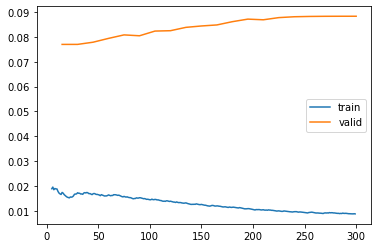

In [ ]:
learn.recorder.plot_loss()

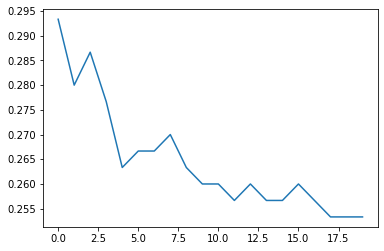

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

## Fine-Tuning the Backward Classifier

(5.754399353463669e-07,
 1.5848931980144698e-06,
 0.001737800776027143,
 0.02290867641568184)

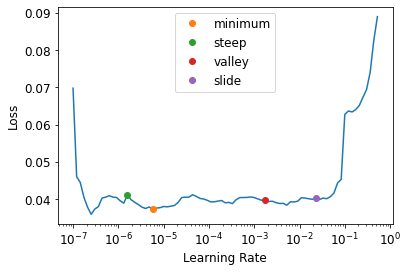

In [ ]:
lr_min_r, lr_steep, lr_valley, lr_slide = learn_r.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min_r, lr_steep, lr_valley, lr_slide

In [ ]:
learn_r.fit_one_cycle(2, lr_max=lr_min, moms=(0.8,0.7,0.8), wd=0.1, 
cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.197226,0.105101,0.196667,00:07
1,0.117636,0.080588,0.266667,00:06


Better model found at epoch 0 with PrecisionK value: 0.19666666666666666.
Better model found at epoch 1 with PrecisionK value: 0.26666666666666666.


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn_r.freeze_to(-2)

In [ ]:
learn_r.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.045407,0.077061,0.283333,00:09
1,0.044204,0.074392,0.293333,00:09
2,0.043082,0.074283,0.286667,00:09
3,0.042143,0.073841,0.293333,00:09
4,0.041429,0.073767,0.293333,00:09


Better model found at epoch 0 with PrecisionK value: 0.2833333333333333.
Better model found at epoch 1 with PrecisionK value: 0.29333333333333333.


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn_r.freeze_to(-3)

In [ ]:
learn_r.fit_one_cycle(4, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.041801,0.073660,0.280000,00:13
1,0.041004,0.073344,0.290000,00:12
2,0.039722,0.075154,0.283333,00:12
3,0.038737,0.075249,0.280000,00:12


Better model found at epoch 0 with PrecisionK value: 0.27999999999999997.
Better model found at epoch 1 with PrecisionK value: 0.29.


Finally, we will unfreeze the whole model and perform training:

In [ ]:
learn_r.unfreeze()

In [ ]:
learn_r.fit_one_cycle(20, lr_max=5.754399353463669e-07, moms=(0.8,0.7,0.8), wd=0.4,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.038804,0.073343,0.290000,00:16
1,0.038712,0.073343,0.290000,00:16
2,0.038781,0.073344,0.290000,00:16
3,0.038866,0.073346,0.290000,00:16
4,0.038851,0.073347,0.290000,00:16
5,0.038675,0.073350,0.290000,00:16
6,0.038704,0.073349,0.290000,00:16
7,0.038767,0.073351,0.290000,00:16
8,0.038854,0.073351,0.290000,00:16
9,0.038731,0.073353,0.290000,00:16


Better model found at epoch 0 with PrecisionK value: 0.29.


To save the model:

In [ ]:
learn_r.save(file_prefix+'_clas_r')

To load it back:

In [ ]:
learn_r = learn.load(file_prefix+'_clas_r')

To validate:

In [ ]:
learn_r.validate()

(#2) [0.09242013096809387,0.3066666666666667]

Or, validate manually:

In [ ]:
preds_r, targs = learn_r.get_preds()
preds_r.shape, targs.shape

(torch.Size([20, 1271]), torch.Size([20, 1271]))

In [ ]:
PrecisionK(preds_r, targs)

0.3066666666666667

## Ensemble (Fwd + Bwd):

In [ ]:
PrecisionK(preds, targs), PrecisionK(preds_r, targs)

(0.30333333333333334, 0.3066666666666667)

In [ ]:
PrecisionK((preds**2 + preds_r**2)/2.0, targs)

0.31333333333333335

In [ ]:
PrecisionK(torch.max(preds, preds_r), targs)

0.31333333333333335

In [ ]:
t1, t2 = torch.randn(3), torch.randn(3)
t1, t2

(tensor([-0.1385, -0.7201,  1.4714]), tensor([-0.5565,  1.0205, -0.2410]))

In [ ]:
torch.max(t1, t2)

tensor([-0.1385,  1.0205,  1.4714])

In [ ]:
preds, targs = learn.get_preds(act=torch.tanh)

In [ ]:
PrecisionK(preds, targs)

0.30333333333333334

In [ ]:
plot_function(torch.sigmoid)

TypeError: linspace() missing 1 required positional arguments: "steps"

In [ ]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, steps=100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

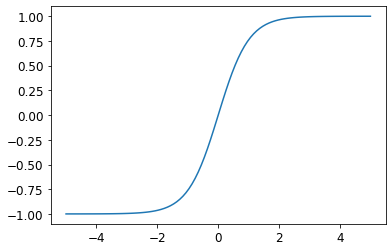

In [ ]:
plot_function(torch.tanh, min=-5, max=5)

## Plotting the Labels Embedding:

In [ ]:
decoder = learn.model[-1].attn
lbs_emb = decoder.lbs_emb.weight.data

In [ ]:
# torch.save(lbs_emb, 'embedding.pkl')

In [ ]:
lbs_emb = torch.load('embedding.pkl')
test_eq(lbs_emb.shape, (len(lbls), 400))

Now let's do a PCA and t-SNE on the labels embedding:

In [ ]:
X = to_np(lbs_emb)

Before doing PCA we need to standardize `X`:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_stand = StandardScaler().fit_transform(X)

/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


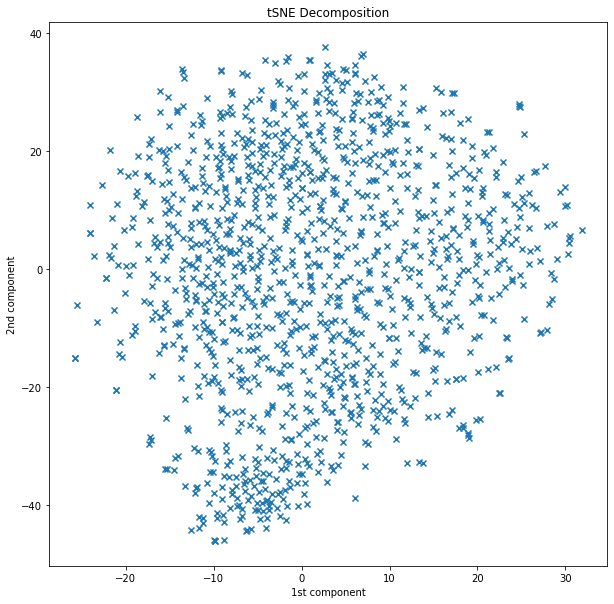

In [ ]:
X_red, _vars = plot_reduction(X, tSNE=True, figsize=(10,10))

In [ ]:
# X_red, _vars = plot_reduction(np.random.normal(size=(len(lbls), 400)), reduction="tSNE", n_comps=50, figsize=(10,10))

In [ ]:
# df = pd.read_csv(path.parent/'code_descriptions.csv')
# desc = dict([(row.ICD9_code, row.description)for row in df.itertuples()])

In [ ]:
# import pickle
# with open(path.parent/'code_desc.pkl', 'wb') as f:
#     pickle.dump(desc, f)

In [ ]:
with open(path.parent/'code_desc.pkl', 'rb') as f: desc = pickle.load(f)

In [ ]:
df_lbl = pd.DataFrame([(lbl, desc.get(lbl, "not found"), freq) for lbl, freq in lbl_freqs.items()], columns=['label', 'description', 'frequency'])
df_lbl = df_lbl.sort_values(by='frequency', ascending=False, ignore_index=True)
df_lbl.head(10)

,label,description,frequency
0,401.9,Unspecified essential hypertension,84
1,38.93,"Venous catheterization, not elsewhere classified",77
2,428.0,"Congestive heart failure, unspecified",61
3,272.4,Other and unspecified hyperlipidemia,60
4,427.31,Atrial fibrillation,56
5,414.01,Coronary atherosclerosis of native coronary artery,56
6,584.9,"Acute renal failure, unspecified",49
7,96.04,Insertion of endotracheal tube,48
8,250.00,"type II diabetes mellitus [non-insulin dependent type] [NIDDM type] [adult-onset type] or unspecified type, not stated as uncontrolled, without mention of complication",45
9,518.81,Acute respiratory failure,42


Instead of doing a PCA on all the labels, let's do it on the 100 most frequent labels:

In [ ]:
top = 500
top_lbs = [k for k, v in lbl_freqs.most_common(top)]

In [ ]:
top_lbs_emb = lbs_emb[tfm_cat(top_lbs)]

In [ ]:
topX = to_np(top_lbs_emb)

In [ ]:
topX.shape

(500, 400)

In [ ]:
topX_tsne = TSNE(n_components=2, perplexity=40).fit_transform(topX)

/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


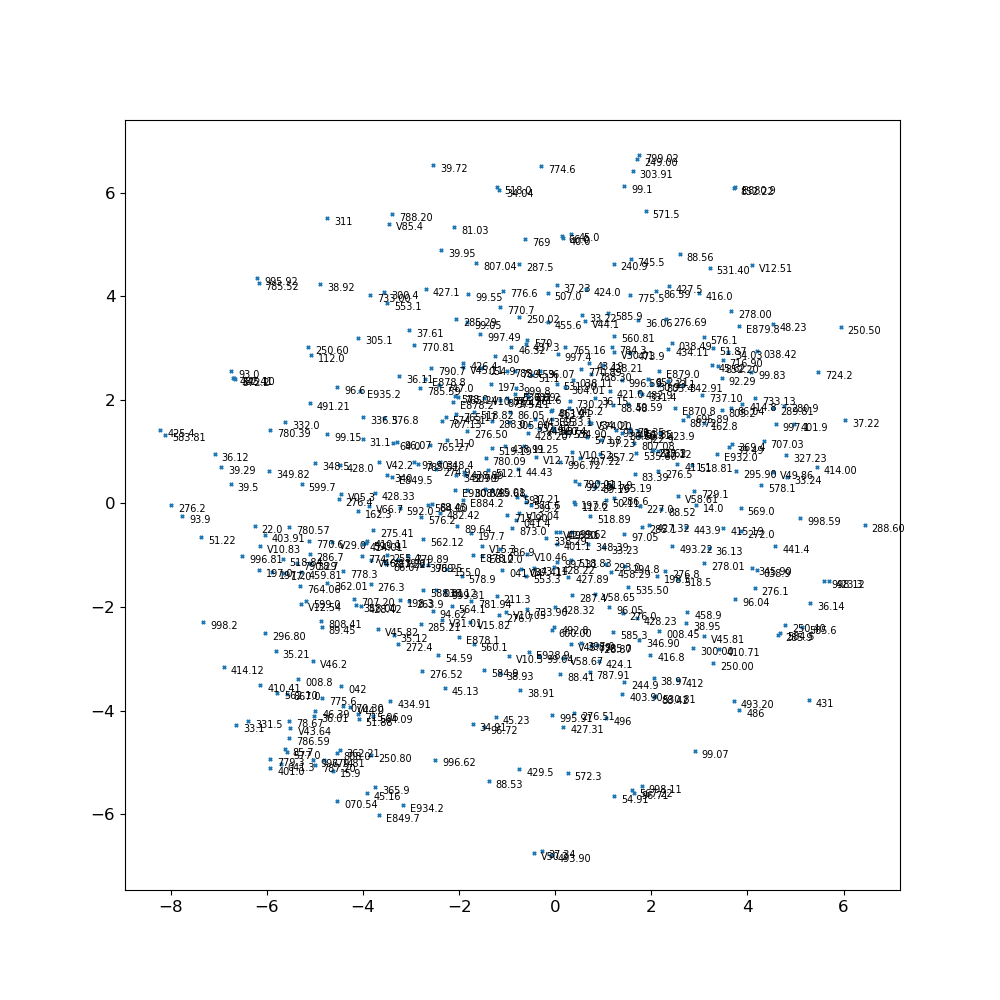

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(topX_tsne[:, 0], topX_tsne[:, 1], marker='x', s=5)
for lbl, x, y in zip(top_lbs, topX_tsne[:, 0], topX_tsne[:, 1]):
    plt.annotate(lbl,
                xy=(x,y),
                xytext=(5,-5),
                textcoords='offset points',
                size=7)
plt.show()

In [ ]:
tfm_cat(['36.12', '36.06'])

TensorMultiCategory([454, 683])

In [ ]:
df_lbl[df_lbl.label.isin(['54.91', '96.71', '567.22', '998.11'])]

,label,description,frequency
14,96.71,Continuous mechanical ventilation for less than 96 consecutive hours,33
54,54.91,Percutaneous abdominal drainage,14
91,998.11,Hemorrhage complicating a procedure,8
312,567.22,Peritoneal abscess,3


## Training a Collaborative Filtering Model to Learn the Label Embeddings

### Bootstrapping the Collab Model: (Attempt 1) 

We want to train a *collaborative filtering* model on the `lm_vocab`-`lbls` matrix, where each entry of the matrix is the number of times a particular token in the vocab has co-occurred in the dataset. The goal of this section is to create the matrix needed for collaborative filtering. We will store this matrix in a dataframe `df_lbl.pkl`:

In [ ]:
dsets = torch.load(dsets_clas_path)

In [ ]:
lm_vocab = torch.load(dls_lm_vocab_path)

Let find the number of tokens in this sampled dataset 

In [ ]:
vocab = set()
for x,_ in dsets:
    vocab.update(dsets.tfms[0][2].decode(x))
len(vocab)

12808

In [ ]:
lbls = dsets.vocab[1]

In [ ]:
L(vocab)

(#12808) ['effected','methimazole','fungal','oxaliplatin','designed','corrects','hypertonic','alprazolam','electrical','100'...]

In [ ]:
L(lbls)

(#1271) ['431','507.0','518.81','112.0','287.4','401.9','427.89','600.00','272.4','300.4'...]

The script `tf.py` computes the term frequencies in the training set:

In [ ]:
%less tf.py

import fastbook
fastbook.setup_book()

from fastbook import *
from multiprocessing import Pool
from tqdm import *

def count(tokens):
    vocab = Counter()
    vocab.update(tokens)
    return vocab

if __name__ == '__main__':

    start = time.time()
    dsets = torch.load('dsets.pkl')
    data_gen = (dsets.tfms[0][2].decode(x) for x,_ in dsets.train)

    with Pool(processes=8) as pool:
        max_ = len(dsets.train)
        final_vocab = Counter()
        with tqdm(total=max_) as pbar:
            for o in pool.imap(count, data_gen):
                final_vocab.update(o)
                pbar.update()
    torch.save(final_vocab, 'tf.pkl')
    print(f"time = {time.time() - start}")


In [ ]:
%run tf.py

At this point we have the term frequencies of the training set (in a `Counter` dictionary called `tf.pkl`), so let's load it up and plot the distribution:

In [ ]:
# tf is a term frequency dict
tf = torch.load('tf.pkl')

In [ ]:
len(tf)

12442

In [ ]:
tf.most_common(10)

[('the', 9675),
 ('and', 8314),
 ('to', 7021),
 ('of', 6985),
 ('was', 6820),
 ('with', 5134),
 ('a', 4809),
 ('on', 4383),
 ('in', 4055),
 ('mg', 3860)]

In [ ]:
freqs = list(tf.values())

In [ ]:
np.max(freqs), np.min(freqs), np.mean(freqs), np.median(freqs), np.std(freqs)

(9675, 1, 30.425494293521943, 3.0, 215.12023072242036)

Let's plot a histogram of the term frequencies:

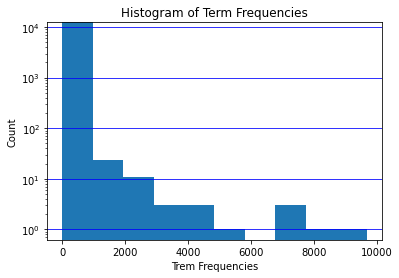

In [ ]:
n, bins, pathches = plt.hist(freqs)
plt.grid(axis='y', color='b')
plt.yscale('log')
plt.xlabel('Trem Frequencies')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.title('Histogram of Term Frequencies');

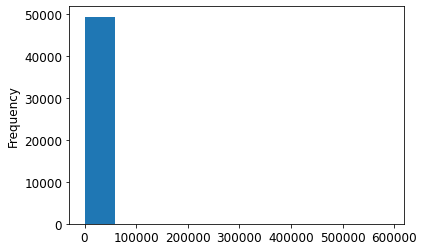

In [ ]:
pd.Series(freqs).plot.hist();

<AxesSubplot:ylabel='Density'>

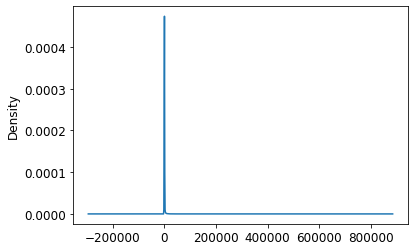

In [ ]:
pd.Series(freqs).plot.density()

In [ ]:
# plt.hist(x=freqs, bins=np.logspace(1,20, 1000))
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
np.logspace(np.log10(0.1),np.log10(1.0), 50)

array([0.1       , 0.10481131, 0.10985411, 0.11513954, 0.12067926, 0.12648552, 0.13257114, 0.13894955, 0.14563485, 0.1526418 , 0.15998587, 0.16768329, 0.17575106, 0.184207  , 0.19306977, 0.20235896,
       0.21209509, 0.22229965, 0.23299518, 0.24420531, 0.25595479, 0.26826958, 0.28117687, 0.29470517, 0.30888436, 0.32374575, 0.33932218, 0.35564803, 0.37275937, 0.39069399, 0.40949151, 0.42919343,
       0.44984327, 0.47148664, 0.49417134, 0.51794747, 0.54286754, 0.5689866 , 0.59636233, 0.62505519, 0.65512856, 0.68664885, 0.71968567, 0.75431201, 0.79060432, 0.82864277, 0.86851137, 0.91029818,
       0.95409548, 1.        ])

In [ ]:
np.log10(0.1), np.log10(1.0)

(-1.0, 0.0)

In [ ]:
np.logspace(0, 1, 50)

array([ 1.        ,  1.04811313,  1.09854114,  1.1513954 ,  1.20679264,  1.26485522,  1.32571137,  1.38949549,  1.45634848,  1.52641797,  1.59985872,  1.67683294,  1.75751062,  1.84206997,
        1.93069773,  2.02358965,  2.12095089,  2.22299648,  2.32995181,  2.44205309,  2.55954792,  2.6826958 ,  2.8117687 ,  2.9470517 ,  3.0888436 ,  3.23745754,  3.39322177,  3.55648031,
        3.72759372,  3.90693994,  4.09491506,  4.29193426,  4.49843267,  4.71486636,  4.94171336,  5.17947468,  5.42867544,  5.68986603,  5.96362332,  6.25055193,  6.55128557,  6.86648845,
        7.19685673,  7.54312006,  7.90604321,  8.28642773,  8.68511374,  9.10298178,  9.54095476, 10.        ])

Let's create a dataframe with three columns 'token', 'label', and the corresponding 'frequency':

In [ ]:
# df_lbl = pd.DataFrame(itertools.product(vocab, lbls), columns=['token', 'label'])
# df_lbl.to_feather(path/'df_lbl.pkl')

In [ ]:
df_lbl = pd.read_feather(path/'df_lbl.pkl')

In [ ]:
test_eq(len(df_lbl), len(vocab) * len(lbls))

In [ ]:
df_lbl.head()

,token,label
0,resusitation,431
1,resusitation,507.0
2,resusitation,518.81
3,resusitation,112.0
4,resusitation,287.4


Now to add the third column of 'frequency' we need to compute it from the training data. The script `toklbl.py` computes the frequencies of each token label pair and stores it in the file `tlfq.pkl` (for term-label-frequencies):

In [ ]:
%less toklbl.py

from fastbook import *
from multiprocessing import Pool
from tqdm import *

def count_star(args): return count(*args)

def count(tokens_, labels_):
    tlfq_ = Counter()
    tlfq_.update(itertools.product(tokens_, labels_))
    return tlfq_

def gen_():
    for x,y in dsets.train:
        tokens_ = dsets.tfms[0][2].decode(x)
        labels_ = dsets.tfms[1].decode(y)
        yield (tokens_, labels_)

if __name__ == '__main__':
    start = time.time()
    dsets = torch.load('dsets.pkl')
    data_gen = gen_()
    # data_gen = ((dsets.tfms[0][2].decode(x), dsets.tfms[1].decode(y)) for x, y in dsets.train)
    with Pool(processes=8) as pool:
        tlfq = Counter()
        with tqdm(total=len(dsets.train)) as pbar:
            for o in pool.imap_unordered(count_star, data_gen, chunksize=128):
                tlfq.update(o)
                pbar.update()
    torch.save(tlfq, 'tlfq.pkl')
    print(f"time = {time.time() - start}")


In [ ]:
%run 'toklbl.py'

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:07<00:00, 32.25it/s]


time = 9.418103218078613


In [ ]:
tlfq = torch.load('tlfq.pkl')
test_eq(type(Counter()), type(tlfq))

Note that not all token-label pair has been seen in the training data: 

In [ ]:
len(df_lbl), len(tlfq)

(16278968, 1502556)

In [ ]:
# tlfq.most_common(1000)[:-20:-1]

In [ ]:
df_lbl['frequency'] = df_lbl.apply(lambda row: tlfq.get((row.token, row.label), 0), axis=1)

In [ ]:
test_eq((df_lbl.frequency > 0).sum(), len(tlfq))

Let's save the `df_lbl` dataframe with this newly added frequency column:

In [ ]:
df_lbl.to_feather(path/'df_lbl.pkl')

### Bootstrapping the Collab Model: (Attempt 2) Finding a Needle in a Haystack with Mutual Infomation Gain

#### Mutual-Information Computation

In [66]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
df[['text', 'labels']] = df[['text', 'labels']].astype(str)
len(df)

52726

*Technical Point:* If we want to sample do perform quick iterations, we need to make sure the number of data points in the sample is a multiple of `bs`. So that we do not have to do a `drop_last=True` while creating the `Dataloaders`. This is because we are about to do some probability computations, and dropping data points is not a good idea as probabilities would not sum to 1.

In [ ]:
cut = len(df) - len(df)%8
df = df[:cut]
len(df)

52720

In [ ]:
bs = 8
_arr = np.arange(0, len(df), bs)
mask = (_arr > 4000) & (_arr < 5000)
_n = np.random.choice(_arr[mask], 1)
df = df.sample(n=_n, random_state=89, ignore_index=True)
len(df)

4824

In [ ]:
splits = ColSplitter()(df)
splits

((#244) [0,1,2,3,4,5,6,7,8,9...],
 (#20) [26,44,60,77,82,108,115,124,154,159...])

In [ ]:
lm_vocab = torch.load(dls_lm_vocab_path)

In [ ]:
@Transform
def Cleanser(toks): return [o for o in toks if o in lm_vocab]

In [ ]:
class MyNumericalize(Transform):
    "Transform to remove tokens not present in `vocab`"
    def __init__(self, vocab=None, min_freq=3, max_vocab=60000, special_toks=None):
        store_attr('vocab,min_freq,max_vocab,special_toks')
        self.o2i = None if vocab is None else defaultdict(int, {v: i for i,v in enumerate(vocab)})
    
    def setups(self, dsets):
        if dsets is None: return
        if self.vocab is None:
            count = dsets.counter if getattr(dsets, 'counter', None) is not None else Counter(p for o in dsets for p in o)
            if self.special_toks is None and hasattr(dsets, 'special_toks'):
                self.special_toks = dsets.special_toks
            self.vocab = make_vocab(count, min_freq=self.min_freq, max_vocab=self.max_vocab, special_toks=self.special_toks)
            self.o2i = defaultdict(int, {v:i for i,v in enumerate(self.vocab) if v != 'xxfake'})
    
    def encodes(self, o): return TensorText(tensor([self.o2i[o_] for o_ in o if o_ in self.vocab]))
    def decodes(self, o): return L(self.vocab[o_] for o_ in o)

In [ ]:
# resort to this if anythiong goes wrong below
x_tfms = [Tokenizer.from_df('text', n_workers=num_cpus()), attrgetter("text"), Cleanser, MultiCategorize(vocab=lm_vocab), OneHotEncode()]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [ ]:
class Chunkifize(Transform):
    order = 4
    def __init__(self, num_chunks=3): store_attr('num_chunks')
    def encodes(self, o): 
        return list(torch.chunk(o, self.num_chunks))
    def decodes(self, o): 
        return torch.cat(o)

In [ ]:
chnk_tfm = Chunkifize()
chnks = chnk_tfm(torch.arange(10))
test_eq(type(chnks), list)
test_eq(chnks, [tensor([0, 1, 2, 3]), tensor([4, 5, 6, 7]), tensor([8, 9])])
# test_fail(lambda: chnk_tfm.decode(chnks), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
test_eq(chnk_tfm.decode(chnks), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [ ]:
# y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(), OneHotEncode(), Chunkifize()]
# tfmd_y = TfmdLists(df, tfms=y_tfms)
# tfmd_y.decode(tfmd_y[0])

In [ ]:
x_tfms = [Tokenizer.from_df('text', n_workers=num_cpus()), attrgetter("text"), Numericalize(), OneHotEncode()]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [ ]:
dsets = Datasets(df, tfms=[x_tfms, y_tfms])

In [ ]:
torch.save(dsets, 'dsets.pkl')

In [ ]:
dsets = torch.load('dsets.pkl')
toks, lbs = dsets.vocab
L(toks), L(lbs), len(toks)*len(lbs)

((#57352) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...],
 (#8922) ['003.0','003.1','003.8','003.9','004.1','004.8','004.9','005.1','005.81','005.9'...],
 511694544)

In [ ]:
x, y = dsets[0]

In [ ]:
' '.join(L(toks)[torch.where(x==1)[0]])

'xxbos and to of was with a on in for no patient is name she discharge or as last history her right by admission date pain hospital first has ct medications hospital1 o well also given course after known service any medical past instructions exam md physical family allergies transferred condition then number procedure surgery surgical head chronic w further hypertension diagnosis non birth lf found social received sex bilateral followup name3 namepattern4 disposition lung back revealed severe attending mm complaint major invasive brief coumadin f chief significant multiple since intubated none completed medication down having made cancer name11 both scan very pattern1 drugs poor arrival requiring slightly recorded nc pupils unknown expired reactive knee eye considered le sedated withdrawal involving min toes shows bilat eval fell shortly stairs cane osteoarthritis ambulation prognosis cmo ue fixed recovered pupil metastasis flexion opening rt triple lobectomy extends corneal upgoing lt

In [ ]:
lbs.map_ids(torch.where(y==1)[0])

(#15) ['348.4','401.9','414.01','427.31','707.00','707.24','801.35','805.06','807.01','96.71'...]

In [ ]:
class BatchLbsChunkify(ItemTransform):
    order = 100
    def __init__(self, chnk_st, chnk_end): store_attr('chnk_st,chnk_end')
    def encodes(self, x): 
        return (x[0], x[1][:, self.chnk_st:self.chnk_end])

In [ ]:
bs, chnk_sz = 8, 200
dls = []
for chnk_st in range(0, len(lbs), chnk_sz):
    dls.append(TfmdDL(dsets, bs=bs, after_batch=[BatchLbsChunkify(chnk_st, min(chnk_st+chnk_sz, len(lbs)))], device=default_device()))
len(dls)

45

In [ ]:
# x, y = dsets[0]

In [ ]:
# test_eq(tensor(dsets.tfms[1][2].decode(y)), torch.where(y==1)[0])

In [ ]:
# test_eq(tensor(dsets.tfms[0][-1].decode(x)), torch.where(x==1)[0])

**[Mutual Information](https://en.wikipedia.org/wiki/Mutual_information#)**

<img alt="Pictorial representation of simple neural network" width="400" src="info-gain.svg" caption="Pictorial representation of a simple neural network" id="img_simple_nn">

In [ ]:
def mutual_info_gain(dl):
    """
    Computes [mutual information gain](https://en.wikipedia.org/wiki/Mutual_information) for each token label pair
    `dl` is (bag-of-words text, one-hot encoded targets)
    """
    xb, yb = dl.one_batch() 
    toksize, lblsize = xb.size(1), yb.size(1)
    p_TL = torch.zeros(toksize, lblsize, 4, dtype=torch.float, device=default_device())
    eps = p_TL.new_empty(1).fill_(1e-8)
    for x,y in dl:
        test_eq(x.shape, (dl.bs, toksize)); test_eq(y.shape, (dl.bs, lblsize))
        t = x.unsqueeze(-1).expand(-1, -1, lblsize) ; test_eq(t.shape, (dl.bs, toksize, lblsize))
        l = y.unsqueeze(1).expand(-1, toksize, -1) ; test_eq(l.shape, (dl.bs, toksize, lblsize))
        tl = torch.stack((t,l), dim=-1) ; test_eq(tl.shape, (dl.bs, toksize, lblsize, 2)) 
        p_TL_tt = tl[...,0].logical_and(tl[...,1]) ; test_eq(p_TL_tt.shape, (dl.bs, toksize, lblsize)) 
        p_TL_tf = tl[...,0].logical_and(tl[...,1].logical_not()) ; test_eq(p_TL_tf.shape, (dl.bs, toksize, lblsize)) 
        p_TL_ft = tl[...,0].logical_not().logical_and(tl[...,1]) ; test_eq(p_TL_ft.shape, (dl.bs, toksize, lblsize))
        p_TL_ff = tl[...,0].logical_not().logical_and(tl[...,1].logical_not()) ; test_eq(p_TL_ff.shape, (dl.bs, toksize, lblsize)) 
        p_TL = p_TL + torch.stack((p_TL_tt, p_TL_tf, p_TL_ft, p_TL_ff), dim=-1).float().sum(dim=0)
    p_TL = p_TL / tensor(len(dsets)).float()
    p_TL = p_TL.view(toksize, lblsize, 2, 2) ; test_eq(p_TL.shape, (toksize, lblsize, 2, 2))# last axis: lbl axis, 2nd last axis: token axis
    return p_TL

In [ ]:
%%time
p_TL_full = [] 
for dl in progress_bar(dls):
    p_TL = mutual_info_gain(dl)
    p_TL_full.append(p_TL)
    del p_TL; del p_T; del p_L; del p_TxL; del I_TL; torch.cuda.empty_cache()
p_TL_full = torch.cat(p_TL_full, dim=1); test_eq(p_TL_full.shape, (len(toks), len(lbs), 2, 2))
# torch.save(p_TL_full, 'p_TL.pkl')

CPU times: user 3h 10min 23s, sys: 3min 22s, total: 3h 13min 46s
Wall time: 3h 13min 58s


In [ ]:
def _compute(p_TL):
    eps = p_TL.new_empty(1).fill_(1e-15)
    toksize, lblsize = p_TL.size(0), p_TL.size(1)
    p_T = p_TL[:,0].sum(-1, keepdim=True); test_eq(p_T.shape, (toksize, 2, 1))# 0 because we can pick any label and apply total prob law
    p_L = p_TL[0,:].sum(-2, keepdim=True); test_eq(p_L.shape, (lblsize, 1, 2)) # 0 becuase we can pick any token and apply total prob law
    p_TxL = p_TL.sum(-1, keepdim=True) @ p_TL.sum(-2, keepdim=True); test_eq(p_TxL.shape, (toksize, lblsize, 2, 2))
    H_T = -(p_T * torch.log(p_T+eps)).sum(-2).squeeze(); test_eq(H_T.shape, [toksize])
    H_L = -(p_L * torch.log(p_L+eps)).sum(-1).squeeze(); test_eq(H_L.shape, [lblsize])
    I_TL = (p_TL * torch.log((p_TL + eps)/(p_TxL + eps))).flatten(start_dim=-2).sum(-1); test_eq(I_TL.shape, (toksize, lblsize))
    return p_T, p_L, p_TxL, H_T, H_L, I_TL

In [ ]:
%%time
p_TL = torch.load('p_TL.pkl')
p_T, p_L, p_TxL, H_T, H_L, I_TL = _compute(p_TL)
torch.save((p_T, p_L, p_TxL, H_T, H_L, I_TL), 'info.pkl')

CPU times: user 12.5 s, sys: 11.5 s, total: 24 s
Wall time: 30 s


In [ ]:
%%time 
p_TL = torch.load('p_TL.pkl')
p_T, p_L, p_TxL, H_T, H_L, I_TL = torch.load('info.pkl')

CPU times: user 8.61 s, sys: 3.62 s, total: 12.2 s
Wall time: 13.3 s


Make sure that aren't any of those pesky nans or negs:

In [ ]:
for o in (p_TL, p_T, p_L, p_TxL, H_T, H_L, I_TL):
    try:
        assert not o.isnan().all() # check for nans
        test_eq(torch.where(o>=0, True, False).all(), True) # check for negs
    except AssertionError:
        print(f"{namestr(o, globals())[0]} failed")

I_TL failed


Theoretically, Mutual-Info as defined [here](https://en.wikipedia.org/wiki/Mutual_information) is suposed to be non-negative (can be proved by tossing in [Jensen](https://en.wikipedia.org/wiki/Jensen%27s_inequality)). But, practically, it turns out `I_TL` has some negs because we distorted the `p_TL` and `p_TxL`  with `eps` in the `I_TL` computation.

In [ ]:
torch.topk(I_TL.flatten(), 10, largest=False)

torch.return_types.topk(
values=TensorMultiCategory([-1.9016e-07, -1.8314e-07, -1.8314e-07, -1.7385e-07, -1.7277e-07, -1.7277e-07, -1.6798e-07, -1.6798e-07, -1.6798e-07, -1.6767e-07], device='cuda:0'),
indices=TensorMultiCategory([22423614,  2731838,  2735913,  1911099,  6389159,  6393113,  6693073,  6695018,  6695355, 32253137], device='cuda:0'))

In [ ]:
howmany = torch.where(I_TL < 0, True, False).sum().item()
negs = torch.where(I_TL < 0, I_TL, I_TL.new_zeros(I_TL.shape))
negs.sum()/howmany

TensorMultiCategory(-3.9054e-08, device='cuda:0')

Those negs on an avg are pretty close to zero. So we need not worry. Let's roll!

In [ ]:
test_eq(p_TL.shape, (len(toks), len(lbs), 2, 2))
test_eq(p_T.shape, (len(toks), 2, 1))
test_eq(p_L.shape, (len(lbs), 1, 2))
test_eq(p_TxL.shape, (len(toks), len(lbs), 2, 2))
test_eq(H_T.shape, [len(toks)])
test_eq(H_L.shape, [len(lbs)])
test_eq(I_TL.shape, (len(toks), len(lbs)))

In [ ]:
# r_t, r_l = random.randrange(0, len(toks)), random.randrange(0, len(lbs))
# toks[r_t], lbs[r_l]

In [ ]:
# test_close(p_TL[r_t,r_l].sum(), 1, eps=1e-1)
# test_eq(p_T[r_t].sum(), 1)
# test_eq(p_L[r_l].sum(), 1)

In [ ]:
# p_TL[r_t,r_l].sum(-1), p_TL[r_t, 400].sum(-1) 

In [ ]:
# p_T[r_t], p_L[r_l]
# I_TL[r_t,r_l]

Let's save the `info`, we will use this bootstrap the collab model:

In [ ]:
eps = I_TL.new_empty(1).fill_(1e-15)
info_lbl_entropy = I_TL/(H_L + eps)
info_jaccard = I_TL/(H_T.unsqueeze(-1) + H_L.unsqueeze(0) - I_TL + eps)
assert not info_lbl_entropy.isnan().all(); assert not info_jaccard.isnan().all()
collab_bootstrap = {'toks': toks, 'lbs': lbs, 'mut_info_lbl_entropy': info_lbl_entropy, 'mutual_info_jaccard': info_jaccard}

In [ ]:
torch.save(collab_bootstrap, collab_bootst_path)
assert collab_bootst_path.exists()

#### Save those Mutual Information Gain values

Let's take a look at the *Mutual Information Gain* (`I_TL`) for each of the labels:

In [ ]:
f = ColReader('labels', label_delim=';')
lbs_frqs = Counter()
for o in df.itertuples(): lbs_frqs.update(f(o))
with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: lbs_desc = pickle.load(f)

In [ ]:
def _gen(toks, lbs, lbs_frqs, lbs_desc, p_TL, p_T, p_L, info, H_T, H_L, k=5):
    sorted_by_tok, tok_idxs = torch.sort(info, dim=0, descending=True) 
    for i,o in enumerate(lbs):
        topk_tok_idxs = tok_idxs[:k, i].cpu()
        topk_toks = toks[topk_tok_idxs]
        topk_toks_probs = p_T.squeeze()[:,0][topk_tok_idxs].cpu().numpy()
        topk_info_gains = sorted_by_tok[:k, i].cpu().numpy()
        topk_jnt_probs = p_TL[topk_tok_idxs, [i]][:,0,0].cpu().numpy()
        lbl_entropy = H_L[i].cpu().numpy()
        topk_tok_entrops = H_T[topk_tok_idxs].cpu().numpy()
        yield (o, lbs_frqs[o], p_L[i][0,0].cpu().numpy(), lbl_entropy, lbs_desc.get(o, 'Not Found'), 
               array(list(zip(topk_toks, topk_toks_probs, topk_tok_entrops, topk_jnt_probs, topk_info_gains))))

In [ ]:
def show_infogain(data, save_as=None):
    df = pd.DataFrame(data, columns=['label', 'freq', 'prob', 'entropy', 'description', 'top-k (token, prob, entropy, joint, info)'],)
    df[['prob', 'entropy',]] = df[['prob', 'entropy']].astype(np.float)
    df[['top-k (token, prob, entropy, joint, info)']] = df[['top-k (token, prob, entropy, joint, info)']].astype(np.str_) 
    if save_as is not None: df.to_feather(save_as)

In [ ]:
%%time
eps = I_TL.new_empty(1).fill_(1e-15)
# info = I_TL/H_L
info = I_TL/(H_T.unsqueeze(-1) + H_L.unsqueeze(0) - I_TL + eps)
_data = _gen(array(toks), lbs, lbs_frqs, lbs_desc, p_TL, p_T, p_L, info, H_T, H_L, k=10)
show_infogain(_data, save_as='mut_info_jaccard.ft')

CPU times: user 14.5 s, sys: 593 ms, total: 15.1 s
Wall time: 17.3 s


#### Let's look at those Mutual-Information Gain values:

In [ ]:
df_jc = pd.read_feather('mut_info_jaccard.ft')
df_le = pd.read_feather('mut_info_lbl_entropy.ft')

In [ ]:
# df_lbs.sort_values(by='freq', ascending=False).head(20)

In [ ]:
pd.options.display.max_colwidth = None
df_jc[df_jc.label == '032.9']

In [ ]:
mask = (df_le.freq>50) & (df_le.freq<150)
# with pd.option_context('display.max_colwidth', 100):
# pd.reset_option('all')
_df_jc = df_jc[mask].reset_index(drop=True)
_df_le = df_le[mask].reset_index(drop=True)
len(_df_jc), len(_df_le)

(822, 822)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
_df_jc.head()

,label,freq,prob,entropy,description,"top-k (token, prob, entropy, joint, info)"
0,008.8,132,0.002504,0.017498,"Intestinal infection due to other organism, not elsewhere classified",[['gastroenteritis' '0.008327011' '0.048164062' '0.0018778453' '0.135108']\n ['gasteroenteritis' '0.000113808805' '0.0011472754' '7.587254e-05' '0.020989483']\n ['viral' '0.06646434' '0.24439576' '0.002124431' '0.018479552']\n ['norovirus' '0.0006259484' '0.0052429195' '0.000113808805' '0.017389983']\n ['watery' '0.013770865' '0.07268653' '0.00056904403' '0.01273447']\n ['monobasic' '5.6904402e-05' '0.00061311224' '3.793627e-05' '0.010679064']\n ['profuse' '0.006866465' '0.041045412' '0.00026555388' '0.008544236']\n ['gestures' '0.0008345979' '0.0067503336' '7.587254e-05' '0.00845181']\n ['virally' '0.000113808805' '0.0011472754' '3.793627e-05' '0.008393114']\n ['ksb' '0.000113808805' '0.0011472754' '3.793627e-05' '0.008393114']]
1,038.12,116,0.002200,0.015662,Not Found,[['carbacephems' '0.0061836117' '0.037613403' '0.0006638847' '0.040515352']\n ['carbapenems' '0.0064491658' '0.038956657' '0.0006638847' '0.03890332']\n ['staphylococci' '0.0067336876' '0.04038363' '0.0006828528' '0.038864423']\n ['combinations' '0.006904401' '0.041234046' '0.0006638847' '0.036400057']\n ['consultations' '0.0042109257' '0.027236082' '0.00041729896' '0.029816346']\n ['rifampin' '0.013694993' '0.072362244' '0.00092943857' '0.029683795']\n ['lactamase' '0.010944613' '0.060298413' '0.0006638847' '0.022703482']\n ['protochol' '0.001972686' '0.014257325' '0.00018968133' '0.018664824']\n ['dysthesia' '9.484067e-05' '0.0009733652' '5.6904402e-05' '0.017445711']\n ['fungi' '0.0027883158' '0.019186173' '0.00020864948' '0.016050713']]
2,038.19,148,0.002807,0.019298,Other staphylococcal septicemia,[['epidermidis' '0.0024279212' '0.01704282' '0.00024658575' '0.0187256']\n ['coagulase' '0.02348255' '0.111299396' '0.0011001518' '0.018020378']\n ['coag' '0.04516313' '0.18401921' '0.0015174507' '0.014196403']\n ['staph' '0.06320182' '0.23568806' '0.0018778453' '0.013870501']\n ['staphylococcus' '0.041388467' '0.17233191' '0.0011191199' '0.0092715']\n ['staphlococcus' '0.0003414264' '0.003066752' '5.6904402e-05' '0.008194677']\n ['surveillance' '0.021509863' '0.103858486' '0.0006259484' '0.007927067']\n ['mrse' '0.0008156298' '0.006615689' '7.587254e-05' '0.0076404638']\n ['rvg' '0.00013277694' '0.0013180688' '3.793627e-05' '0.007032873']\n ['oxacillin' '0.028414264' '0.12918602' '0.00070182094' '0.0067001204']]
3,038.2,85,0.001612,0.011978,Pneumococcal septicemia [Streptococcus pneumoniae septicemia],[['pneumococcus' '0.0013277694' '0.010122354' '0.00030349015' '0.060944773']\n ['streptococcal' '0.0020675266' '0.014845582' '0.00030349015' '0.043650616']\n ['pneumo' '0.0066767833' '0.040099256' '0.0006259484' '0.041905276']\n ['pneumococcal' '0.008421851' '0.048616834' '0.0006828528' '0.03765242']\n ['pneumoniae' '0.013808802' '0.0728485' '0.00091047044' '0.03456903']\n ['breakpoints' '0.00036039454' '0.0032176247' '9.484067e-05' '0.027405556']\n ['asplenia' '0.00037936267' '0.0033675581' '7.587254e-05' '0.019955589']\n ['streptococcus' '0.018209409' '0.09098615' '0.0007397572' '0.018613825']\n ['mus' '5.6904402e-05' '0.00061311224' '3.793627e-05' '0.016812751']\n ['mucousa' '5.6904402e-05' '0.00061311224' '3.793627e-05' '0.016812751']]
4,038.3,108,0.002049,0.014728,Septicemia due to anaerobes,[['septicum' '0.00085356605' '0.006884547' '0.000113808805' '0.017611679']\n ['perfringens' '0.00142261' '0.010747153' '0.00013277694' '0.015447679']\n ['megacolon' '0.0030728378' '0.020844972' '0.00018968133' '0.013581591']\n ['bacteroides' '0.0023141124' '0.01635513' '0.00013277694' '0.010470199']\n ['ulitmately' '0.000113808805' '0.0011472754' '3.793627e-05' '0.010368616']\n ['pancolitis' '0.0023520486' '0.016584992' '0.00013277694' '0.010324825']\n ['klebisella' '0.00013277694' '0.0013180688' '3.793627e-05' '0.009809668']\n ['clostridial' '0.00013277694' '0.0013180688' '3.793627e-05' '0.009

In [ ]:
_df_le.head()

,label,freq,prob,entropy,description,"top-k (token, prob, entropy, joint, info)"
0,008.8,132,0.002504,0.017498,"Intestinal infection due to other organism, not elsewhere classified",[['gastroenteritis' '0.008327011' '0.048164062' '0.0018778453' '0.44664875']\n ['viral' '0.06646434' '0.24439576' '0.002124431' '0.2715633']\n ['diarrhea' '0.23753795' '0.5482253' '0.0020295903' '0.10494876']\n ['vomiting' '0.31278452' '0.62131053' '0.002143399' '0.09137799']\n ['nausea' '0.3579097' '0.652206' '0.0021054628' '0.07120143']\n ['watery' '0.013770865' '0.07268653' '0.00056904403' '0.064807415']\n ['medicine' '0.47397572' '0.691792' '0.0022382399' '0.056979857']\n ['sick' '0.049734447' '0.19773257' '0.0008156298' '0.054789137']\n ['emesis' '0.06274659' '0.23445892' '0.0008725342' '0.051838394']\n ['ns' '0.12010623' '0.3671366' '0.0011191199' '0.047479752']]
1,038.12,116,0.002200,0.015662,Not Found,[['mrsa' '0.09195752' '0.30704355' '0.0019347497' '0.24584907']\n ['bacteremia' '0.068304256' '0.24923033' '0.0014984825' '0.17290637']\n ['rifampin' '0.013694993' '0.072362244' '0.00092943857' '0.16202216']\n ['vancomycin' '0.2591047' '0.5721184' '0.0020864948' '0.15388577']\n ['aureus' '0.05064492' '0.20040981' '0.001270865' '0.15034734']\n ['staph' '0.06320182' '0.23568806' '0.0013467375' '0.14798154']\n ['vegetations' '0.032720033' '0.14407371' '0.0011001518' '0.14625418']\n ['staphylococci' '0.0067336876' '0.04038363' '0.0006828528' '0.13387245']\n ['carbacephems' '0.0061836117' '0.037613403' '0.0006638847' '0.13245058']\n ['carbapenems' '0.0064491658' '0.038956657' '0.0006638847' '0.1305896']]
2,038.19,148,0.002807,0.019298,Other staphylococcal septicemia,[['staph' '0.06320182' '0.23568806' '0.0018778453' '0.18076809']\n ['coag' '0.04516313' '0.18401921' '0.0015174507' '0.14747754']\n ['vancomycin' '0.2591047' '0.5721184' '0.0024658574' '0.124441765']\n ['coagulase' '0.02348255' '0.111299396' '0.0011001518' '0.11979452']\n ['grew' '0.11272762' '0.3521803' '0.0016312596' '0.09334226']\n ['staphylococcus' '0.041388467' '0.17233191' '0.0011191199' '0.09122223']\n ['cultures' '0.28729135' '0.59970856' '0.0023141124' '0.09089726']\n ['line' '0.30273142' '0.61316085' '0.002143399' '0.06575568']\n ['bacteremia' '0.068304256' '0.24923033' '0.0010811837' '0.060057342']\n ['sepsis' '0.18167679' '0.4739266' '0.0016502277' '0.059517227']]
3,038.2,85,0.001612,0.011978,Pneumococcal septicemia [Streptococcus pneumoniae septicemia],[['pneumoniae' '0.013808802' '0.0728485' '0.00091047044' '0.23663042']\n ['strep' '0.048691202' '0.19464338' '0.0010811837' '0.19061059']\n ['pneumococcal' '0.008421851' '0.048616834' '0.0006828528' '0.1835643']\n ['pneumo' '0.0066767833' '0.040099256' '0.0006259484' '0.174864']\n ['ceftriaxone' '0.122742794' '0.3723544' '0.001270865' '0.1572411']\n ['streptococcus' '0.018209409' '0.09098615' '0.0007397572' '0.15708087']\n ['sepsis' '0.18167679' '0.4739266' '0.0012329287' '0.10871605']\n ['pneumococcus' '0.0013277694' '0.010122354' '0.00030349015' '0.1059879']\n ['pneumonia' '0.29294384' '0.60476655' '0.0014036419' '0.09822925']\n ['vancomycin' '0.2591047' '0.5721184' '0.0013277694' '0.09428377']]
4,038.3,108,0.002049,0.014728,Septicemia due to anaerobes,[['sepsis' '0.18167679' '0.4739266' '0.0014036419' '0.084921986']\n ['septic' '0.06329666' '0.23594368' '0.00092943857' '0.08369133']\n ['diff' '0.08988999' '0.3022832' '0.0010432474' '0.08100143']\n ['colitis' '0.05694234' '0.21847004' '0.00085356605' '0.07671062']\n ['flagyl' '0.14711685' '0.4176752' '0.0012329287' '0.07597934']\n ['clostridium' '0.034427166' '0.14980963' '0.0006828528' '0.07129074']\n ['difficile' '0.050929442' '0.20124286' '0.0007397572' '0.06350024']\n ['metronidazole' '0.051915783' '0.20411795' '0.00064491655' '0.048172895']\n ['vancomycin' '0.2591047' '0.5721184' '0.0013277694' '0.046320684']\n ['shock' '0.06874052' '0.25036877' '0.0006638847' '0.039911266']]


In [ ]:
pd.reset_option('all')

In [ ]:
_df_jc.to_excel('jaccard.xls', index=False)
_df_le.to_excel('label-entropy.xls', index=False)

### Colab Model (Attempt #1)

In [ ]:
dsets = torch.load(dsets_clas_path)

In [ ]:
tfm_cat = dsets.tfms[1][1]
test_eq(str(tfm_cat.__class__), "<class 'fastai.data.transforms.MultiCategorize'>")

In [ ]:
df_lbl = pd.read_feather(path/'df_lbl.pkl')

In [ ]:
df_lbl.token.isnull().sum(), df_lbl.label.isnull().sum(), df_lbl.frequency.isnull().sum()

(0, 0, 0)

In [ ]:
df_lbl.token.nunique(), df_lbl.label.nunique()

(12808, 1271)

In [ ]:
df_lbl.head(5)

,token,label,frequency
0,resusitation,431,0
1,resusitation,507.0,0
2,resusitation,518.81,0
3,resusitation,112.0,0
4,resusitation,287.4,0


In [ ]:
df_lbl.frequency.min(), df_lbl.frequency.max()

(0, 2982)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
_f = array(df_lbl.frequency).reshape(-1, 1)
_f_tfm = MinMaxScaler(feature_range=(0,10)).fit_transform(_f).reshape(-1)
df_lbl.frequency = _f_tfm

In [ ]:
# with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: desc = pickle.load(f)

In [ ]:
df_lbl.pivot(index='token', columns='label', values='frequency')

label      008.45     008.8     038.0  038.11    038.12  038.2    038.42  \
token                                                                      
0        0.003353  0.006707  0.000000     0.0  0.000000    0.0  0.000000   
00am     0.030181  0.000000  0.000000     0.0  0.000000    0.0  0.036888   
00pm     0.003353  0.006707  0.006707     0.0  0.016767    0.0  0.013414   
01am     0.000000  0.000000  0.000000     0.0  0.000000    0.0  0.000000   
01pm     0.000000  0.000000  0.000000     0.0  0.000000    0.0  0.003353   
...           ...       ...       ...     ...       ...    ...       ...   
zosyn    0.013414  0.000000  0.000000     0.0  0.006707    0.0  0.006707   
zydis    0.000000  0.000000  0.000000     0.0  0.000000    0.0  0.000000   
zyprexa  0.000000  0.000000  0.000000     0.0  0.000000    0.0  0.000000   
zyrtec   0.000000  0.000000  0.000000     0.0  0.000000    0.0  0.000000   
zyvox    0.000000  0.000000  0.000000     0.0  0.000000    0.0  0.000000   

label      038.43    038.49     038.8     038.9    041.04     041.3     041.4  \
token                                                                           
0        0.000000  0.003353  0.003353  0.036888  0.006707  0.023474  0.000000   
00am     0.000000  0.006707  0.036888  0.020121  0.050302  0.050302  0.033535   
00pm     0.016767  0.000000  0.000000  0.033535  0.000000  0.000000  0.033535   
01am     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
01pm     0.000000  0.000000  0.000000  0.013414  0.000000  0.000000  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
zosyn    0.003353  0.006707  0.000000  0.033535  0.010060  0.003353  0.003353   
zydis    0.000000  0.006707  0.000000  0.000000  0.000000  0.000000  0.000000   
zyprexa  0.000000  0.000000  0.000000  0.006707  0.006707  0.000000  0.000000   
zyrtec   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
zyvox    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

label       041.6     041.7    041.85    041.89       042     054.9  070.20  \
token                                                                         
0        0.023474  0.023474  0.000000  0.000000  0.003353  0.010060     0.0   
00am     0.000000  0.000000  0.013414  0.006707  0.013414  0.000000     0.0   
00pm     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   
01am     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   
01pm     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   
...           ...       ...       ...       ...       ...       ...     ...   
zosyn    0.000000  0.000000  0.000000  0.000000  0.013414  0.013414     0.0   
zydis    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   
zyprexa  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   
zyrtec   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   
zyvox    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.0   

label      070.30    070.54    070.71     078.5  10.9      11.0     110.3  \
token                                                                       
0        0.000000  0.000000  0.000000  0.003353   0.0  0.000000  0.000000   
00am     0.026828  0.026828  0.000000  0.000000   0.0  0.000000  0.003353   
00pm     0.000000  0.010060  0.006707  0.000000   0.0  0.000000  0.016767   
01am     0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
01pm     0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
...           ...       ...       ...       ...   ...       ...       ...   
zosyn    0.003353  0.003353  0.000000  0.010060   0.0  0.003353  0.000000   
zydis    0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
zyprexa  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
zyrtec   0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
zyvox

We can now build the dataloaders objcet from this table, by defaultit takes the first column as the user (in our case the token) and the second column as the item (in our case the label), and the third column as the ratings (in our case the frequency):

In [ ]:
dls_collab = CollabDataLoaders.from_df(df_lbl, rating_name='frequency', bs=1024, device=default_device())

In [ ]:
torch.save(dls_collab, dls_collab_path)

In [ ]:
dls_collab = torch.load(dls_collab_path)

In [ ]:
dls_collab.show_batch()

,token,label,frequency
0,125,790.6,0.000000
1,subtotal,788.20,0.000000
2,95ra,46.1,0.000000
3,anuria,780.62,0.000000
4,coiled,775.5,0.000000
5,vt,43.11,0.000000
6,suffer,35.32,0.000000
7,work,E849.0,0.003353
8,18mcg,11.0,0.000000
9,uncertain,93.0,0.000000


In [ ]:
dls_collab.classes.keys()

dict_keys(['token', 'label'])

In [ ]:
type(dls_collab.classes['token'])

fastai.data.transforms.CategoryMap

In [ ]:
L(dls_collab.classes['token']), L(dls_collab.classes['label'])

((#12809) ['#na#','0','00am','00pm','01am','01pm','02am','02pm','02sat','03am'...],
 (#1272) ['#na#','008.45','008.8','038.0','038.11','038.12','038.2','038.42','038.43','038.49'...])

---

In [ ]:
dls_collab.classes['token'].map_objs(['traction', 'abandoned'])

(#2) [11811,557]

In [ ]:
dls_collab.classes['label'].map_objs(['801.25', '272.4'])

(#2) [909,129]

In [ ]:
dls_collab.classes['label'].map_ids([909, 129])

(#2) ['801.25','272.4']

---

In [ ]:
colab_lbl = dls_collab.classes['label']

In [ ]:
L(colab_lbl), type(colab_lbl)

((#1272) ['#na#','008.45','008.8','038.0','038.11','038.12','038.2','038.42','038.43','038.49'...],
 fastai.data.transforms.CategoryMap)

In [ ]:
decoder_lbl = dsets.vocab[1]

In [ ]:
lbs_emb = learn.model.i_weight.weight.data

In [ ]:
lbs_emb.shape

torch.Size([1272, 400])

In [ ]:
idxs = colab_lbl.map_objs(decoder_lbl.o2i)
idxs

(#1271) [434,542,564,30,171,364,414,706,129,200...]

In [ ]:
lbs_emb[idxs].shape

torch.Size([1271, 400])

---

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_tokens, n_labels, n_factors, y_range=(0, 10.5)):
        self.token_factors = Embedding(n_tokens, n_factors)
        self.token_bias = Embedding(n_tokens, 1)
        self.label_factors = Embedding(n_labels, n_factors)
        self.label_bias = Embedding(n_labels, 1)
        self.y_range = y_range
        
    def forward(self, xb):
        tokens = self.token_factors(xb[:, 0])
        labels = self.label_factors(xb[:, 1])
        res = (tokens * labels).sum(dim=1, keepdim=True)
        res += self.token_bias(xb[:, 0]) + self.label_bias(xb[:, 1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
n_tokens = len(dls_collab.classes['token'])
n_labels = len(dls_collab.classes['label'])
model = DotProductBias(n_tokens=n_tokens, n_labels=n_labels, n_factors=400)
learn = Learner(dls_collab, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(1, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.002991,0.002544,08:16


In [ ]:
learn_collab = collab_learner(dls_collab, n_factors=400, y_range=(0, 10.5), pretrained=True)

> /home/deb/xcube/nbs/examples/mimic/sample/xcube/collab.py(20)match_embeds()
     18     """
     19     import pdb; pdb.set_trace()
---> 20     u_bias, u_wgts = None, old_wgts.get('0.module.encoder.weight')
     21     print(f"{u_wgts.shape = }")
     22     i_bias, i_wgts = old_wgts.get('1.attn.lbs_bias.weight', None), old_wgts.get('1.attn.lbs_weight.weight')



ipdb>  c


u_wgts.shape = torch.Size([57376, 400])
i_wgts.shape = torch.Size([1271, 400])
new_u_wgts.shape = torch.Size([12809, 400])
new_i_wgts.shape = torch.Size([1272, 400])
inside load_keysu_wgts.shape = torch.Size([12809, 400])
inside loadi_wgts.shape = torch.Size([1272, 400])


In [ ]:
learn_collab.fit_one_cycle(1, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.002149,0.002383,01:14


In [ ]:
learn_collab.fit_one_cycle(1, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.002130,0.002238,01:15


In [ ]:
collab_path

Path('/home/deb/xcube/nbs/examples/mimic/sample/models/collab/mimic3-9k_collab.pth')

In [ ]:
learn_collab.save(str(Path('collab')/collab_path.stem))

'collab/mimic3-9k_collab'

In [ ]:
learn_collab = learn_collab.load(str(Path('collab')/collab_path.stem))

In [ ]:
learn_collab.validate()

(#1) [0.0023825899697840214]

---

Testing Transfer Learning in Collab

In [ ]:
learn_collab.model, learn_collab.path

(EmbeddingDotBias(
   (u_weight): Embedding(12809, 400)
   (i_weight): Embedding(1272, 400)
   (u_bias): Embedding(12809, 1)
   (i_bias): Embedding(1272, 1)
 ),
 Path('.'))

In [ ]:
fnames = [list(learn_collab.path.glob(f'**/clas/*clas*.{ext}'))[0] for ext in ['pth', 'pkl']]
wgts_fname, vocab_fname = fnames
old_vocab = load_pickle(vocab_fname)
new_vocab = learn_collab.dls.classes

In [ ]:
wgts_fname, vocab_fname

(Path('models/clas/mimic3-9k_clas.pth'),
 Path('models/clas/mimic3-9k_clas_vocab.pkl'))

In [ ]:
L(old_vocab[0]), L(old_vocab[1])

((#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...],
 (#1271) ['431','507.0','518.81','112.0','287.4','401.9','427.89','600.00','272.4','300.4'...])

In [ ]:
type(old_vocab), type(new_vocab)

(fastcore.foundation.L, dict)

In [ ]:
wgts = torch.load(wgts_fname, map_location=lambda storage,loc: storage)
if 'model' in wgts: wgts = wgts['model'] #Just in case the pretrained model was saved with an optimizer

In [ ]:
wgts.keys()

odict_keys(['0.module.encoder.weight', '0.module.encoder_dp.emb.weight', '0.module.rnns.0.weight_hh_l0_raw', '0.module.rnns.0.module.weight_ih_l0', '0.module.rnns.0.module.bias_ih_l0', '0.module.rnns.0.module.bias_hh_l0', '0.module.rnns.1.weight_hh_l0_raw', '0.module.rnns.1.module.weight_ih_l0', '0.module.rnns.1.module.bias_ih_l0', '0.module.rnns.1.module.bias_hh_l0', '0.module.rnns.2.weight_hh_l0_raw', '0.module.rnns.2.module.weight_ih_l0', '0.module.rnns.2.module.bias_ih_l0', '0.module.rnns.2.module.bias_hh_l0', '1.layers.0.weight', '1.layers.0.bias', '1.layers.0.running_mean', '1.layers.0.running_var', '1.layers.0.num_batches_tracked', '1.attn.lbs_weight.weight', '1.attn.lbs_weight_dp.emb.weight', '1.final_lin.weight', '1.final_lin.bias'])

In [ ]:
learn.model

SequentialRNN(
  (0): AttentiveSentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(57376, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(57376, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): LabelAttentionClassifier3(
    (layers): LinBnDrop(
      (0): BatchNorm1d(1271, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.04000000000000001, inplace=False)
    )
    (attn): XMLAttention(
      (lbs_weight): Embedding(1271, 400)
      (lbs_weight_dp): E

In [ ]:
len(new_vocab['token']), len(new_vocab['label'])

(12809, 1272)

---

In [ ]:
lbs_emb = learn_collab.model.i_weight.weight.data

In [ ]:
toks_emb = learn_collab.model.u_weight.weight.data

In [ ]:
torch.save(lbs_emb, "lbs_emb.pkl")

In [ ]:
X_lbs, X_toks = L(lbs_emb, toks_emb).map(to_np)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_lbs_std  = StandardScaler().fit_transform(X_lbs)
X_toks_std = StandardScaler().fit_transform(X_toks)

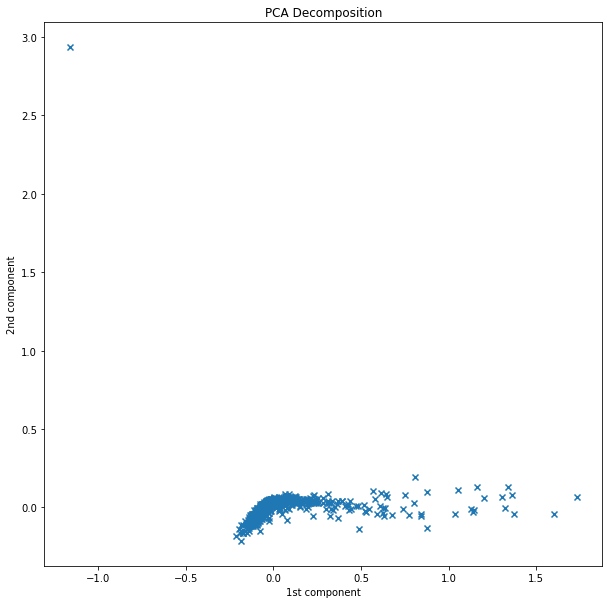

In [ ]:
X_red, _vars_l = plot_reduction(X_lbs, tSNE=False, figsize=(10,10))

In [ ]:
_vars_l[:5].sum()

0.8311015

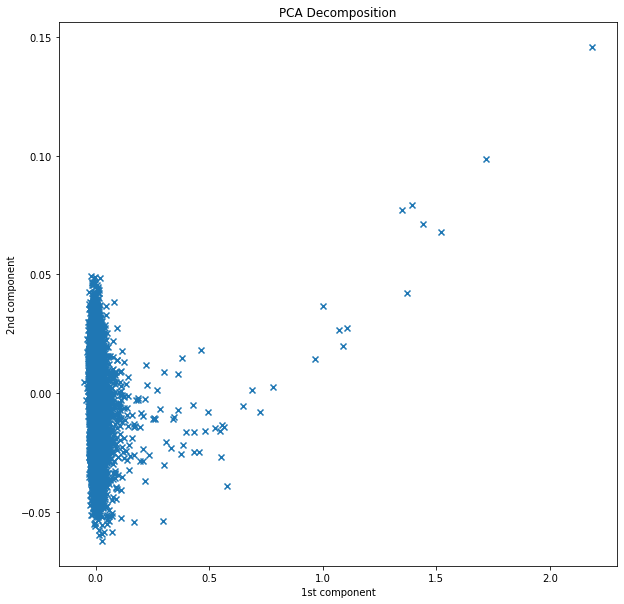

In [ ]:
X_red, _vars = plot_reduction(X_toks, tSNE=False, figsize=(10,10))

In [ ]:
_vars[:200].sum()

0.73215556

### Collab Model (Attempt #2)

#### Getting the collab data ready for fastai's `CollabDataLoaders`

In [ ]:
assert collab_bootst_path.exists()
collab_bootstrap = torch.load(collab_bootst_path)
test_eq(collab_bootstrap.keys(), ['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])
toks = collab_bootstrap.get('toks', None)
lbs = collab_bootstrap.get('lbs', None)
info = collab_bootstrap.get('mutual_info_jaccard', None)
for o in (toks, lbs, info): assert o is not None
test_eq(info.shape, (len(toks), len(lbs)))

Tossing in some pandas to get the data ready so that we can use fastai's collab `DataLoaders`:

*Note:* Storing the tokens and the labels in a dataframe as `object` will take up a lot of RAM space when we prepare that `DataLoader`. So we are going to store the corresponding token and label indices instead in a dataframe called `df_collab`. We are also going to store the tokens and the labels with their corresponding indices in seperate dataframes (this will help in quick merging for analysis).

---

In [ ]:
ranked = info.argsort(descending=True, dim=0).argsort(dim=0)

In [ ]:
info_ranked =torch.stack((info, ranked), dim=2).flatten(start_dim=1)

In [ ]:
cols = pd.MultiIndex.from_product([range(len(lbs)), ['mutual_info', 'rank']], names=['label', 'key2'])

In [ ]:
df_collab = pd.DataFrame(info_ranked, index=range(len(toks)), columns=cols)
df_collab.index.name='token'

In [ ]:
df_collab.head()

label        0                    1                    2              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000022    866.0    0.000011   1022.0    0.000022   1156.0   
1        0.000000  56854.0    0.000000  41418.0    0.000000  56853.0   
2        0.000000  56855.0    0.000000  41419.0    0.000000  56854.0   
3        0.000000  56856.0    0.000000  41420.0    0.000000  56855.0   
4        0.000000  56857.0    0.000000  41421.0    0.000000  56856.0   

label        3                    4                    5              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    823.0    0.000033    984.0    0.000011    643.0   
1        0.000000  41410.0    0.000000  22836.0    0.000000  41413.0   
2        0.000000  41411.0    0.000000  22837.0    0.000000  41414.0   
3        0.000000  41412.0    0.000000  22838.0    0.000000  41415.0   
4        0.000000  41413.0    0.000000  22839.0    0.000000  41416.0   

label        6                    7                    8              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    779.0    0.000011    793.0    0.000022   1005.0   
1        0.000000  41417.0    0.000000  41416.0    0.000000  56856.0   
2        0.000000  41418.0    0.000000  41417.0    0.000000  56857.0   
3        0.000000  41419.0    0.000000  41418.0    0.000000  56858.0   
4        0.000000  41420.0    0.000000  41419.0    0.000000  56859.0   

label        9                    10                   11             \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    819.0    0.000011    850.0    0.000065   1432.0   
1        0.000000  41417.0    0.000000  41422.0    0.000000  55902.0   
2        0.000000  41418.0    0.000000  41423.0    0.000000  55903.0   
3        0.000000  41419.0    0.000000  41424.0    0.000000  55904.0   
4        0.000000  41420.0    0.000000  41425.0    0.000000  55905.0   

label        12                   13                   14             \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    665.0    0.000011    634.0    0.000011    761.0   
1        0.000000  41409.0    0.000000  41409.0    0.000000  41409.0   
2        0.000000  41410.0    0.000000  41410.0    0.000000  41410.0   
3        0.000000  41411.0    0.000000  41411.0    0.000000  41411.0   
4        0.000000  41412.0    0.000000  41412.0    0.000000  41412.0   

label        15                   16                     17             \
key2  mutual_info     rank mutual_info     rank   mutual_info     rank   
token                                                                    
0        0.001175   1270.0    0.000011   1595.0  6.888287e-07  31864.0   
1        0.000000  56731.0    0.000000  41474.0  0.000000e+00  32418.0   
2        0.000000  56732.0    0.000000  41475.0  0.000000e+00  32419.0   
3        0.000000  56733.0    0.000000  41476.0  0.000000e+00  32420.0   
4        0.000000  56734.0    0.000000  41477.0  0.000000e+00  32421.0   

label        18                   19                   20             \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    979.0    0.000022    910.0    0.000065   1142.0   
1        0.000000  41419.0    0.000000  56852.0    0.000000  55896.0   
2        0.000000  41420.0    0.000000  56853.0    0.000000  55897.0   
3        0.000000  41421.0    0.000000  56854.0    0.000000  55898.0   
4        0.000000 

In [ ]:
# df_collab.loc[:, ( slice(0, len(lbs)), ['mutual_info'])] = info.cpu()
# df_collab.loc[:, ( slice(0, len(lbs)), ['rank'])] = info_ranked.cpu()

In [ ]:
df_collab = df_collab.stack(level=0).reset_index().rename_axis(None, axis=1)
df_collab[['token', 'label']] = df_collab[['token', 'label']].astype(np.int32) 

---

In [ ]:
df_collab = pd.DataFrame(info, columns=range(len(lbs)), index=range(len(toks)))
test_eq(len(df_collab), len(toks))
test_eq(len(df_collab.columns), len(lbs))
df_collab.index.name = 'token'
df_collab.columns.name = 'label'

In [ ]:
# with pd.option_context('display.max_columns', 50):
pd.set_option('display.max_columns', 50)
df_collab.head()
# pd.reset_option('all')

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,8897,8898,8899,8900,8901,8902,8903,8904,8905,8906,8907,8908,8909,8910,8911,8912,8913,8914,8915,8916,8917,8918,8919,8920,8921
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000022,0.000011,0.000022,0.000011,0.000033,0.000011,0.000011,0.000011,0.000022,0.000011,0.000011,0.000065,0.000011,0.000011,0.000011,0.001175,0.000011,6.888287e-07,0.000011,0.000022,0.000065,0.000185,0.000036,0.000109,0.000062,...,0.000094,0.000036,0.000112,0.000046,0.000114,0.000136,0.000135,0.000025,0.00012,0.000001,0.000022,0.000011,0.000011,0.000896,0.000011,0.000265,0.000011,0.000014,3.375316e-07,0.000011,0.000011,0.000033,0.000011,0.000011,6.888287e-07
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [ ]:
df_collab = df_collab.stack().reset_index(name='mutual_info')
test_eq(len(df_collab), len(toks)*len(lbs))
df_collab[['token', 'label']] = df_collab[['token', 'label']].astype(np.int32) 

---

In [ ]:
df_collab.head(3)

,token,label,mutual_info,rank
0,0,0,0.000022,866.0
1,0,1,0.000011,1022.0
2,0,2,0.000022,1156.0


In [ ]:
df_collab.memory_usage()/1024**3

Index          1.192093e-07
token          1.906211e+00
label          1.906211e+00
mutual_info    1.906211e+00
rank           1.906211e+00
dtype: float64

In [ ]:
df_toks = pd.DataFrame([(i, w) for i,w in enumerate(toks)], columns=['token', 'tok_val'])
df_lbs = pd.DataFrame([(i,w) for i, w in enumerate(lbs)], columns=['lbl', 'lbl_val'])

In [ ]:
df_toks.head(3)

,token,tok_val
0,0,xxunk
1,1,xxpad
2,2,xxbos


In [ ]:
df_lbs.head(3)

,lbl,lbl_val
0,0,003.0
1,1,003.1
2,2,003.8


Let us save this format, as this is what we will use to train our Collab Model

In [ ]:
df_collab.to_feather(collab_data_path)
df_toks.to_feather(collab_tok_path)
df_lbs.to_feather(collab_lbl_path)

#### Statistical Analysis of that `mutual_info` column before we build the collab `DataLoaders`

In [ ]:
# with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
#     args = (collab_data_path,)
#     kwargs = {}
#     df_collab = executor.submit(_read_collab, *args, **kwargs).result()

In [ ]:
assert collab_data_path.exists()
df_collab = pd.read_feather(collab_data_path)
test_eq(df_collab.dtypes.mutual_info, np.float32)

In [ ]:
# import gc; gc.collect()
# df_collab.info()
# ic(df_collab.memory_usage().sum()/1024**3)
# ic(sys.getsizeof(df_collab)/1024**3);

In [ ]:
df_collab.head(3)

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356


In [ ]:
# df_collab.token.nunique()

In [ ]:
mut_infos = df_collab['mutual_info'].to_numpy()

In [ ]:
mut_infos.min(), mut_infos.max(), mut_infos.mean()

(0.0, 0.99999636, 7.697003e-05)

In [ ]:
%%time
skew(mut_infos)

CPU times: user 1.74 s, sys: 1.01 s, total: 2.75 s
Wall time: 2.75 s


142.75660007849734

Before we attempt to transform `mut_infos` we need to convert any non-zeros in it to eps:

In [ ]:
# np.where(mut_infos<0, 1, 0).sum() # or, better yet
where_negs = mut_infos < 0
ic(np.sum(where_negs))

ic| np.sum(where_negs): 111226814


111226814

In [ ]:
eps = np.float32(1e-20)

In [ ]:
mut_infos[where_negs] = eps

In [ ]:
test_eq(np.sum(mut_infos<0), 0)

In [ ]:
np.min(mut_infos), np.max(mut_infos), np.mean(mut_infos)

(0.0, 0.99999636, 7.697003e-05)

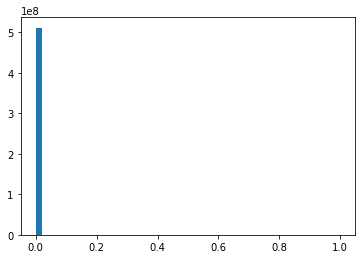

In [ ]:
hist, bins, _ = plt.hist(mut_infos, bins=50)
# plt.yscale('log')

**Applying log transform:**

In [ ]:
log_mut_infos = np.log(mut_infos + eps)

In [ ]:
np.isnan(log_mut_infos).sum(), np.isneginf(log_mut_infos).sum(), np.isinf(log_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(log_mut_infos)

CPU times: user 2.03 s, sys: 462 ms, total: 2.49 s
Wall time: 2.49 s


-1.3383214188674972

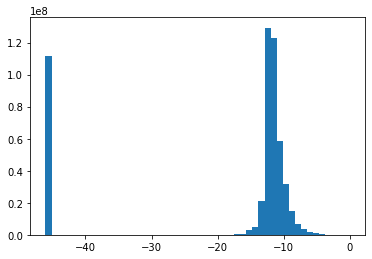

In [ ]:
hist, bins, _ = plt.hist(log_mut_infos, bins=50)

**Applying sqrt transform:**

In [ ]:
sqrt_mut_infos = np.sqrt(mut_infos)

In [ ]:
np.isnan(sqrt_mut_infos).sum(), np.isinf(sqrt_mut_infos).sum(), np.isneginf(sqrt_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(sqrt_mut_infos)

CPU times: user 1.6 s, sys: 1.04 s, total: 2.63 s
Wall time: 2.63 s


16.40865608826817

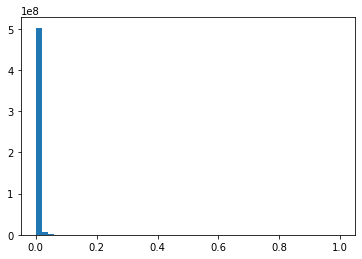

In [ ]:
hist, bins, _ = plt.hist(sqrt_mut_infos, bins=50)

**Apply box-cox transfrom:**

In [ ]:
bcx_mut_infos, *_ = boxcox(mut_infos+eps)

In [ ]:
np.isnan(bcx_mut_infos).sum(), np.isinf(bcx_mut_infos).sum(), np.isneginf(bcx_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(bcx_mut_infos)

CPU times: user 1.7 s, sys: 921 ms, total: 2.62 s
Wall time: 2.62 s


-0.885981418331696

In [ ]:
df_collab['bcx_mutual_info'] = bcx_mut_infos

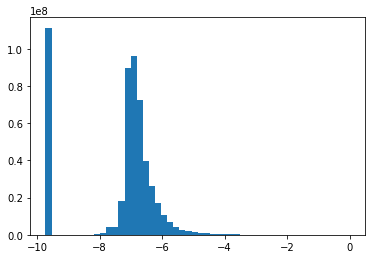

In [ ]:
hist, bins, _ = plt.hist(bcx_mut_infos, bins=50)

In [ ]:
np.min(bcx_mut_infos), np.max(bcx_mut_infos), np.mean(bcx_mut_infos), np.median(bcx_mut_infos)

(-9.734209, -3.6358892e-06, -7.381837, -6.9605794)

In [ ]:
df_collab.head(3)

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356


---

In [ ]:
import psutil
psutil.cpu_percent()

0.2

In [ ]:
psutil.virtual_memory()

svmem(total=63205289984, available=51459112960, percent=18.6, used=11144814592, free=45459292160, active=145227776, inactive=17213775872, buffers=49983488, cached=6551199744, shared=57344, slab=101920768)

In [ ]:
dict(psutil.virtual_memory()._asdict())

{'total': 63205289984,
 'available': 51458928640,
 'percent': 18.6,
 'used': 11144998912,
 'free': 45459050496,
 'active': 145195008,
 'inactive': 17213902848,
 'buffers': 50032640,
 'cached': 6551207936,
 'shared': 57344,
 'slab': 101941248}

In [ ]:
psutil.virtual_memory().percent

18.6

In [ ]:
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

81.41651284730541

In [30]:
import os
import psutil
pid = os.getpid()
python_process = psutil.Process(pid)
memoryUse = python_process.memory_info()[0]/2.**30  # memory use in GB...I think
print('memory use:', memoryUse)

memory use: 19.49184799194336


In [ ]:
from tqdm import tqdm
from time import sleep
import psutil

with tqdm(total=100, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
    while True:
        rambar.n=psutil.virtual_memory().percent
        cpubar.n=psutil.cpu_percent()
        rambar.refresh()
        cpubar.refresh()
        sleep(0.5)

---

In [ ]:
df_collab_high_ranked = df_collab[df_collab['rank'] <= 10].reset_index(drop=True)

In [ ]:
df_collab_high_ranked.head()

,token,label,mutual_info,rank
0,9,6109,0.008734,7.0
1,9,6111,0.008734,5.0
2,10,6461,0.027056,1.0
3,10,8030,0.034794,4.0
4,10,8696,0.034794,1.0


In [ ]:
df_collab_high_ranked['label'].nunique(), df_collab_high_ranked['token'].nunique()

(8922, 36909)

Box plots using matplotlib and seaborn

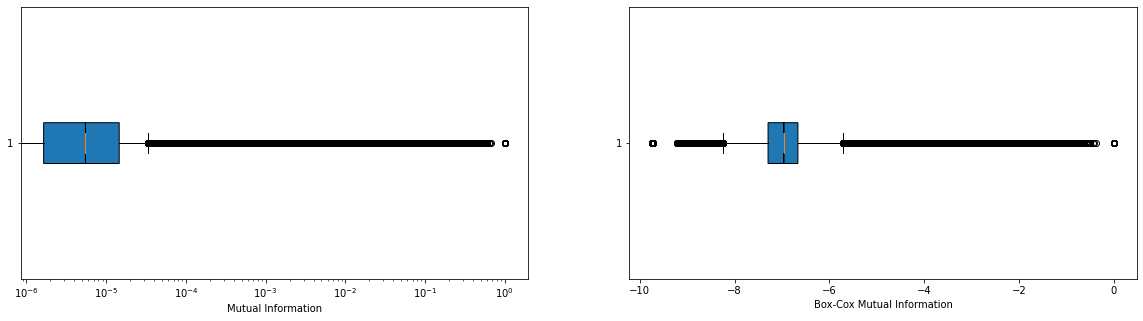

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(df_collab.mutual_info, vert=0, notch=True, patch_artist=True)
ax1.set_xscale('log')
ax1.set_xlabel('Mutual Information')

ax2.boxplot(df_collab.bcx_mutual_info, vert=0, notch=True, patch_artist=True)
# ax2.set_xscale('symlog')
ax2.set_xlabel('Box-Cox Mutual Information')

plt.show()

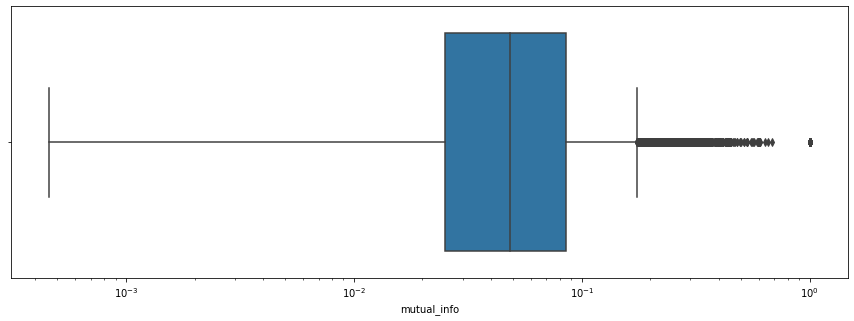

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.set_xscale('log')
sns.boxplot(x=df_collab_high_ranked['mutual_info'], ax=ax)
plt.show()

Histograms and kde using matplotlib:

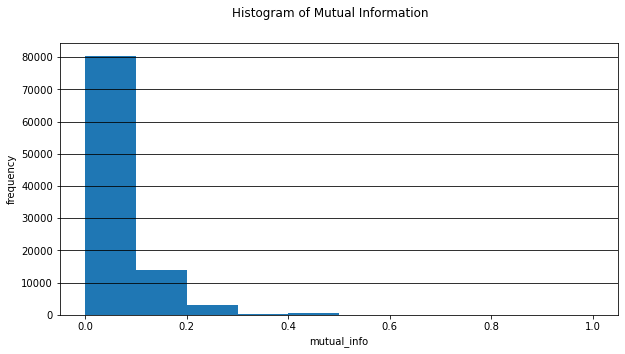

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2)

hist, bins, pathches = ax1.hist(df_collab_high_ranked['mutual_info'])
ax1.set_xlabel('mutual_info')
ax1.set_ylabel('frequency')
ax1.grid(axis='y', color='black')

# ax2.hist(df_collab['mutual_info'])
# ax2.set_xlabel('mutual_info')
# ax2.set_ylabel('frequency')
# ax2.grid(axis='y', color='black')
# ax2.set_yscale('log')

fig.suptitle('Histogram of Mutual Information')
plt.show()

In [ ]:
df_collab_high_ranked['mutual_info'].shape

(98142,)

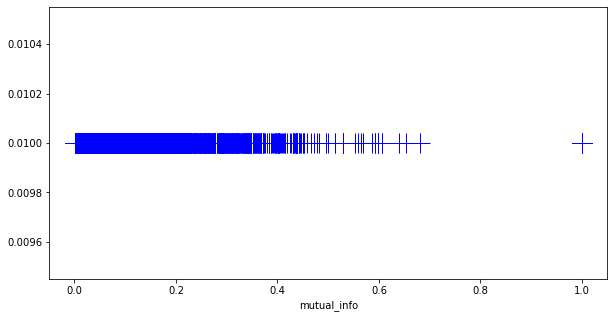

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_collab_high_ranked['mutual_info'], np.full_like(df_collab_high_ranked['mutual_info'], 0.01), 'b+', ms=20)
ax.set_xlabel('mutual_info')
plt.show()

In [ ]:
bdrs = [bins[i:i+2] for i in range(0, len(bins)-1)]
pd.DataFrame({'boundary': bdrs, 'counts': hist})

,boundary,counts
0,"[-6.852321e-05, 0.09993797]",511675593.0
1,"[0.09993797, 0.19994445]",14854.0
2,"[0.19994445, 0.29995096]",3323.0
3,"[0.29995096, 0.39995742]",191.0
4,"[0.39995742, 0.4999639]",454.0
5,"[0.4999639, 0.5999704]",30.0
6,"[0.5999704, 0.6999769]",5.0
7,"[0.6999769, 0.7999834]",0.0
8,"[0.7999834, 0.8999899]",0.0
9,"[0.8999899, 0.99999636]",94.0


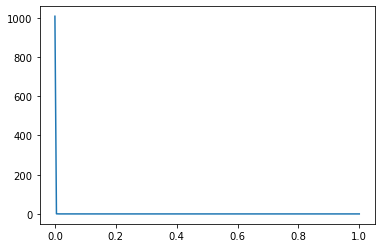

In [ ]:
from scipy.stats import gaussian_kde
density = gaussian_kde(df_collab['mutual_info'])
xs = np.linspace(0, 1, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs, density(xs))
plt.show()

Histograms and kde using pandas

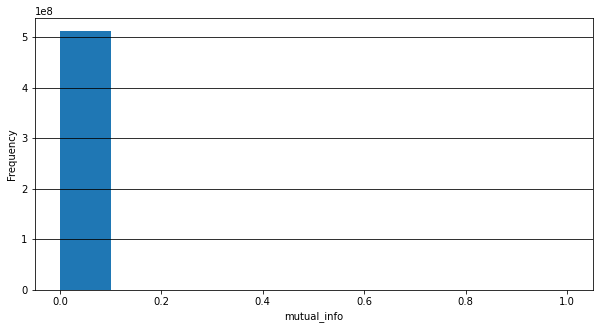

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
df_collab['mutual_info'].plot.hist(ax=ax)
ax.set_xlabel('mutual_info')
ax.grid(axis='y', color='black')
plt.show()

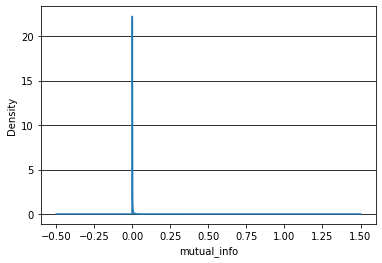

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
df_collab['mutual_info'].plot.kde(ax=ax)
ax.set_xlabel('mutual_info')
ax.grid(axis='y', color='black')
plt.show()

---

In [ ]:
from scipy.special import erf
SQRT_TWO_PI = math.sqrt(2*math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (np.exp(-(x-mu)**2/2/sigma**2))/(SQRT_TWO_PI*sigma)

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + erf((x-mu)/np.sqrt(2)/sigma))/2

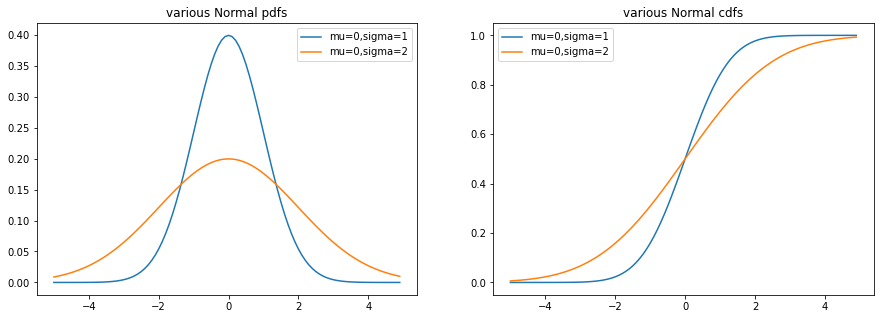

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
xs = np.arange(-5, 5, step=0.1)
ax1.plot(xs, normal_pdf(xs, sigma=1), label='mu=0,sigma=1')
ax1.plot(xs, normal_pdf(xs, sigma=2), label='mu=0,sigma=2')
ax1.legend()
ax1.set_title("various Normal pdfs")

ax2.plot(xs, normal_cdf(xs, sigma=1), label='mu=0,sigma=1')
ax2.plot(xs, normal_cdf(xs, sigma=2), label='mu=0,sigma=2')
ax2.legend()
ax2.set_title("various Normal cdfs")

plt.show()

In [ ]:
def my_hist(data, y_scale=None, x_label=None, y_label=None, title="Histogram"):
    n, bins, pathches = plt.hist(data)
    plt.grid(axis='y', color='b')
    if y_scale is not None: plt.yscale(y_scale)
    if x_label is not None: plt.xlabel(x_label)
    if y_label is not None: plt.ylabel(y_label)
    maxfreq = n.max()
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.title(title);

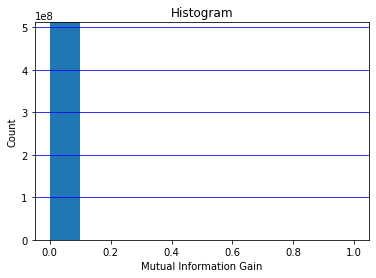

In [ ]:
my_hist(mut_infos, x_label="Mutual Information Gain", y_label="Count")

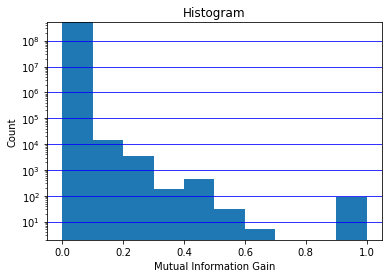

In [ ]:
my_hist(mut_infos, y_scale='log', x_label="Mutual Information Gain", y_label="Count")

In [ ]:
np.log(mut_infos)

array([-10.735371 , -11.4250345, -10.735371 , ...,        -inf,        -inf,        -inf], dtype=float32)

In [ ]:
eps = np.float32(1e-20)
my_hist(np.log(mut_infos), x_label="Mutual Information Gain", y_label="Count")

In [ ]:
from scipy.stats import gaussian_kde

density = gaussian_kde(-np.log(mut_infos+eps))
xs = np.linspace(0, 1, 20)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs, density(xs))
plt.show()

Histograms:

In [ ]:
grades = [83, 95, 91, 87, 70, 0, 85, 82, 100, 67, 73, 77, 0, 99]
len(grades)

14

In [ ]:
def _hist(data, start, end, n_bins):
    # import pdb; pdb.set_trace()
    bins, step = np.linspace(start, end, n_bins+1, retstep=True)
    hist = Counter(np.minimum(data//step*step, bins[-2]))
    xs = array(list(hist.keys())) + step/2
    ys = array(list(hist.values()))
    plt.bar(xs,
           hist.values(),
           step,
           edgecolor=(0,0,0))
    plt.axis([start, end, 0, max(hist.values())])

    plt.grid(axis='y', color='black')
    plt.xticks(ticks=bins, rotation=90)
    plt.xlabel(f"{int(step)}%-ile")
    plt.ylabel("# of Students")
    plt.title("Distribution of Exam 1 grades")
    plt.show()

In [ ]:
grades = np.random.randint(0, 100, 50)
min(grades), max(grades)

(3, 98)

In [ ]:
_hist(mut_infos, 0, 1, 10)

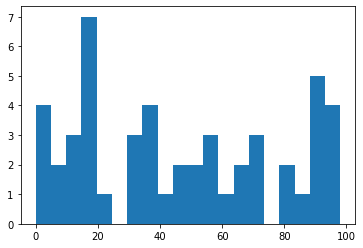

In [ ]:
hist, bins, _ = plt.hist(grades, bins=20)

In [ ]:
assert (np.logspace(2, 5, 5) == np.power(10.0, np.linspace(2,5,5))).all()

Log scale:

In [ ]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
diamonds.apply(lambda x: x.nunique())

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

In [ ]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


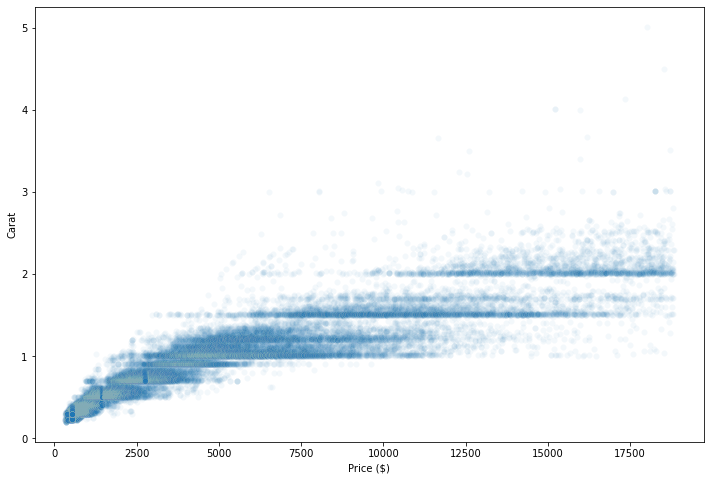

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
plt.show();

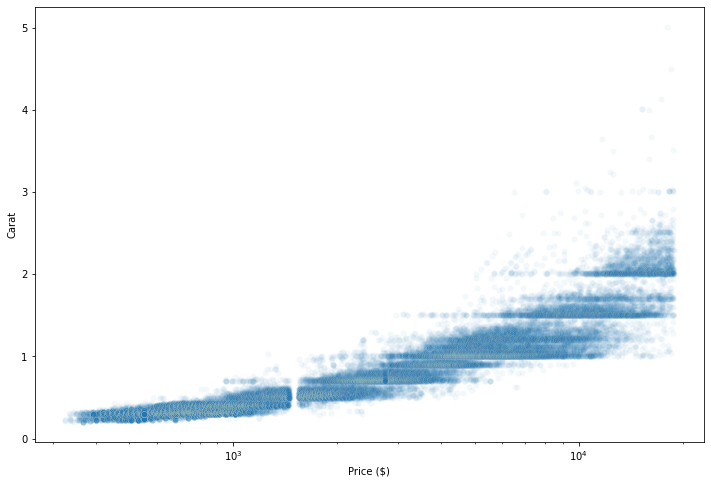

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
ax.set_xscale('log') # added
plt.show();

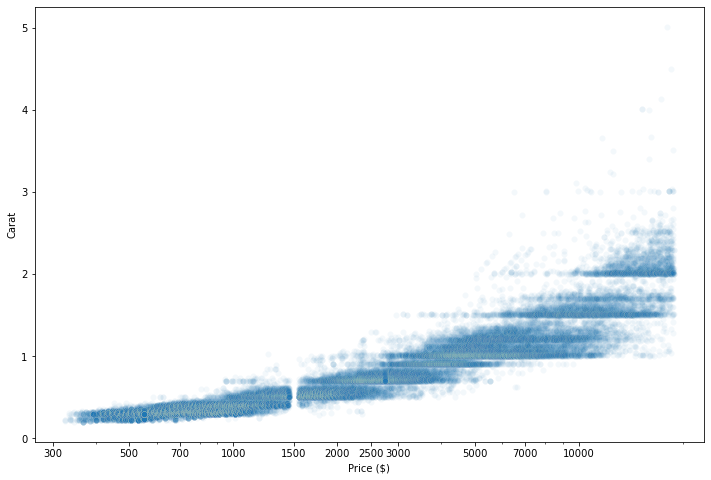

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
ax.set_xscale('log') 
ax.set_xticks([300, 500, 700, 1000, 1500, 2000, 2500, 3000, 5000, 7000, 10000]) # added
ax.set_xticklabels([300, 500, 700, 1000, 1500, 2000, 2500, 3000, 5000, 7000, 10000]) # added
plt.show();

In [ ]:
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)

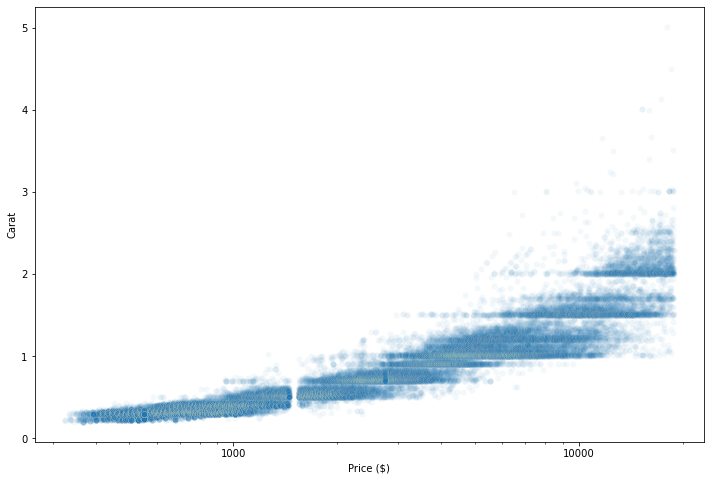

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
ax.set_xscale('log') 
for axis in (ax.xaxis, ax.yaxis): axis.set_major_formatter(formatter)
plt.show();

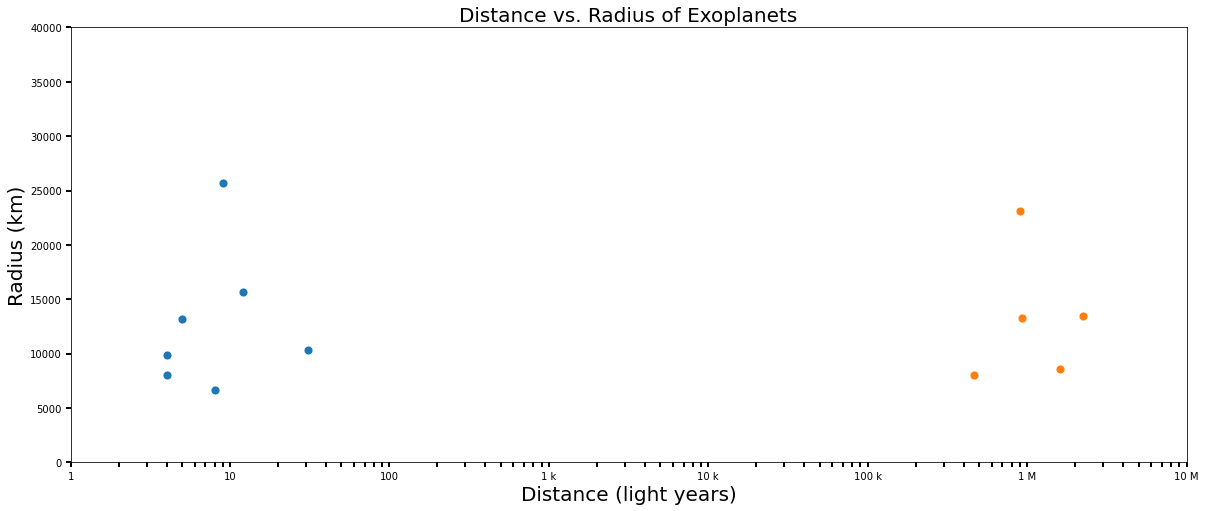

In [ ]:
import matplotlib.ticker as ticker

# Extremely far exoplanets
extremes = [465413, 2231451, 897931, 931312, 1612312]
radius_extreme = [7986, 13456, 23144, 13254, 8562]

# Nearer exoplanets
exo_distance = [5, 4, 4, 8, 9, 12, 31]
exo_radius = [13165, 7985, 9847, 6654, 25647, 15644, 10312]

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=exo_distance, y=exo_radius, s=80)
sns.scatterplot(x=extremes, y=radius_extreme, s=80)

ax.axis([1, 10000000, 0, 40000])

ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.EngFormatter())

ax.tick_params(bottom=True, which='both', width=2, length=5, labelsize=10)

ax.set_title('Distance vs. Radius of Exoplanets', fontsize=20)
ax.set_xlabel('Distance (light years)', fontsize=20)
ax.set_ylabel('Radius (km)', fontsize=20)

plt.show()

We can now build the `Dataloaders` object from this dataframe `df_collab`, by defaultit takes the first column as the user (in our case the token) and the second column as the item (in our case the label), and the third column as the ratings (in our case the frequency):

#### Make `Dataloaders` and load it:

##### Using Fastai's Mid-Level API:

###### Loading DataFrame

In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
df[['text', 'labels']] = df[['text', 'labels']].astype(str)
len(df)
df.head(2)

In [10]:
f = ColReader('labels', label_delim=';')
lbs_frqs = Counter()
for o in df.itertuples(): lbs_frqs.update(f(o))

In [11]:
with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: lbs_desc = pickle.load(f)
df_toks = pd.read_feather(collab_tok_path)
df_lbs = pd.read_feather(collab_lbl_path)
df_lbs['description'] = df_lbs['lbl_val'].map(lbs_desc)
df_lbs['freq'] = df_lbs['lbl_val'].map(lbs_frqs)

In [ ]:
df_collab = pd.read_feather(collab_data_path)

In [ ]:
df_collab.head()

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356
3,0,3,0.000011,823.0,-6.753679
4,0,4,0.000033,984.0,-6.391284


In [ ]:
df_collab.token.nunique(), df_collab.label.nunique()

(57352, 8922)

Let's sample a tiny df from `df_collab` for quick experimentaion with `DataLoaders` creation and Model building/analysis:

In [ ]:
num = 100
mask = df_collab.token.isin(range(num)) & df_collab.label.isin(range(num))
test_eq(mask.sum(), num**2)

In [ ]:
df_tiny = df_collab[mask].reset_index(drop=True)
df_tiny.head()

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356
3,0,3,0.000011,823.0,-6.753679
4,0,4,0.000033,984.0,-6.391284


In [ ]:
test_eq(df_tiny.token.nunique(), num) 
test_eq(df_tiny.label.nunique(), num) 

In [ ]:
# df_tiny = df_collab.sample(n=5000, random_state=88).reset_index(drop=True)

In [ ]:
# df_tiny.to_feather('df_tiny.ft')

In [ ]:
# df_tiny = pd.read_feather('df_tiny.ft')

Let's just delete the `df_collab` to free up RAM:

In [ ]:
df_collab = pd.DataFrame()
lst = [df_collab]
del lst
del df_collab
import gc; gc.collect()

0

In [ ]:
ic(len(df_tiny));

ic| len(df_tiny): 10000


In [ ]:
df_tiny.apply(lambda x: x.nunique())

token               100
label               100
mutual_info        3845
rank               6221
bcx_mutual_info    3742
dtype: int64

###### `DataLoader` for Collab Regression:

In [ ]:
%%time
f_x = ColReader(['token', 'label'])
f_y = ColReader('bcx_mutual_info')
# L(f_x(o) for o in df_tiny.itertuples())
# L(f_y(o) for o in df_tiny.itertuples())
tfms_x = [f_x, ListToTensor()]
tfms_y = [f_y]
tfms = [tfms_x, tfms_y]
splits = RandomSplitter(seed=42)(df_tiny)
dsets = Datasets(df_tiny, tfms, splits=splits)
# dsets = Datasets(df_collab, tfms=tfms)

CPU times: user 9.76 ms, sys: 0 ns, total: 9.76 ms
Wall time: 9.37 ms


We need to make sure that the training and validation set has all the tokens and labels:

In [ ]:
df_trn, df_val = df_tiny.loc[splits[0]].reset_index(drop=True), df_tiny.loc[splits[1]].reset_index(drop=True)
assert df_trn.token.nunique() == num & df_trn.label.nunique() == num
assert df_val.token.nunique() == num & df_val.label.nunique() == num

In [ ]:
test_eq(len(dsets.train) + len(dsets.valid), len(df_tiny))

In [ ]:
dsets[:5]

[(tensor([0, 0]), -6.530355930328369),
 (tensor([0, 1]), -6.753678798675537),
 (tensor([0, 2]), -6.530355930328369),
 (tensor([0, 3]), -6.753678798675537),
 (tensor([0, 4]), -6.391283988952637)]

In [ ]:
type(dsets[0][0]), type(dsets[0][1])

(torch.Tensor, numpy.float64)

In [ ]:
x, y = dsets[0]

In [ ]:
ic(x)
ic(y);

ic| x: tensor([0, 0])
ic| y: -6.530355930328369


In [ ]:
dsets.decode((x,y))

((#2) [tensor(0),tensor(0)], -6.530355930328369)

In [224]:
class MyDataLoader(DataLoader):
    def randomize(self):
        seed = np.random.default_rng().integers(0, 2**32-1, 1).item()
        self.rng = np.random.default_rng(seed)
    
    def shuffle_fn(self, idxs): return self.rng.permutation(idxs)

    def get_idxs(self):
        if self.n is not None: idxs = range(self.n)
        if self.shuffle: idxs = (idx for idx in self.shuffle_fn(idxs))
        return idxs

In [ ]:
%%time
# bs = 1024 * 50
bs = 128
# dls_collab = dsets.dataloaders(bs=bs, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0).cuda()
dls_collab0 = MyDataLoader(dsets.train, bs=bs, shuffle=True, after_batch=partial(to_device, device=default_device()), num_workers=num_cpus())
dls_collab1 = MyDataLoader(dsets.valid, bs=bs, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=num_cpus())
test_eq(len(dls_collab0), np.ceil(len(dsets.train)/128)) 
test_eq(len(dls_collab1), np.ceil(len(dsets.valid)/128))
dls_collab = DataLoaders(dls_collab0, dls_collab1)

CPU times: user 2.34 ms, sys: 7.58 ms, total: 9.92 ms
Wall time: 8.85 ms


In [ ]:
dls_collab.fake_l.num_workers

16

In [ ]:
len(dls_collab.train), len(dls_collab.valid)

(63, 16)

In [ ]:
# with open(dls_collab_path, 'wb') as f: pickle.dump(dls_collab, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(dls_collab_path, 'rb') as f: dls_collab = pickle.load(f)

In [ ]:
%%time
torch.save(dls_collab, dls_collab_path, pickle_protocol=4)

CPU times: user 13.7 s, sys: 51.1 s, total: 1min 4s
Wall time: 1min 5s


In [264]:
%%time
dls_collab = torch.load(dls_collab_path, map_location=lambda storage, loc: storage.cuda(0))

CPU times: user 2.26 s, sys: 25.9 s, total: 28.2 s
Wall time: 37.2 s


In [ ]:
test_eq(dls_collab.device, default_device())

In [ ]:
# bs = 1024
xb, yb = dls_collab.one_batch()
test_eq(xb.dtype, torch.int64)
test_eq(xb.shape, (bs, 2))
test_eq(type(yb), Tensor)
test_eq(yb.shape, [bs])
test_eq(default_device().index, 0)
test_eq(default_device().index, sum([o.device.index for o in (xb,yb)]))

In [ ]:
one_batch = torch.cat((xb, yb.unsqueeze(-1)), dim=-1)

In [ ]:
df_one_batch = pd.DataFrame(one_batch, columns=['token', 'label', 'bcx_mutual_info'])
df_one_batch.head(10)

,token,label,bcx_mutual_info
0,58.0,86.0,-6.339581
1,9.0,11.0,-6.708092
2,68.0,53.0,-6.856811
3,20.0,31.0,-7.170342
4,73.0,91.0,-7.107794
5,56.0,80.0,-6.228233
6,43.0,63.0,-6.740957
7,12.0,62.0,-9.734209
8,73.0,72.0,-6.357643
9,38.0,4.0,-7.309844


In [ ]:
df_collab_one_batch = df_trn.loc[:bs-1, ['token','label', 'bcx_mutual_info']]
df_collab_one_batch[['token', 'label', 'bcx_mutual_info']] = df_collab_one_batch[['token', 'label', 'bcx_mutual_info']].astype(np.float)
df_collab_one_batch.head(10)

,token,label,bcx_mutual_info
0,58.0,86.0,-6.339581
1,9.0,11.0,-6.708092
2,68.0,53.0,-6.856811
3,20.0,31.0,-7.170342
4,73.0,91.0,-7.107794
5,56.0,80.0,-6.228233
6,43.0,63.0,-6.740957
7,12.0,62.0,-9.734209
8,73.0,72.0,-6.357643
9,38.0,4.0,-7.309844


In [ ]:
assert df_one_batch.equals(df_collab_one_batch)

In [ ]:
test_eq(len(dls_collab.train), np.ceil(len(dls_collab.dataset)/bs))
test_eq(len(dls_collab.valid), np.ceil(len(dls_collab.valid.dataset)/bs))

---
Trying to solve the memory problem in `DataLoader` batching:

In [ ]:
it = iter(dls_collab)
it

<generator object DataLoader.__iter__>

In [ ]:
import pdb
while True:
    try:
        pdb.set_trace()
        xb, yb = next(it)
        print(f"{xb = }, {yb = }")
    except StopIteration as e: break

###### `DataLoader` for [Learning to Rank](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)

In [ ]:
df_collab = pd.read_feather(collab_data_path)

In [ ]:
# df_tiny.to_feather('df_tiny.ft')
df_tiny = pd.read_feather('df_tiny.ft')

In [ ]:
df_collab = df_collab.drop(['mutual_info', 'bcx_mutual_info'], axis=1)
# df_tiny = df_tiny.drop(['mutual_info', 'bcx_mutual_info'], axis=1)

In [ ]:
df_collab.head()
# df_tiny.head()

,token,label,rank
0,0,0,866.0
1,0,1,1022.0
2,0,2,1156.0
3,0,3,823.0
4,0,4,984.0


In [ ]:
num = 100
test_eq(df_tiny.token.nunique(), num) 
test_eq(df_tiny.label.nunique(), num) 

In [ ]:
test_eq(df_collab.token.nunique(), 57352) 
test_eq(df_collab.label.nunique(), 8922)

Using Pandas `groupby` to add *relevance scores* to each token-label pair based on the corresponding ranks:

In [ ]:
grouped = df_collab.groupby('label')

In [ ]:
# dict_grouped = dict(list(grouped))
# _tmp = dict_grouped[16].copy()
# _tmp.head()

In [ ]:
def cut(df, qnts, column='rank'):
    num = df.to_numpy()
    bins = np.quantile(num[:, -1], qnts)
    num[:, -1] = len(bins) - np.digitize(num[:, -1], bins)
    # bins = np.quantile(df['rank'], qnts)
    # df[column] = len(bins) - np.digitize(df['rank'], bins)
    # df[column] = pd.qcut(df[column], qnts, labels=labels)
    return num

In [ ]:
%%time
qnts = np.concatenate([array([0]), np.geomspace(1e-2, 1, 10)])
scored = grouped.apply(cut, qnts) 

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 13.8 ms


[Simulate Pandas `groupby` using `Numpy/PyTorch`](https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/38015063#38015063): (Why? `Pandas` are cute but speed thrills! More importantly: "Memory")

In [ ]:
def score(df, qnts):
    import pdb; pdb.set_trace()
    data = qnts.new_tensor(df.to_numpy())
    test_eq(data.shape, (len(df), 3)) # dim1 is a 3 tuple (token, label, rank)
    # sort by the labels
    data = data[data[:, 1].argsort()]
    # indices of the unique labels
    # import pdb; pdb.set_trace()
        # splt_idxs = np.concatenate([torch.as_tensor(np.unique(data[:, 1].cpu().numpy(), return_index=True)[1], device=default_device(), dtype=torch.int).cpu().numpy(), array([len(data)])])
        # splt_idxs = list(splt_idxs[1:] - splt_idxs[:-1])
    splt_idxs = np.unique(data[:, 1].cpu().numpy(), return_index=True)[1][1:]
    # split by the unique labels
    data = np.split(data.cpu().numpy(), splt_idxs)
    # stacking the 0th dim with label specific data
    data = np.stack(data)
    # data = torch.as_tensor(data, dtype=qnts.dtype)
    data = qnts.new_tensor(data)
    # test_eq(data.shape, (8922, 57352, 3))
    # computing the bins based on qnts
    bins = torch.quantile(data[:, :, -1], qnts, dim=1)
    # test_eq(bins.shape, (101, 8922))
    # replacing ranks with relevance scores
    data[:, :, -1] = bins.shape[0] - torch.searchsorted(bins.T, data[:, :, -1], right=False)
    return data

In [ ]:
qnts = to_device(torch.concat([tensor([0]), torch.logspace(torch.log10(tensor(1e-4)), torch.log10(tensor(1)), 100)]))
ic(qnts);

ic| qnts: tensor([0.0000e+00, 1.0000e-04, 1.0975e-04, 1.2045e-04, 1.3219e-04, 1.4508e-04, 1.5923e-04, 1.7475e-04, 1.9179e-04, 2.1049e-04, 2.3101e-04, 2.5354e-04, 2.7826e-04, 3.0539e-04, 3.3516e-04, 3.6784e-04,
                  4.0370e-04, 4.4306e-04, 4.8626e-04, 5.3367e-04, 5.8570e-04, 6.4281e-04, 7.0548e-04, 7.7426e-04, 8.4975e-04, 9.3260e-04, 1.0235e-03, 1.1233e-03, 1.2328e-03, 1.3530e-03, 1.4850e-03, 1.6298e-03,
                  1.7886e-03, 1.9630e-03, 2.1544e-03, 2.3645e-03, 2.5950e-03, 2.8480e-03, 3.1257e-03, 3.4305e-03, 3.7649e-03, 4.1320e-03, 4.5349e-03, 4.9770e-03, 5.4623e-03, 5.9948e-03, 6.5793e-03, 7.2208e-03,
                  7.9248e-03, 8.6975e-03, 9.5455e-03, 1.0476e-02, 1.1498e-02, 1.2619e-02, 1.3849e-02, 1.5199e-02, 1.6681e-02, 1.8307e-02, 2.0092e-02, 2.2051e-02, 2.4201e-02, 2.6561e-02, 2.9151e-02, 3.1993e-02,
                  3.5112e-02, 3.8535e-02, 4.2292e-02, 4.6416e-02, 5.0941e-02, 5.5908e-02, 6.1359e-02, 6.7342e-02, 7.3907e-02, 8.1113e-02, 8.9022e-02, 9.7701e-02

In [ ]:
# %%time
scored_toks = score(df_collab, qnts)

In [ ]:
torch.save(scored, 'scored_tokens.pth')

In [ ]:
# df_tiny = df_tiny.pivot(index='token', columns='label', values=['rank', 'bcx_mutual_info'])
# df_tiny_copy = df_tiny.pivot(index='token', columns='label', values='rank')
# columns = [(p, o) for o in range(num) for p in ('rank', 'bcx_mutual_info')]
# df_tiny = df_tiny[columns].swaplevel(axis=1)

Create training and validation split:

In [10]:
scored_toks = torch.load('scored_tokens.pth')
# test_eq(scored.device, default_device())
test_eq(scored_toks.device, torch.device("cpu"))

If you want to get it into the cpu RAM:

In [11]:
scored_toks = scored_toks.cpu()
torch.cuda.empty_cache()
scored_toks.shape

torch.Size([8922, 57352, 3])

In [12]:
def train_test_split(scored_toks, n_lbs, n_toks):
    test_eq(scored_toks.shape, (n_lbs, n_toks, 3))
    qnts = (1 - torch.concat([tensor([0.]), torch.logspace(torch.log10(tensor(1e-4)), torch.log10(tensor(1.)), 10)])).flip(dims=(0,))
    test_eq(qnts.shape, [11])
    bins = torch.quantile(scored_toks[:, :, -1], qnts, dim=1)
    test_eq(bins.shape, (11, n_lbs))
    binned_toks = torch.searchsorted(bins.T, scored_toks[:, :, -1])
    test_eq(binned_toks.shape, (n_lbs, n_toks))
    # import pdb; pdb.set_trace()
    bin_nums = binned_toks[0].unique() # all the labels have same binning because we are quantizing the scores
    right_bds = bins[:, 0][bin_nums]
    left_bds = torch.concat([tensor([-torch.inf]), bins[:, 0][bin_nums[1:]-1]])
    bin_bds = torch.concat((left_bds[:,None], right_bds[:, None]), dim=1)
    bin_size = torch.bincount(binned_toks[0])
    probs = binned_toks.new_ones(binned_toks.shape).div(3.*bin_size[binned_toks])
    # probs[bin_size[binned_toks] > 4] = 2.*probs[bin_size[binned_toks] > 4] 
    # probs[bin_size[binned_toks] <= 4] = 0.001*probs[bin_size[binned_toks] <= 4] 
    probs[binned_toks < bin_nums[-2]] = 2.*probs[binned_toks < bin_nums[-2]] 
    # probs[bin_size[binned_toks] <= 4] = 0.001*probs[bin_size[binned_toks] <= 4] 
    is_valid = torch.bernoulli(probs)
    return scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds

In [13]:
def pad_split(binned_toks, is_valid):
    "pads the validation set for each label to the nearest multiple of 16"
    val_sizes = is_valid.sum(dim = -1)
    sl = 16 * torch.floor(val_sizes.max()/16) + 16
    deficit = (sl - val_sizes).int()
    top3bins = binned_toks[0].unique().sort(descending=True)[0][:3]
    for i,d in enumerate(deficit):
        val_idxs = torch.where(is_valid[i]==True)[0]
        trn_idxs = torch.where(is_valid[i]==False)[0]
        top3idxs = torch.where(torch.isin(binned_toks[i], top3bins))[0].sort()[0]
        trn_idxs = torch.as_tensor(np.setdiff1d(trn_idxs.cpu().numpy(), top3idxs.cpu().numpy()))
        more_val_idxs = trn_idxs[torch.randperm(len(trn_idxs))[:d].long()]
        is_valid[i][more_val_idxs] = 1
    return sl.int().item()

In [14]:
%%time
n_lbs, n_toks = 8922, 57352
scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds = train_test_split(scored_toks, n_lbs, n_toks)

CPU times: user 53.7 s, sys: 12.3 s, total: 1min 5s
Wall time: 19.9 s


In [15]:
%%time
val_sl = pad_split(binned_toks, is_valid)
test_eq(is_valid.sum(dim=-1).unique().item(), val_sl)
print(f"{val_sl=}")

val_sl=32
CPU times: user 2min 15s, sys: 1.04 s, total: 2min 16s
Wall time: 17.1 s


Taking a look at the train/valid split for some labels (just to make sure we ticked all boxes!):

In [14]:
df1 = pd.DataFrame(scored_toks[89], columns=['token', 'label', 'score']).sort_values(by='score', ascending=False)
df1

,token,label,score
32044,32044.0,89.0,101.0
51124,51124.0,89.0,100.0
49149,49149.0,89.0,100.0
53493,53493.0,89.0,100.0
53016,53016.0,89.0,100.0
...,...,...,...
53352,53352.0,89.0,1.0
53351,53351.0,89.0,1.0
53350,53350.0,89.0,1.0
53349,53349.0,89.0,1.0


In [15]:
name = partial(namestr, namespace=globals())
row_vals = apply(torch.Tensor.size, (scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds))
pd.DataFrame(index = list(itertools.chain.from_iterable(apply(name, [scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds]))), columns=['shape'], data={'shape': row_vals})

,shape
scored_toks,"(8922, 57352, 3)"
binned_toks,"(8922, 57352)"
probs,"(8922, 57352)"
is_valid,"(8922, 57352)"
bin_size,"(11,)"
bin_bds,"(11, 2)"


In [21]:
df2 = pd.DataFrame({'bin #': range(len(bin_size)), 'bin_bds': list(bin_bds.numpy()), 'bin_size': bin_size})
df2

,bin #,bin_bds,bin_size
0,0,"[-inf, 1.0]",5095
1,1,"[1.0, 11.1171875]",31646
2,2,"[11.1171875, 22.832031]",13203
3,3,"[22.832031, 33.003906]",4746
4,4,"[33.003906, 44.328125]",1705
5,5,"[44.328125, 55.1875]",613
6,6,"[55.1875, 66.44141]",220
7,7,"[66.44141, 77.59375]",79
8,8,"[77.59375, 88.04297]",29
9,9,"[88.04297, 99.265625]",10


In [20]:
a_lbl = 1834
df_lbs.iloc[[a_lbl]]

,lbl,lbl_val,description,freq
1834,1834,340,Multiple sclerosis,297


In [21]:
df3 = pd.DataFrame({'token': scored_toks[a_lbl, :, 0] ,'score': scored_toks[a_lbl, :, -1], 'probs': probs[a_lbl], 'binned_toks': binned_toks[a_lbl], 'bds': list(bin_bds[binned_toks[a_lbl]].numpy()), 'size': bin_size[binned_toks[a_lbl]], 'is_valid': is_valid[a_lbl]})
df3 = df_toks.merge(df3, on='token')
df3.sort_values(by='score', ascending=False).head(20)

,token,tok_val,score,probs,binned_toks,bds,size,is_valid
4005,4005,sclerosis,101.0,0.055556,10,"[99.265625, 101.0]",6,0.0
19135,19135,avonex,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
20216,20216,glatiramer,100.0,0.055556,10,"[99.265625, 101.0]",6,0.0
5892,5892,neurogenic,100.0,0.055556,10,"[99.265625, 101.0]",6,0.0
16410,16410,copaxone,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
4006,4006,baclofen,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
5515,5515,bound,99.0,0.033333,9,"[88.04297, 99.265625]",10,0.0
21429,21429,remitting,97.0,0.033333,9,"[88.04297, 99.265625]",10,0.0
25573,25573,betaseron,96.0,0.033333,9,"[88.04297, 99.265625]",10,0.0
9651,9651,provigil,95.0,0.033333,9,"[88.04297, 99.265625]",10,0.0


In [22]:
is_valid[a_lbl].sum(), df3['is_valid'].sum()

(tensor(32.), 32.0)

In [23]:
df3[df3['is_valid'] == 1].sort_values(by='score', ascending=False)#.groupby('binned_toks').size()

,token,tok_val,score,probs,binned_toks,bds,size,is_valid
4006,4006,baclofen,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
16410,16410,copaxone,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
19135,19135,avonex,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
9655,9655,amantadine,80.0,0.022989,8,"[77.59375, 88.04297]",29,1.0
4227,4227,proteus,77.0,0.008439,7,"[66.44141, 77.59375]",79,1.0
20079,20079,dyskinesias,75.0,0.008439,7,"[66.44141, 77.59375]",79,1.0
20882,20882,7q,58.0,0.003030,6,"[55.1875, 66.44141]",220,1.0
41319,41319,retropancreatic,52.0,0.001088,5,"[44.328125, 55.1875]",613,1.0
18465,18465,abulia,30.0,0.000140,3,"[22.832031, 33.003906]",4746,1.0
20471,20471,eomis,30.0,0.000140,3,"[22.832031, 33.003906]",4746,1.0


In [24]:
def count_topbins(binned_toks):
    "counts the number of top 2 bins for each label"
    top_lens = binned_toks.new_zeros(binned_toks.shape[0]) # for every label contains the number of top 2 bins (top bins are the ones which have most relevant tokens for that label) 
    top_bins = binned_toks[0].unique()[-2:]
    for i, binned in enumerate(binned_toks):
        topbin_idxs = torch.nonzero(torch.isin(binned, top_bins)).view(-1)
        val_idxs = torch.where(is_valid[i] == 1)[0]
        top = val_idxs[torch.where(torch.isin(val_idxs, topbin_idxs))[0]]
        top_lens[i] = top.shape[0]
    return top_lens

In [27]:
top_lens = count_topbins(binned_toks)
torch.where(top_lens >= 6)[0].shape

Prepare the validation dataset:

In [ ]:
ic(scored_toks.shape, is_valid.shape)

In [17]:
val_dset = scored_toks[is_valid.bool()].view(scored_toks.shape[0], val_sl, -1)
test_eq(val_dset.shape, (scored_toks.shape[0], val_sl, scored_toks.shape[2]))
ic(val_dset.shape);

ic| val_dset.shape: torch.Size([8922, 32, 3])


In [18]:
# valid_idxs_sorted = scored_toks[a_lbl, :, -1][valid_idxs.bool()].sort(descending=True, stable=True).indices
# valid_idxs_sorted

Prepare the training dataset:

In [19]:
# scored_toks[a_lbl][valid_idxs.bool()][valid_idxs_sorted]
# scored_toks[a_lbl][valid_idxs.bool()]
# trn = scored_toks[a_lbl][~valid_idxs.bool()]
trn = scored_toks[~is_valid.bool()].view(scored_toks.shape[0], scored_toks.shape[1]-val_sl, -1)

In [20]:
test_eq(trn.shape, (scored_toks.shape[0], scored_toks.shape[1]-val_sl, scored_toks.shape[2]))
ic(trn.shape, val_dset.shape);

ic| trn.shape: torch.Size([8922, 57320, 3])
    val_dset.shape: torch.Size([8922, 32, 3])


Now that we have prepared the train/valid split we can delete `scored_toks` and `is_valid` to reclaim some memory:

In [21]:
torch.save((trn, val_dset), 'trn_val_split.pkl')

In [22]:
scored_toks, is_valid  = None, None
import gc; gc.collect()

8

This stuff goes inside the custom `DataLoader`:

In [9]:
trn, val_dset = torch.load('trn_val_split.pkl')
val_dset = val_dset.unsqueeze(0)
ic(trn.shape, val_dset.shape);

ic| trn.shape: torch.Size([8922, 57320, 3])
    val_dset.shape: torch.Size([1, 8922, 32, 3])


1. Shuffle the training dataset:

In [26]:
randperm = torch.randint(low=0, high=trn.shape[1], size=(trn.shape[1],))
ic(randperm.shape);
trn = trn[:, randperm]

ic| randperm.shape: torch.Size([57320])


2. Split the training set into sqs that make the data and batching them:

In [12]:
lbs_chunks = 4
size_of_dim0 = torch.ceil(trn.new_empty(1).fill_(trn.shape[0]/lbs_chunks)).item()
pad_len_dim0 = int(lbs_chunks * np.floor(trn.shape[0]/lbs_chunks) + lbs_chunks - trn.shape[0])
ic(size_of_dim0, pad_len_dim0);
trn = F.pad(trn, (0,0,0,0,0,pad_len_dim0), value=-1)
ic(trn.shape);

ic| size_of_dim0: 2231.0, pad_len_dim0: 2
ic| trn.shape: torch.Size([8924, 57320, 3])


In [13]:
trn_sl = 48
trn_sqs = list(torch.split(trn, split_size_or_sections=trn_sl, dim=1))
ic(len(trn_sqs), trn_sqs[0].shape, trn_sqs[1].shape, trn_sqs[-1].shape);
test_eq(len(trn_sqs), np.ceil(trn.shape[1]/trn_sl))
test_eq(trn_sqs[-1].shape, (trn.shape[0], trn.shape[1]%trn_sl,3));
deficit = trn_sl - trn_sqs[-1].shape[1]
if deficit: 
    test_eq(trn_sqs[-1].shape, (trn.shape[0], trn.shape[1]%trn_sl,3));
    trn_sqs[-1] = torch.concat((trn_sqs[-1],trn.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
test_eq(trn_sqs[-1].shape, (trn.shape[0], trn_sl,3));
ic(len(trn_sqs), trn_sqs[0].shape, trn_sqs[1].shape, trn_sqs[-1].shape);

ic| len(trn_sqs): 1195
    trn_sqs[0].shape: torch.Size([8924, 48, 3])
    trn_sqs[1].shape: torch.Size([8924, 48, 3])
    trn_sqs[-1].shape: torch.Size([8924, 8, 3])
ic| len(trn_sqs): 1195
    trn_sqs[0].shape: torch.Size([8924, 48, 3])
    trn_sqs[1].shape: torch.Size([8924, 48, 3])
    trn_sqs[-1].shape: torch.Size([8924, 48, 3])


In [14]:
trn_sqs = map(partial(torch.chunk, chunks=lbs_chunks), trn_sqs)
trn_sqs = itertools.chain.from_iterable(trn_sqs)
trn_sqs, trn_sqs_copy = itertools.tee(trn_sqs)

In [15]:
L(trn_sqs_copy).map(Tensor.size).unique()

(#1) [torch.Size([2231, 48, 3])]

In [65]:
dset = itertools.chain.from_iterable(trn_sqs)
dset_it = iter(dset)
n = next(dset_it)
n.shape
bs = 128
btchs = chunked(dset, bs)
btch_it = iter(btchs)
xb = next(btch_it)
len(xb), xb[0].shape
btch = torch.stack(xb)
btch.shape

In [22]:
trn_dset = torch.concat(trn_sqs)
test_eq(trn_dset.shape, (trn.shape[0]*len(trn_sqs), trn_sl, 3))
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([10661790, 48, 3])
    val_dset.shape: torch.Size([8922, 32, 3])


Showtime: Writing our custom `DataLoader`

In [ ]:
%less {inspect.getsourcefile(DataLoader)}

In [9]:
class TrnDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        self.sl = kwargs.pop('sl', None)
        if self.sl is None: self.sl = 48
        super().__init__(*args, **kwargs)
        
    def randomize(self):
        seed = np.random.default_rng().integers(0, 2**32-1, 1).item()
        self.rng = np.random.default_rng(seed)
    
    def shuffle_fn(self, idxs): return self.rng.permutation(idxs)

    def get_idxs(self):
        if self.n is not None: idxs = range(self.n)
        if self.shuffle: idxs = (idx for idx in self.shuffle_fn(idxs))
        return idxs
    
    def create_batch(self, start_idx):
        return self.dset[start_idx: min(start_idx+self.bs, self.dset.shape[0])]
        # if self.device: to_device(btch, self.device)
        # return btch
    
    def before_iter(self):
        lbs_chunks = 4
        size_of_dim0 = torch.ceil(self.dataset.new_empty(1).fill_(self.dataset.shape[0]/lbs_chunks)).item()
        pad_len_dim0 = int(lbs_chunks * np.floor(self.dataset.shape[0]/lbs_chunks) + lbs_chunks - self.dataset.shape[0])
        self.dataset = F.pad(self.dataset, (0,0,0,0,0,pad_len_dim0), value=-1)

        trn_sqs = list(torch.split(self.dataset, split_size_or_sections=self.sl, dim=1))
        test_eq(len(trn_sqs), np.ceil(self.dataset.shape[1]/self.sl))
        test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3))
        deficit = self.sl - trn_sqs[-1].shape[1]
        if deficit: 
            test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3));
            trn_sqs[-1] = torch.concat((trn_sqs[-1], self.dataset.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
        test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.sl,3));
        # self.dset = torch.concat(trn_sqs)
        # self.dset = torch.stack(trn_sqs)
        
        trn_sqs = map(partial(torch.chunk, chunks=lbs_chunks), trn_sqs)
        trn_sqs = itertools.chain.from_iterable(trn_sqs)
        self.dset = trn_sqs
        # test_eq(self.dset.shape, (self.dataset.shape[0]*len(trn_sqs), self.sl, 3))
        # test_eq(self.dset.shape, (len(trn_sqs), self.dataset.shape[0], self.sl, 3))
        # print(f"{self.dset.shape=}")
        # yield from (btch for btch in dset.split(self.bs))
    
    def create_batches(self, samps):
            # trn_sqs = list(torch.split(self.dataset, split_size_or_sections=self.sl, dim=1))
            # test_eq(len(trn_sqs), np.ceil(self.dataset.shape[1]/self.sl))
            # test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3))
            # deficit = self.sl - trn_sqs[-1].shape[1]
            # if deficit: 
            #     test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3));
            #     trn_sqs[-1] = torch.concat((trn_sqs[-1], self.dataset.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
            # test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.sl,3));
            # # self.dset = torch.concat(trn_sqs)
            # self.dset = torch.stack(trn_sqs)
            # # test_eq(self.dset.shape, (self.dataset.shape[0]*len(trn_sqs), self.sl, 3))
            # test_eq(self.dset.shape, (len(trn_sqs), self.dataset.shape[0], self.sl, 3))
            # print(f"{self.dset.shape=}")
            # # yield from (btch for btch in dset.split(self.bs))
        # chunks = range(0, self.dset.shape[0], self.bs)
        # with ProcessPoolExecutor(self.n_workers) as ex:
        # with Pool(processes=self.num_workers) as pool:
        # yield from pool.imap_unordered(self.create_batch, chunks, 16)
        # yield from map(self.create_batch, chunks)
        # yield from chunked(self.dset, chunk_sz=self.bs)
        yield from (torch.stack(btch) for btch in self.chunkify(self.dset))
        

In [ ]:
%save dataloader.py _i

In [10]:
from multiprocessing import Pool

class FDataLoader:
    def __init__(self, dataset, sl=48, bs=128, n_workers=1, device=None):
        store_attr('dataset,sl,bs,n_workers,device')
        
    def create_batch(self, start_idx):
        btch = self.dset[start_idx: min(start_idx+self.bs, self.dset.shape[0])]
        if self.device: to_device(btch, self.device)
        return btch
    
    def __iter__(self):
        trn_sqs = list(torch.split(self.dataset, split_size_or_sections=self.sl, dim=1))
        test_eq(len(trn_sqs), np.ceil(self.dataset.shape[1]/self.sl))
        test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3))
        deficit = self.sl - trn_sqs[-1].shape[1]
        if deficit: 
            test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3));
            trn_sqs[-1] = torch.concat((trn_sqs[-1], self.dataset.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
        test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.sl,3));
        # self.dset = torch.concat(trn_sqs)
        self.dset = torch.stack(trn_sqs)
        # test_eq(self.dset.shape, (self.dataset.shape[0]*len(trn_sqs), self.sl, 3))
        test_eq(self.dset.shape, (len(trn_sqs), self.dataset.shape[0], self.sl, 3))
        print(f"{self.dset.shape=}")
        # yield from (btch for btch in dset.split(self.bs))
        chunks = np.arange(0, self.dset.shape[0], self.bs)
        # with ProcessPoolExecutor(self.n_workers) as ex:
        with Pool(processes=self.n_workers) as pool:
            yield from pool.imap_unordered(self.create_batch, chunks, 16)
        

Let's create the train/valid `DataLoaders`:

In [11]:
trn, val_dset = torch.load('trn_val_split.pkl')
val_dset = val_dset.unsqueeze(0)
ic(trn.shape, val_dset.shape);

ic| trn.shape: torch.Size([8922, 57320, 3])
    val_dset.shape: torch.Size([1, 8922, 32, 3])


In [12]:
bs = 64
trn_dl = TrnDataLoader(dataset=trn, sl=48, bs=bs, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)

In [13]:
ic(trn_dl.device, trn_dl.num_workers, trn_dl.fake_l.num_workers);

ic| trn_dl.device: None
    trn_dl.num_workers: 1
    trn_dl.fake_l.num_workers: 0


In [14]:
xb = trn_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([64, 2231, 48, 3])
    xb.device: device(type='cuda', index=0)


In [15]:
%%time
for xb in trn_dl:
    time.sleep(0.01)

CPU times: user 41.7 s, sys: 7.34 s, total: 49 s
Wall time: 6.28 s


In [16]:
val_dl = DataLoader(val_dset, bs=1, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
ic(val_dl.device, val_dl.num_workers, val_dl.fake_l.num_workers);

ic| val_dl.device: None
    val_dl.num_workers: 1
    val_dl.fake_l.num_workers: 0


In [17]:
xb = val_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([1, 8922, 32, 3])
    xb.device: device(type='cuda', index=0)


In [18]:
%%time
for xb in val_dl:
    time.sleep(0.01)

CPU times: user 118 ms, sys: 4.63 ms, total: 123 ms
Wall time: 16.8 ms


In [19]:
dls = DataLoaders(trn_dl, val_dl)

In [20]:
torch.save(dls, dls_learn_rank_path, pickle_protocol=4)

In [57]:
# dls_learn_rank_path = dls_collab_path.parent/'mimic3-9k_dls_learn_rank.pkl'
# dls_learn_rank_path

# %%time
# torch.save(dls_learn_rank, dls_learn_rank_path , pickle_protocol=4)

# %%time
# dls_learn_rank = torch.load(dls_learn_rank_path, map_location=lambda storage, loc: storage.cuda(0))

In [329]:
# vals, cnts = torch.unique(xb[:, :, 1][:, 0].int(), return_counts=True)
# pair = torch.concat((vals[...,None], cnts[...,None]), dim =-1)

##### Using Fastai's Factory Method for `CollabDataLoaders`:

In [ ]:
%%time
# %%prun
bs = 1024
dls_collab = CollabDataLoaders.from_df(df_collab, user_name='token', item_name='label', rating_name='bcx_mutual_info', valid_pct=0.0, bs=bs, device=default_device()).cuda()

CPU times: user 3min 34s, sys: 1min 51s, total: 5min 26s
Wall time: 5min 45s


In [ ]:
torch.save(dls_collab, dls_collab_path)

In [ ]:
test_eq(len(dls_collab.classes['token']) - 1 , df_collab.token.nunique()) # -1 because collab dataloaders added an '#na#' token
test_eq(len(dls_collab.classes['label']) -1, df_collab.label.nunique()) # -1 because collab dataloaders added an '#na#' label
test_eq(len(df_collab) // bs, len(dls_collab.train))
test_eq(len(dls_collab.valid), 0)

In [ ]:
dls_collab.show_batch()

,token,label,bcx_mutual_info
0,18258,7976,-9.727593
1,54862,6950,-9.727593
2,33625,8124,-6.934011
3,9968,3236,-6.956002
4,22250,2212,-7.047239
5,9969,6222,-6.225886
6,33620,2492,-6.688501
7,50429,5467,-7.213950
8,17998,3071,-7.022600
9,38174,2719,-9.727593


In [ ]:
# %time torch.save(dls_collab.train, dls_collab_path)

In [ ]:
# %time torch.save(dls_collab.valid, dls_collab_path1)

Load back the created collab `DataLoaders`:

In [ ]:
# dls_collab_path1 = dls_collab_path.parent/(dls_collab_path.stem+'1'+dls_collab_path.suffix)
# for o in (dls_collab_path, dls_collab_path1): o.exists()

In [ ]:
# dls_collab_0 = torch.load(dls_collab_path)
# dls_collab_1 = torch.load(dls_collab_path1)

In [ ]:
dls_collab = DataLoaders(dls_collab_0, dls_collab_1).cuda()

In [ ]:
%%prun
dls_collab.show_batch()

,token,label,mutual_info
0,37065,4971,1.307339e-05
1,46450,5288,4.163884e-06
2,52554,5727,-2.303921e-05
3,57124,2590,2.214923e-06
4,528,1255,3.363439e-05
5,4958,3030,8.705797e-05
6,31506,2068,3.449003e-06
7,33309,3896,-4.140208e-08
8,36785,5511,2.333709e-07
9,9630,8639,6.145393e-06


         1417386975 function calls (1417386305 primitive calls) in 553.467 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  341.247  341.247  481.138  481.138 random.py:374(sample)
409355637   97.723    0.000  139.891    0.000 random.py:237(_randbelow_with_getrandbits)
   231/42   50.317    0.218   50.318    1.198 {built-in method _abc._abc_subclasscheck}
598658458   25.864    0.000   25.864    0.000 {method 'getrandbits' of '_random.Random' objects}
409355637   16.303    0.000   16.303    0.000 {method 'bit_length' of 'int' objects}
        1   11.182   11.182  503.027  503.027 load.py:112(get_idxs)
        1   10.707   10.707  491.845  491.845 load.py:154(shuffle_fn)
        2    0.011    0.006    0.026    0.013 core.py:234(_decode_cats)
       23    0.006    0.000    0.006    0.000 {pandas._libs.lib.maybe_convert_objects}
        1    0.005    0.005    0.005    0.005 {pandas._libs.algos.take_2d_axis0_int32_int3

#### Train Collab Model

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_tokens, n_labels, n_factors, y_range=None):
        self.token_factors = Embedding(n_tokens, n_factors)
        self.token_bias = Embedding(n_tokens, 1)
        self.label_factors = Embedding(n_labels, n_factors)
        self.label_bias = Embedding(n_labels, 1)
        self.y_range = y_range
        
    def forward(self, xb):
        # import pdb; pdb.set_trace()
        tokens = self.token_factors(xb[:, 0])
        labels = self.label_factors(xb[:, 1])
        res = (tokens * labels).sum(dim=1, keepdim=True)
        res += self.token_bias(xb[:, 0]) + self.label_bias(xb[:, 1])
        return sigmoid_range(res, *self.y_range) if self.y_range is not None else res

In [ ]:
n_tokens = df_trn.token.nunique() #len(dls_collab.classes['token'])
n_labels = df_trn.label.nunique() #len(dls_collab.classes['label'])
model = DotProductBias(n_tokens=n_tokens, n_labels=n_labels, n_factors=400)
learn = Learner(dls_collab, model, loss_func=MSELossFlat(), model_dir='models/collab')

In [ ]:
learn.fit_one_cycle(60, 5e-3, wd=0.001)

epoch,train_loss,valid_loss,time
0,49.450722,49.332771,00:03
1,48.932327,48.385563,00:01
2,45.917767,40.498795,00:01
3,30.768589,12.404538,00:01
4,10.441614,0.630063,00:01
5,3.197081,0.324881,00:01
6,1.143176,0.325300,00:01
7,0.584463,0.345507,00:01
8,0.427608,0.351228,00:01
9,0.371049,0.329182,00:01


In [ ]:
learn.save(collab_path_tiny.stem)

Path('models/collab/mimic3-9k_collab_tiny.pth')

In [ ]:
learn = learn.load(collab_path_tiny.stem)
learn.validate()

(#1) [0.22323061525821686]

---

In [ ]:
n_factors = 400
learn_collab = collab_learner(dls_collab, n_factors=n_factors, model_dir='models/collab')

#### Train Learning to Rank Model

A little hack to circumvent custom pickle deserialization:

In [9]:
with open('dataloader.py', 'r') as f: lines = f.readlines()
exec(''.join(lines))
TrnDataLoader

__main__.TrnDataLoader

In [10]:
# %%time
# dls_learn_rank = torch.load(dls_learn_rank_path, map_location=lambda storage, loc: storage.cuda(0))

In [10]:
%%time
dls = torch.load(dls_learn_rank_path)

CPU times: user 0 ns, sys: 4.52 s, total: 4.52 s
Wall time: 4.52 s


In [12]:
%%time
for xb in dls.train: time.sleep(0.01)
for xb in dls.valid: time.sleep(0.01)

CPU times: user 39.7 s, sys: 6.33 s, total: 46 s
Wall time: 5.85 s


In [13]:
xb = dls.train.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([64, 2235, 48, 3])
    xb.device: device(type='cuda', index=0)


In [14]:
# a sample from the batch
# x = xb[0].detach()
# ic(x.shape);

In [ ]:
pd.DataFrame(x[0], columns=['token', 'label', 'score']).head()

In [15]:
import torch.nn as nn

class DotProductBias(nn.Module):
    def __init__(self, num_toks, num_lbs, num_factors):
        super().__init__()
        self.token_factors = nn.Embedding(num_toks, num_factors, padding_idx=None)
        self.token_bias = nn.Embedding(num_toks, 1, padding_idx=None)
        self.label_factors = nn.Embedding(num_lbs, num_factors, padding_idx=None)
        self.label_bias = nn.Embedding(num_lbs, 1, padding_idx=None)
        
    def forward(self, xb):
        pass

In [16]:
# model = DotProductBias(8922, 57352, 400).to(default_device())
model = DotProductBias(8922, 57352, 400).cuda()

In [17]:
ic(model.token_bias.weight.device);

ic| model.token_bias.weight.device: device(type='cuda', index=0)


In [18]:
# token_factors, token_bias, label_factors, label_bias = map(partial(to_device, device=torch.device("cpu")), model.parameters())

In [19]:
# L(map(Tensor.size, (token_factors, token_bias, label_factors, label_bias)))

In [20]:
xb.shape

torch.Size([64, 2235, 48, 3])

In [21]:
xb_toks = xb[:, :, :, 0].long() # xb[...,0]
ic(xb_toks.shape, xb_toks.device);

ic| xb_toks.shape: torch.Size([64, 2235, 48])
    xb_toks.device: device(type='cuda', index=0)


In [22]:
xb_lbs = torch.unique(xb[:, :, :, 1], dim=-1).flatten(start_dim=1).long()
ic(xb_lbs.shape);

ic| xb_lbs.shape: torch.Size([64, 2235])


In [23]:
torch.equal(xb_lbs[56, 890:1050], torch.unique(xb[56, 890:1050, :, 1], dim=-1).squeeze())

True

In [24]:
toks_embs = model.token_factors(xb_toks)
ic(toks_embs.shape);

ic| toks_embs.shape: torch.Size([64, 2235, 48, 400])


In [27]:
lbs_embs = model.label_factors(xb_lbs)
ic(lbs_embs.shape)

ic| lbs_embs.shape: torch.Size([64, 2235, 400])


torch.Size([64, 2235, 400])

In [34]:
lbs_embs = lbs_embs.unsqueeze(dim=-1)
lbs_embs.shape

torch.Size([64, 2235, 400, 1])

In [57]:
(toks_embs @ lbs_embs)

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_tokens, n_labels, n_factors, y_range=None):
        self.token_factors = Embedding(n_tokens, n_factors)
        self.token_bias = Embedding(n_tokens, 1)
        self.label_factors = Embedding(n_labels, n_factors)
        self.label_bias = Embedding(n_labels, 1)
        self.y_range = y_range
        
    def forward(self, xb):
        # import pdb; pdb.set_trace()
        tokens = self.token_factors(xb[:, 0])
        labels = self.label_factors(xb[:, 1])
        res = (tokens * labels).sum(dim=1, keepdim=True)
        res += self.token_bias(xb[:, 0]) + self.label_bias(xb[:, 1])
        return sigmoid_range(res, *self.y_range) if self.y_range is not None else res

#### Looking at the token ranks for each label

##### Setting things up ... for analysis later!

In [ ]:
with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: lbs_desc = pickle.load(f)
df_toks = pd.read_feather(collab_tok_path)
df_lbs = pd.read_feather(collab_lbl_path)
df_lbs['description'] = df_lbs['lbl_val'].map(lambda x: lbs_desc.get(x, "Not Found"))
# df_collab = pd.read_feather(collab_data_path)

In [ ]:
df_collab = pd.DataFrame()
lst = [df_collab]
del lst
del df_collab
import gc; gc.collect()

73

In [ ]:
# df_toks.head()

In [ ]:
# df_lbs.head()

In [ ]:
df_toks_tiny = df_toks.iloc[:num]
df_lbs_tiny = df_lbs.iloc[:num]

In [ ]:
# lbs_list = random.sample(list(df_lbs.lbl_val), k=10)
# df_lbs[df_lbs.lbl_val.isin(lbs_list)]

In [ ]:
# df_collab.head(3)

In [ ]:
from datetime import datetime
ic(datetime.fromtimestamp(time.time()))
ic(datetime.fromtimestamp(collab_path.stat().st_ctime));

ic| datetime.fromtimestamp(time.time()): datetime.datetime(2022, 7, 30, 16, 33, 23, 596222)
ic| datetime.fromtimestamp(collab_path.stat().st_ctime): datetime.datetime(2022, 7, 28, 7, 31, 24, 743458)


In [ ]:
dls_collab = torch.load(dls_collab_path)

In [ ]:
dls_collab.classes['token'].map_objs([9, 17]), dls_collab.classes['token'].map_ids([1,8])

In [ ]:
collab_dict = load_learner(collab_path, cpu=False)
if 'model' in collab_dict.keys(): collab_dict = collab_dict['model'] # in case the optimizer was saved as well
test_eq(type(collab_dict), OrderedDict)
test_eq(collab_dict.keys(), ['token_factors.weight', 'token_bias.weight', 'label_factors.weight', 'label_bias.weight'])

In [ ]:
for key in collab_dict.keys():
    ic(key, collab_dict[key].shape)

ic| key: 'token_factors.weight'
    collab_dict[key].shape: torch.Size([57352, 400])
ic| key: 'token_bias.weight'
    collab_dict[key].shape: torch.Size([57352, 1])
ic| key: 'label_factors.weight'
    collab_dict[key].shape: torch.Size([8922, 400])
ic| key: 'label_bias.weight'
    collab_dict[key].shape: torch.Size([8922, 1])


In [ ]:
toks_red = df_toks.token.to_numpy() #dls_collab.classes['token']
lbs = df_lbs.lbl.to_numpy() #dls_collab.classes['label']

In [ ]:
n_factors = 400
# 0 is a nan added by collab dataloaders
tok_wgts = collab_dict['u_weight.weight'].detach(); test_eq(tok_wgts.shape, (len(toks_red), n_factors))
lbs_wgts = collab_dict['i_weight.weight'].detach(); test_eq(lbs_wgts.shape, (len(lbs), n_factors))
tok_bias = collab_dict['u_bias.weight'].detach(); test_eq(tok_bias.shape, [len(toks_red), 1])
lbs_bias = collab_dict['i_bias.weight'].detach(); test_eq(lbs_bias.shape, [len(lbs), 1])

In [ ]:
a_lbl_list = ['038.2', '038.19']

In [ ]:
df_lbs[df_lbs.lbl_val.isin(a_lbl_list)]

,lbl,lbl_val,description
78,78,038.19,Other staphylococcal septicemia
79,79,038.2,Pneumococcal septicemia [Streptococcus pneumoniae septicemia]


In [ ]:
lbl_list = df_lbs.loc[df_lbs.lbl_val.isin(a_lbl_list)].lbl.to_numpy()
# lbl_list = df_lbs[df_lbs.lbl_val.isin(a_lbl_list)].index
ic(lbl_list);

ic| lbl_list: array([78, 79])


In [ ]:
ic(df_lbs.iloc[lbl_list]);

ic| df_lbs.iloc[lbl_list]:     lbl lbl_val                                                    description
                           78   78  038.19                                Other staphylococcal septicemia
                           79   79   038.2  Pneumococcal septicemia [Streptococcus pneumoniae septicemia]


In [ ]:
lbl_idxs = lbs.map_objs(lbl_list)
ic(lbl_idxs);

ic| lbl_idxs: [79, 80]


In [ ]:
ic(lbs_wgts.shape);

ic| lbs_wgts.shape: torch.Size([8923, 400])


In [ ]:
sclt_lbl_wgts = lbs_wgts[lbl_idxs]
ic(sclt_lbl_wgts.shape);

ic| sclt_lbl_wgts.shape: torch.Size([2, 400])


In [ ]:
sclt_lbl_bias = lbs_bias[lbl_idxs]
ic(sclt_lbl_bias.shape);

ic| sclt_lbl_bias.shape: torch.Size([2, 1])


In [ ]:
ic(tok_wgts.shape)
ic(tok_bias.shape);

ic| tok_wgts.shape: torch.Size([33648, 400])
ic| tok_bias.shape: torch.Size([33648, 1])


In [ ]:
lbl_all_toks = (tok_wgts[1:] @ sclt_lbl_wgts.T) + tok_bias[1:] + sclt_lbl_bias.T 
lbl_all_toks = sigmoid_range(lbl_all_toks, low=0, high=1)
ic(lbl_all_toks.shape);
# ic('#######')
# lbl_all_toks_full = (tok_wgts @ sclt_lbl_wgts.T) + tok_bias + sclt_lbl_bias.T 
# lbl_all_toks_full = sigmoid_range(lbl_all_toks_full, low=0, high=1)
# ic(lbl_all_toks_full.shape);

ic| lbl_all_toks.shape: torch.Size([33647, 2])


In [ ]:
sorted_tok_idxs = torch.argsort(lbl_all_toks, dim=0, descending=True)
ic(sorted_tok_idxs)
ic(sorted_tok_idxs.shape);
# ic('########')
# sorted_tok_idxs_full = torch.argsort(lbl_all_toks_full, dim=0, descending=True)
# ic(sorted_tok_idxs_full)
# ic(sorted_tok_idxs_full.shape);

ic| sorted_tok_idxs: tensor([[17573, 17573],
                             [33311, 27710],
                             [31448, 33311],
                             ...,
                             [  383,  7374],
                             [ 7731,  7731],
                             [  313, 10875]], device='cuda:0')
ic| sorted_tok_idxs.shape: torch.Size([33647, 2])


In [ ]:
import copy
toks_red_array = L(copy.deepcopy(toks_red))
toks_red_array.remove('#na#')
toks_red_array = tensor(toks_red_array)

In [ ]:
toks_all = df_toks.tok_val.to_numpy(dtype=np.str_)
ic(toks_all);

ic| toks_all: array(['xxunk', 'xxpad', 'xxbos', ..., 'pipelle', 'xxfake', 'xxfake'], dtype='<U29')


In [ ]:
# %%timeit
toks_array = toks_all[toks_red_array[sorted_tok_idxs]]
ic(toks_array.shape);

ic| toks_array.shape: (33647, 2)


In [ ]:
# %%timeit
# toks_array_0 = toks_all[toks_red_array[sorted_tok_idxs[:,0]]]
# toks_array_1 = toks_all[toks_red_array[sorted_tok_idxs[:,1]]]

In [ ]:
# %%timeit
# toks_0 = df_toks.iloc[toks_red_array[sorted_tok_idxs[:,0]]].tok_val.to_numpy(dtype=np.str_)
# toks_1 = df_toks.iloc[toks_red_array[sorted_tok_idxs[:,1]]].tok_val.to_numpy(dtype=np.str_)

In [ ]:
# %%timeit
# toks_0_full = df_toks.iloc[(o for o in toks_red[sorted_tok_idxs_full[:,0]] if o!='#na#')].tok_val.to_numpy(dtype=np.str_)
# toks_1_full = df_toks.iloc[(o for o in toks_red[sorted_tok_idxs_full[:,1]] if o!='#na#')].tok_val.to_numpy(dtype=np.str_)

In [ ]:
# torch.logical_not(tensor(toks_0 == toks_0_full)).sum()

In [ ]:
def lbs_sorted_tokens(df_toks, df_lbs, collab_path, dls_collab_path=None, lbl_list=None):
    # import pdb; pdb.set_trace()
    collab_dict = load_learner(collab_path, cpu=False)
    if 'model' in collab_dict.keys(): collab_dict = collab_dict['model'] # in case the optimizer was saved as well
    test_eq(type(collab_dict), OrderedDict)
    test_eq(collab_dict.keys(), ['token_factors.weight', 'token_bias.weight', 'label_factors.weight', 'label_bias.weight'])
    
    toks = df_toks.token.to_numpy() # dls_collab.classes['token'] # not needed
    toks_arr = to_device(tensor(toks))
    lbs = df_lbs.lbl.to_numpy() # dls_collab.classes['label'] # not needed
    
    n_factors = collab_dict['token_factors.weight'].shape[1]
    tok_wgts = collab_dict['token_factors.weight'].detach(); test_eq(tok_wgts.shape, (len(toks), n_factors))
    lbs_wgts = collab_dict['label_factors.weight'].detach(); test_eq(lbs_wgts.shape, (len(lbs), n_factors))
    tok_bias = collab_dict['token_bias.weight'].detach(); test_eq(tok_bias.shape, [len(toks), 1])
    lbs_bias = collab_dict['label_bias.weight'].detach(); test_eq(lbs_bias.shape, [len(lbs), 1])
    
    lbl_idxs = df_lbs.loc[df_lbs.lbl_val.isin(lbl_list)].lbl.to_numpy() if lbl_list is not None else df_lbs.lbl.to_numpy()
    sclt_lbl_wgts = lbs_wgts[lbl_idxs]
    sclt_lbl_bias = lbs_bias[lbl_idxs]
    lbl_all_toks = (tok_wgts @ sclt_lbl_wgts.T) + tok_bias + sclt_lbl_bias.T # there is no nan
    test_eq(lbl_all_toks.shape, (len(toks), len(lbs)))
    # lbl_all_toks = sigmoid_range(lbl_all_toks, low=0, high=1) # not needed
    sorted_tok_vals, sorted_tok_idxs = torch.sort(lbl_all_toks, dim=0, descending=True)
    sorted_tok_vals, sorted_tok_idxs = sorted_tok_vals.cpu(), sorted_tok_idxs.cpu()
    torch.cuda.empty_cache()
    # sorted_toks = toks_arr[sorted_tok_idxs].cpu() # no longer needed
    # test_eq(sorted_toks, sorted_tok_idxs.cpu())
    # toks_names = df_toks.tok_val.to_numpy(dtype=np.str_)
    # sorted_tok_names= toks_names[sorted_toks]
    return sorted_tok_vals, sorted_tok_idxs #, sorted_tok_names 

In [ ]:
lbs_list = None
lbs_idxs = df_lbs_tiny.loc[df_lbs_tiny.lbl_val.isin(lbs_list)].lbl.to_numpy() if lbs_list is not None else df_lbs_tiny.lbl.to_numpy()

In [ ]:
%%time
sorted_tok_vals, sorted_tok_idxs = lbs_sorted_tokens(df_toks_tiny, df_lbs_tiny, collab_path_tiny, lbl_list=lbs_list)

CPU times: user 985 ms, sys: 182 ms, total: 1.17 s
Wall time: 2.38 s


In [ ]:
%%timeit
with open('sorted_toks.pt', 'wb') as f: pickle.dump(sorted_toks, f, pickle.HIGHEST_PROTOCOL)

The slowest run took 7.77 times longer than the fastest. This could mean that an intermediate result is being cached.
13.9 s ± 11.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%time
torch.save((sorted_tok_vals, sorted_tok_idxs), 'sorted_toks.pt');

CPU times: user 1.58 s, sys: 15.3 s, total: 16.9 s
Wall time: 17.7 s


In [ ]:
cols = np.arange(sorted_tok_idxs.shape[0]).astype(np.str)
df_cf = pd.DataFrame(sorted_tok_idxs.T, index=range(sorted_tok_idxs.shape[1]), columns=cols, dtype=np.int32)
df_cf['lbl'] = lbs_idxs
cols = list(df_cf.columns)
cols =  [cols[-1]] + cols[:-1]
df_cf = df_cf[cols]
df_cf = pd.merge(df_lbs, df_cf, on='lbl')
ic(df_cf.memory_usage().sum()/1024**3);
df_cf.to_feather('mut_info_cf.ft')

ic| df_cf.memory_usage().sum()/1024**3: 1.906476616859436


##### Loading things up.. for analysis now!

In [ ]:
df_cf = pd.read_feather('mut_info_cf.ft')

In [ ]:
sorted_tok_vals, sorted_tok_idxs = torch.load('sorted_toks.pt')

In [ ]:
toks_names = df_toks_tiny.tok_val.to_numpy(dtype=np.str_)
lbl_names = df_lbs_tiny.lbl_val.to_numpy(dtype=np.str_)

In [ ]:
tid = np.where(toks_names == 'quetiapine')[0].item()
lid = np.where(lbl_names == '157.3')[0].item()
ic(tid, lid);

ic| tid: 3374, lid: 434


In [ ]:
mask = (df_collab.token == tid) & (df_collab.label == lid)

In [ ]:
# df_collab.head(5)
# df_collab.pivot(index='token', columns='label', values='rank') 

In [ ]:
collab_bootstrap = torch.load(collab_bootst_path)
ic(collab_bootstrap.keys());
info = collab_bootstrap.get('mutual_info_jaccard', None)
assert info is not None
info = torch.tensor(info)

ic| collab_bootstrap.keys(): dict_keys(['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])


Removing negs before boxcox:

In [ ]:
ic(torch.sum(info<0));
eps = torch.ones(1).new_empty(1).fill_(1e-20).item()
info[info<0] = eps
test_eq(torch.sum(info<0), 0)

ic| torch.sum(info<0): tensor(111226814, device='cuda:0')


In [ ]:
%%time
bcx_info, *_ = boxcox(info.cpu().flatten() + eps)
bcx_info = bcx_info.reshape(info.shape[0], info.shape[1])

CPU times: user 3min 19s, sys: 22.9 s, total: 3min 42s
Wall time: 3min 39s


In [ ]:
torch.save(bcx_info, 'bcx_info.pkl')

Rank the bcx_info in the GPU, then move it to CPU and free up the GPU:

In [ ]:
bcx_info = torch.load('bcx_info.pkl')
test_eq(type(bcx_info), ndarray)

**Use the following cell only for the tiny dataset:**

In [ ]:
bcx_info = bcx_info[:num, :num]
ic(bcx_info.shape);

ic| bcx_info.shape: (100, 100)


In [ ]:
bcx_info = torch.as_tensor(bcx_info, device=default_device())

In [ ]:
%%time
rnk_info = torch.argsort(bcx_info, dim=0, descending=True).argsort(dim=0)
rnk_info = to_device(rnk_info, device=torch.device("cpu"))
rnk_info = rnk_info.numpy()
torch.cuda.empty_cache()

CPU times: user 2.14 ms, sys: 423 µs, total: 2.56 ms
Wall time: 33 ms


In [ ]:
ic(rnk_info.shape); # these are the ranks of all the tokens for the corresponding labels
# rnk_info_df = pd.DataFrame(rnk_info)
# rnk_info_df.columns.name = 'labels'
# rnk_info_df.index.name = 'tokens'
# rnk_info_df.head()

ic| rnk_info.shape: (100, 100)


In [ ]:
%%time
sorted_toks_orig_ranks = np.empty_like(sorted_tok_idxs)
for lbl in range(sorted_tok_idxs.shape[1]):
    sorted_toks_orig_ranks[:, lbl] = rnk_info[:, lbl][sorted_tok_idxs[:, lbl]]

CPU times: user 4.84 ms, sys: 0 ns, total: 4.84 ms
Wall time: 3.23 ms


In [ ]:
%%time
bcx_info_cpu = bcx_info.cpu().numpy()
sorted_toks_bcx_info = np.empty_like(sorted_tok_idxs, dtype=np.float)
for lbl in range(sorted_tok_idxs.shape[1]):
    sorted_toks_bcx_info[:, lbl] = bcx_info_cpu[:, lbl][sorted_tok_idxs[:, lbl]]

CPU times: user 2.46 ms, sys: 461 µs, total: 2.92 ms
Wall time: 2.58 ms


In [ ]:
sorted_toks = np.stack((sorted_tok_idxs, sorted_toks_bcx_info, sorted_toks_orig_ranks, sorted_tok_vals), axis=-1)
test_eq(sorted_toks.shape, (*sorted_tok_idxs.shape, 4))

In [ ]:
columns = pd.MultiIndex.from_product([range(sorted_toks.shape[1]), ('idx', 'info', 'act_rank', 'pred')], names=['label', 'key2'])

In [ ]:
_df = pd.DataFrame(sorted_toks.reshape(sorted_toks.shape[0], sorted_toks.shape[1]*4), 
                                  index=range(sorted_toks.shape[0]), columns=columns)
_df.index.name = 'tokens'
# pd.set_option('display.max_rows',None)
_df

label     0                                  1                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       99.0 -6.209785      0.0 -6.206440  92.0 -6.378193      1.0 -6.409137   
1       97.0 -6.219368      1.0 -6.242119  94.0 -6.454948      2.0 -6.457011   
2       61.0 -6.240334      2.0 -6.246603  24.0 -6.662710     10.0 -6.541097   
3       39.0 -6.625558     39.0 -6.251883  96.0 -6.549222      3.0 -6.554122   
4       96.0 -6.310939      3.0 -6.314555  29.0 -6.586070      4.0 -6.578732   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95      12.0 -9.734209     97.0 -9.736045   4.0 -9.734209     95.0 -9.736048   
96       8.0 -9.734209     99.0 -9.739898  11.0 -9.727593     91.0 -9.736523   
97       7.0 -9.734209     94.0 -9.741494  51.0 -9.734209     96.0 -9.737504   
98       1.0 -9.734209     93.0 -9.744768  17.0 -9.727593     88.0 -9.739672   
99       4.0 -9.734209     95.0 -9.746672   3.0 -9.734209     98.0 -9.741522   

label     2                                  3                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       76.0 -6.588891     32.0 -6.129146  44.0 -6.182239      0.0 -6.207527   
1       46.0 -6.230028      0.0 -6.223404  75.0 -6.275874      1.0 -6.293755   
2       21.0 -6.480742     10.0 -6.307346  35.0 -6.331505      3.0 -6.365513   
3       42.0 -6.309279      1.0 -6.312391  99.0 -6.455512      4.0 -6.456026   
4       96.0 -6.310939      2.0 -6.320697  97.0 -6.464425      5.0 -6.485068   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95       8.0 -9.734209     99.0 -9.732467   3.0 -9.734209     98.0 -9.739051   
96       2.0 -9.734209     92.0 -9.736560  12.0 -9.734209     97.0 -9.739160   
97       1.0 -9.734209     93.0 -9.741411  50.0 -9.727593     89.0 -9.744978   
98       3.0 -9.734209     98.0 -9.746467  51.0 -9.734209     96.0 -9.749709   
99       4.0 -9.734209     95.0 -9.817535   8.0 -9.734209     99.0 -9.753163   

label     4                                  5                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       96.0 -6.221110      0.0 -6.218801  43.0 -5.775692      0.0 -5.789716   
1       43.0 -6.240831      1.0 -6.240847  61.0 -5.910188      1.0 -5.917663   
2       92.0 -6.364440      3.0 -6.359645  73.0 -6.217120      4.0 -6.219978   
3       72.0 -6.370844      5.0 -6.363751  91.0 -6.249234      5.0 -6.249772   
4       86.0 -6.372328      6.0 -6.376309  28.0 -6.282807      7.0 -6.273282   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95       2.0 -9.734209     92.0 -9.741116  14.0 -9.727593     87.0 -9.738787   
96       1.0 -9.734209     93.0 -9.744051   1.0 -9.734209     93.0 -9.739154   
97      12.0 -9.734209     97.0 -9.747046   8.0 -9.734209     99.0 -9.740463   
98       8.0 -9.734209     99.0 -9.798129   2.0 -9.734209     92.0 -9.745497   
99       3.0 -9.734209     98.0 -9.852698  12.0 -9.734209     97.0 -9.745788   

label     6                                  7                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       75.0 -6.275874      2.0 -6.282557  32.0 -5.709177      0.0 -5.726708   
1       35.0 -6.331505      3.0 -6.344807  79.0 -6.130860      1.0 -6.114508   
2       28.0 -6.780406     32.0 -6.414482  84.0 -6.195378      2.0 -6.190402   
3       96.0 -6.600779     10.0 -6.455039  98.0 -6.311167      3.0 -6.304888   
4       94.0 -6.454948      4.0 -6.464305  35.0 -6.331505      4.0 -6.338234 

In [ ]:
rmse = torch.sqrt(torch.mean(torch.square(sorted_tok_vals.to(torch.device("cuda:0")) - torch.as_tensor(sorted_toks_bcx_info, device=default_device()))))
ic(rmse);

ic| rmse: tensor(0.2114, device='cuda:0', dtype=torch.float64)


In [ ]:
ss_res = torch.sum(torch.square(sorted_tok_vals.to(torch.device("cuda:0")) - torch.as_tensor(sorted_toks_bcx_info, device=default_device())))
y_bar = np.mean(sorted_toks_bcx_info)
ss_tot = torch.sum(torch.square(torch.as_tensor(y_bar, device=default_device()) - torch.as_tensor(sorted_toks_bcx_info, device=default_device())))
r_sqr = 1 - ss_res/ss_tot
ic(r_sqr);

ic| r_sqr: tensor(0.9634, device='cuda:0', dtype=torch.float64)


In [ ]:
math.e

2.718281828459045

In [ ]:
df_0 = _df[0].copy()
df_0.loc[:, ['gain']] = len(df_0) - df_0['act_rank']
df_0.loc[:, ['discount']] = 1/np.log(math.e + df_0.index)

# df_0.loc[:, 'gain'] = len(df_0) - df_0['act_rank']
# df_0.loc[:, 'act_rank']
df_0

key2,idx,info,act_rank,pred,gain,discount
tokens,,,,,,
0,20625.0,-6.853976,7735.0,-5.672819,49617.0,1.000000
1,20570.0,-6.853976,7732.0,-5.675634,49620.0,0.761463
2,20666.0,-6.853976,7740.0,-5.734933,49612.0,0.644561
3,20639.0,-6.853976,7738.0,-5.753483,49614.0,0.573504
4,20619.0,-6.853976,7734.0,-5.778982,49618.0,0.524981
...,...,...,...,...,...,...
57347,19758.0,-9.727593,57220.0,-8.628090,132.0,0.091266
57348,18966.0,-9.727593,57149.0,-8.680562,203.0,0.091266
57349,19035.0,-9.727593,57153.0,-8.726480,199.0,0.091266


In [ ]:
(df_0['gain'] * df_0['discount']).sum()

172432851.6650227

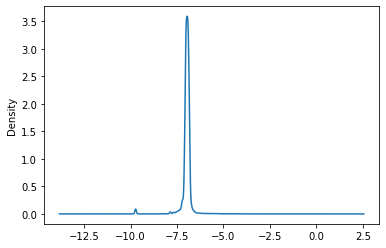

In [ ]:
df_0['info'].plot.kde();

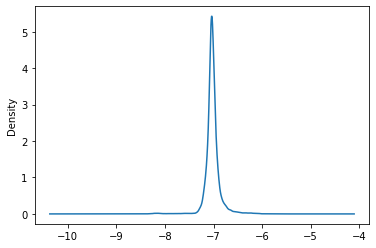

In [ ]:
df_0['pred'].plot.kde();

In [ ]:
_df.memory_usage().sum()/1024**3

0.0002981424331665039

Fancy Indexing:

In [ ]:
arr = np.empty((8,4))

In [ ]:
for i in range(8):
    arr[i] = i

In [ ]:
arr

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 2.],
       [3., 3., 3., 3.],
       [4., 4., 4., 4.],
       [5., 5., 5., 5.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]])

In [ ]:
arr[[4, 3, 0, 6]]

array([[4., 4., 4., 4.],
       [3., 3., 3., 3.],
       [0., 0., 0., 0.],
       [6., 6., 6., 6.]])

In [ ]:
arr[[-3, -5, -7]]

array([[5., 5., 5., 5.],
       [3., 3., 3., 3.],
       [1., 1., 1., 1.]])

In [ ]:
arr = np.arange(32).reshape((8,4))

In [ ]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31]])

In [ ]:
test_eq(arr[[1, 5, 7, 2], [0, 3, 1, 2]] , [arr[o] for o in list(zip([1, 5, 7, 2], [0, 3, 1, 2]))])

In [ ]:
arr[[1, 5, 7, 2]]

array([[ 4,  5,  6,  7],
       [20, 21, 22, 23],
       [28, 29, 30, 31],
       [ 8,  9, 10, 11]])

In [ ]:
arr[[1, 5, 7, 2]][:, [0, 3, 1, 2]]

array([[ 4,  7,  5,  6],
       [20, 23, 21, 22],
       [28, 31, 29, 30],
       [ 8, 11,  9, 10]])

In [ ]:
ind = [[0,3,1,2], [2,1,3,0], [0,1,2,3], [3,1,2,0]]
ind

[[0, 3, 1, 2], [2, 1, 3, 0], [0, 1, 2, 3], [3, 1, 2, 0]]

In [ ]:
arr[[1, 5, 7, 2]][ :, ind ]

array([[[ 4,  7,  5,  6],
        [ 6,  5,  7,  4],
        [ 4,  5,  6,  7],
        [ 7,  5,  6,  4]],

       [[20, 23, 21, 22],
        [22, 21, 23, 20],
        [20, 21, 22, 23],
        [23, 21, 22, 20]],

       [[28, 31, 29, 30],
        [30, 29, 31, 28],
        [28, 29, 30, 31],
        [31, 29, 30, 28]],

       [[ 8, 11,  9, 10],
        [10,  9, 11,  8],
        [ 8,  9, 10, 11],
        [11,  9, 10,  8]]])

In [ ]:
arr[[1, 5, 7, 2]][[0, 3, 1, 2], :]

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [20, 21, 22, 23],
       [28, 29, 30, 31]])

Rearrange columns:

In [ ]:
a = array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])
a

array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])

change it to 

In [ ]:
array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

by applying the permutation

0 -> 0 

1 -> 4

2 -> 1

3 -> 3

4 -> 2

In [ ]:
permutation = [0,4,1,3,2]

In [ ]:
idx = np.empty_like(permutation)

In [ ]:
idx

array([0, 4, 1, 3, 2])

In [ ]:
idx[permutation] = np.arange(len(permutation))

In [ ]:
idx

array([0, 2, 4, 3, 1])

In [ ]:
a

array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])

In [ ]:
a[:,idx]

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

In [ ]:
a[:] = a[:,idx] # in-place modifcation of a

In [ ]:
a

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

## Implement LambdaMART

### Dataset:

What's in this dataframe?
* **qid** - the unique identifier of the query (ie rambo). Here it maps to a query keywords, but qid could mean any query entity for our domain, a user, a user+keyword, keyword+location - whatever makes sense!
* **keywords** - the search terms corresponding to the qid
* **docId** - the document being graded. A movie in TheMovieDB
* **grade** - how relevant the document is for the query (0 least relevant, 4 most relevant). This is kind of the label of learning to rank datasets
* **features** - a feature vector that will be used to predict relevance

In [ ]:
pkl_file = requests.get("http://softwaredoug.com/data/title_judgments_logged.json.gz")
judgments = pd.read_json(BytesIO(pkl_file.content), compression='gzip')
judgments

,uid,qid,keywords,docId,grade,features
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]"
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]"
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]"
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]"
4,11368,1,rambo,1368,4,"[0.0, 11.113943]"
...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]"
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]"
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]"
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]"


### Reinitialize training set for this round of training

Next, we'll copy this dataframe and perform some initialization. Most importantly, we need to set up:

1. Set up the last round's model prediction (initially at 0.0)
2. sort this prediction within each query group (important to do this with stable sort so that we avoid seeing the impact of swapping equivalent results.)

Each round we attempt to learn the errors of the previous round. We start the first round with the judgements themselves, and initialize the prediction of the model thus far to 0.0.

We sort the current prediction on each round before the pairwise swapping procedure.

In [ ]:
lambdas_per_query = judgments.copy()

In [ ]:
lambdas_per_query['last_prediction'] = 0.0

In [ ]:
lambdas_per_query.sort_values(by=['qid', 'last_prediction'], ascending=[True, False], kind='stable')

,uid,qid,keywords,docId,grade,features,last_prediction
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.0
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0
4,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0
...,...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]",0.0
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]",0.0
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]",0.0
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]",0.0


### Compute DCG stats

To prep for pairwise swapping using DCG as a statistic - compute DCG stats relative to the `last_prediction` ranking. This includes:

* `display_rank`: where the result ranks when ordered by `last_prediction`
* `discount`: the weight given to this display position. Positions higher up on the page / lower `display_ranks` are weighed as more important.
* `gain`: the weight of a given label/grade. 2^grade - 1.

We compute `display_rank` here by first sorting on the model's score (`last_prediction`) then using Pandas cumcount, which simply assigns a counter to each row in each query, with items sorted first recieving a lower value.

In [ ]:
lambdas_per_query.sort_values(by=['qid', 'last_prediction'], ascending=[True, False], kind='stable')

,uid,qid,keywords,docId,grade,features,last_prediction
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.0
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0
4,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0
...,...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]",0.0
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]",0.0
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]",0.0
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]",0.0


In [ ]:
lambdas_per_query['display_rank'] = lambdas_per_query.groupby('qid').cumcount()
lambdas_per_query['discount'] = 1 / np.log2(2 + lambdas_per_query['display_rank'])
lambdas_per_query['gain'] = (2**lambdas_per_query['grade'] - 1)

In [ ]:
lambdas_per_query[lambdas_per_query.qid == 9][['qid', 'display_rank', 'discount', 'grade', 'gain']]

,qid,display_rank,discount,grade,gain
294,9,0,1.000000,4,15
295,9,1,0.630930,0,0
296,9,2,0.500000,0,0
297,9,3,0.430677,0,0
298,9,4,0.386853,0,0
299,9,5,0.356207,0,0
300,9,6,0.333333,0,0
301,9,7,0.315465,0,0
302,9,8,0.301030,0,0
303,9,9,0.289065,0,0


### Map each result to every other result and compute pairwise deltas

LambdaMART works by accumulating the impact to our ranking metric when a query's potential result X is swapped with result Y.

```python
for query_judgments in judgments.groupby('qid'):
    for result_x in query_judgments:
        for result_y in query_judgments:
             dcg_x += swap(result_x, result_y)
```

With Pandas we can do this in an efficient way:

Per query (`qid`), we must line up each result (i.e. document returned) with every other result of that query. We do that with an outer join of every row for a query to every other row for that query:

In [ ]:
# Pairing the result in each group with every other (including itself) in that group 
# In other words this is taking the cartesian product of each group with itself
swaps = lambdas_per_query.merge(lambdas_per_query, on='qid', how='outer')
swaps

,uid_x,qid,keywords_x,docId_x,grade_x,features_x,last_prediction_x,display_rank_x,discount_x,gain_x,uid_y,keywords_y,docId_y,grade_y,features_y,last_prediction_y,display_rank_y,discount_y,gain_y
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15,17555,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15
1,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15,11370,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.630930,7
2,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15,11369,rambo,1369,3,"[6.036743, 11.113943]",0.0,2,0.500000,7
3,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15,113258,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0,3,0.430677,3
4,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15,11368,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49019,4043052,40,star wars,43052,0,"[0.0, 0.0]",0.0,29,0.201849,0,4037079,star wars,37079,0,"[0.0, 0.0]",0.0,25,0.210310,0
49020,4043052,40,star wars,43052,0,"[0.0, 0.0]",0.0,29,0.201849,0,40126757,star wars,126757,0,"[0.0, 0.0]",0.0,26,0.208015,0
49021,4043052,40,star wars,43052,0,"[0.0, 0.0]",0.0,29,0.201849,0,4039797,star wars,39797,0,"[0.0, 0.0]",0.0,27,0.205847,0
49022,4043052,40,star wars,43052,0,"[0.0, 0.0]",0.0,29,0.201849,0,4018112,star wars,18112,0,"[0.0, 0.0]",0.0,28,0.203795,0


In [ ]:
test_eq(np.square(lambdas_per_query.groupby('qid').size().to_numpy()).sum(), len(swaps))
test_eq(swaps.groupby('qid').size(), lambdas_per_query.groupby('qid').size().apply(np.square))

Deltas computed:
After the swap the _x version of each value has the higer grade. It turns out that the impact of the swap on the DCG is `(discount_x - dsicount_y) * (gain_x - gain_y)`.

In [ ]:
# Comnpute the impact on DCG if x swapped with y
swaps['delta'] = np.abs( (swaps['discount_x'] - swaps['discount_y']) * (swaps['gain_x'] - swaps['gain_y']) )
swaps[['qid', 'display_rank_x', 'discount_x', 'gain_x', 'display_rank_y', 'discount_y', 'gain_y', 'delta']]

,qid,display_rank_x,discount_x,gain_x,display_rank_y,discount_y,gain_y,delta
0,1,0,1.000000,15,0,1.000000,15,0.000000
1,1,0,1.000000,15,1,0.630930,7,2.952562
2,1,0,1.000000,15,2,0.500000,7,4.000000
3,1,0,1.000000,15,3,0.430677,3,6.831881
4,1,0,1.000000,15,4,0.386853,15,0.000000
...,...,...,...,...,...,...,...,...
49019,40,29,0.201849,0,25,0.210310,0,0.000000
49020,40,29,0.201849,0,26,0.208015,0,0.000000
49021,40,29,0.201849,0,27,0.205847,0,0.000000
49022,40,29,0.201849,0,28,0.203795,0,0.000000


Note that it is not entirely self-evident that the DCG swap impact is the above formula, but let's work out the math!

In [ ]:
swaps[swaps.qid ==1].head()

,uid_x,qid,keywords_x,docId_x,grade_x,features_x,last_prediction_x,display_rank_x,discount_x,gain_x,uid_y,keywords_y,docId_y,grade_y,features_y,last_prediction_y,display_rank_y,discount_y,gain_y,delta
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.0,15,17555,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15,0.000000
1,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.0,15,11370,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.630930,7,2.952562
2,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.0,15,11369,rambo,1369,3,"[6.036743, 11.113943]",0.0,2,0.500000,7,4.000000
3,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.0,15,113258,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0,3,0.430677,3,6.831881
4,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.0,15,11368,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15,0.000000


Let's compute the DCG for `qid == 1`:

In [ ]:
tmp_qid_1 = lambdas_per_query[lambdas_per_query.qid == 1]
tmp_qid_1.head()

,uid,qid,keywords,docId,grade,features,last_prediction,display_rank,discount,gain
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.000000,15
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.630930,7
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.0,2,0.500000,7
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0,3,0.430677,3
4,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15


let's compute the DCG:

In [ ]:
dcg = np.sum(tmp_qid_1['discount'] * tmp_qid_1['gain'])
ic(dcg);

ic| dcg: 31.710601407483463


Let's swap the first two docs and recompute DCG:

In [ ]:
# do not swap the discount
cols = list(tmp_qid_1.columns)
tmp_qid_1.loc[0, cols[:-2] + [cols[-1]]], tmp_qid_1.loc[1, cols[:-2] + [cols[-1]]] = tmp_qid_1.loc[1, cols[:-2] + [cols[-1]]], tmp_qid_1.loc[0, cols[:-2] + [cols[-1]]]

In [ ]:
tmp_qid_1.head()

,uid,qid,keywords,docId,grade,features,last_prediction,display_rank,discount,gain
0,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,1.000000,7
1,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,0.630930,15
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.0,2,0.500000,7
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0,3,0.430677,3
4,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15


In [ ]:
dcg_after_swap = np.sum(tmp_qid_1['discount'] * tmp_qid_1['gain'])
ic(dcg_after_swap);

ic| dcg_after_swap: 28.758039436055125


In [ ]:
pd.DataFrame(swaps.loc[1]).T

,uid_x,qid,keywords_x,docId_x,grade_x,features_x,last_prediction_x,display_rank_x,discount_x,gain_x,uid_y,keywords_y,docId_y,grade_y,features_y,last_prediction_y,display_rank_y,discount_y,gain_y,delta
1,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.0,15,11370,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.63093,7,2.952562


In [ ]:
test_close((swaps.loc[1].discount_x - swaps.loc[1].discount_y) * (swaps.loc[1].gain_x - swaps.loc[1].gain_y) , (dcg - dcg_after_swap))

In [ ]:
swaps[swaps.qid == 1][ ( (swaps.docId_x == 7555) & (swaps.docId_y == 1370) | ((swaps.docId_x == 1370) & (swaps.docId_y == 7555)) ) ]

,uid_x,qid,keywords_x,docId_x,grade_x,features_x,last_prediction_x,display_rank_x,discount_x,gain_x,uid_y,keywords_y,docId_y,grade_y,features_y,last_prediction_y,display_rank_y,discount_y,gain_y,delta
1,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.00000,15,11370,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.63093,7,2.952562
41,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.63093,7,17555,rambo,7555,4,"[11.657399, 10.083591]",0.0,0,1.00000,15,2.952562


In [ ]:
(1-0.63)* (15-7), (0.63 - 1)*(7-15)

(2.96, 2.96)

Note:
1. +ve delta means swapping x and y causes dcg to reduce by that value
2. -ve delta means swapping x and y causes dcg to increase by that value

In [ ]:
swaps[(swaps.qid == 1) & (swaps.delta < 0.0)]

,uid_x,qid,keywords_x,docId_x,grade_x,features_x,last_prediction_x,display_rank_x,discount_x,gain_x,uid_y,keywords_y,docId_y,grade_y,features_y,last_prediction_y,display_rank_y,discount_y,gain_y,delta
45,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.630930,7,11368,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15,-1.952616
86,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.0,2,0.500000,7,11368,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15,-0.905178
127,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0,3,0.430677,3,11368,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15,-0.525885
165,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15,11370,rambo,1370,3,"[9.456276, 13.265001]",0.0,1,0.630930,7,-1.952616
166,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0,4,0.386853,15,11369,rambo,1369,3,"[6.036743, 11.113943]",0.0,2,0.500000,7,-0.905178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,1600,1,rambo,600,1,"[0.0, 0.0]",0.0,31,0.198240,1,170,rambo,70,0,"[0.0, 0.0]",0.0,22,0.218104,0,-0.019864
1294,1600,1,rambo,600,1,"[0.0, 0.0]",0.0,31,0.198240,1,122777,rambo,22777,0,"[0.0, 0.0]",0.0,23,0.215338,0,-0.017098
1295,1600,1,rambo,600,1,"[0.0, 0.0]",0.0,31,0.198240,1,143189,rambo,43189,0,"[0.0, 0.0]",0.0,24,0.212746,0,-0.014506
1296,1600,1,rambo,600,1,"[0.0, 0.0]",0.0,31,0.198240,1,1318,rambo,318,0,"[0.0, 0.0]",0.0,25,0.210310,0,-0.012070


Important to note that we haven't accumulated anything yet! In other words, we have computed the swap part of the nest for loop but not the plus equal part. We'll do it shortly.

### Rho - weight of each swap in proportion to its error:

Let's focus on Lambda part of LambdaMART for a while and try to understand what exactly it is. 

Lambdas refer to what's being predicted by the model. One way to think of this is to say that lambdas are reformulated point wise predictions. Each training round of gradient boosting (each new tree added to the MART) we perform the transformation of the list wise loss function (i.e., DCG) into a pointwsie supervised learning problem.



We need to examine another importnat variable  - how wrong the model is. AKA, how well `last_prediction` predicts the correct ordering predicts the correct ordering between the two potential search results. We do that next:

A value `rho` computes how well (or not well!) the existing model predicts the current pair's relative relevance. If the xth result appears to be more relevant than the yth, and the model predicts so, then we're good. Otherwise the existing model gets a demerit, and we try to make up for their negligence.

In [ ]:
swaps['rho'] = 1 / (1 + np.exp(swaps['last_prediction_x'] - swaps['last_prediction_y']))
swaps[['qid', 'display_rank_x', 'display_rank_y', 'delta', 'last_prediction_x', 'last_prediction_y', 'rho']]

,qid,display_rank_x,display_rank_y,delta,last_prediction_x,last_prediction_y,rho
0,1,0,0,0.000000,0.0,0.0,0.5
1,1,0,1,2.952562,0.0,0.0,0.5
2,1,0,2,4.000000,0.0,0.0,0.5
3,1,0,3,6.831881,0.0,0.0,0.5
4,1,0,4,0.000000,0.0,0.0,0.5
...,...,...,...,...,...,...,...
49019,40,29,25,0.000000,0.0,0.0,0.5
49020,40,29,26,0.000000,0.0,0.0,0.5
49021,40,29,27,0.000000,0.0,0.0,0.5
49022,40,29,28,0.000000,0.0,0.0,0.5


## Fine-tuning the Classifier with the Learned Label Embeddings 